In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
# /content/drive/MyDrive/ml_runs/sbu_models/Model_1_Original/train.py
import os, json, pickle, random
from pathlib import Path
from typing import Any, Dict, List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATA_ROOT = Path("/content/drive/MyDrive/ml_runs/sbu_hybrid_colab/data/sbu")
WORK_ROOT = Path("/content/drive/MyDrive/ml_runs/sbu_models/Model_1_Original/outputs")
WORK_ROOT.mkdir(parents=True, exist_ok=True)

EPOCHS       = 200
PATIENCE     = 20
BATCH_SIZE   = 64
LR           = 1e-3
WEIGHT_DECAY = 0.0
NUM_WORKERS  = 2
PIN_MEMORY   = torch.cuda.is_available()
DROPOUT      = 0.25
T_KERNEL     = 9

with open(WORK_ROOT/"hyperparams.json","w") as f:
    json.dump({
        "epochs":EPOCHS,
        "patience":PATIENCE,
        "batch_size":BATCH_SIZE,
        "lr":LR,
        "weight_decay":WEIGHT_DECAY,
        "num_workers":NUM_WORKERS,
        "pin_memory":PIN_MEMORY,
        "dropout":DROPOUT,
        "t_kernel":T_KERNEL
    }, f, indent=2)

def fold_paths(k:int)->Dict[str, Path]:
    d = DATA_ROOT / f"fold{k}"
    return {
        "train_x": d/"train_data.npy", "train_y": d/"train_label.pkl",
        "val_x":   d/"val_data.npy",   "val_y":   d/"val_label.pkl",
        "test_x":  d/"test_data.npy",  "test_y":  d/"test_label.pkl"
    }

def _parse_int_scalar(x: Any):
    if isinstance(x, (int, np.integer)):
        return int(x)
    if isinstance(x, str):
        s = x.strip()
        if s.lstrip("-").isdigit():
            return int(s)
    return None

def _extract_list_from_unknown(obj: Any) -> List[Any]:
    if isinstance(obj, np.ndarray):
        return obj.reshape(-1).tolist()
    if isinstance(obj, (list, tuple)):
        return list(obj)
    return []

def _to_int_list(seq: Any, expected_N: int) -> List[int]:
    if isinstance(seq, np.ndarray):
        if seq.dtype.kind in "iu":
            out = seq.reshape(-1).astype(np.int64).tolist()
        else:
            out = []
            for it in seq.reshape(-1).tolist():
                v = _parse_int_scalar(it)
                if v is None:
                    raise TypeError(f"Cannot parse int from array element: {repr(it)[:120]}")
                out.append(v)
    elif isinstance(seq, (list, tuple)):
        out = []
        for it in seq:
            if isinstance(it, (int, np.integer)):
                out.append(int(it))
            else:
                v = _parse_int_scalar(it)
                if v is None:
                    raise TypeError(f"Could not extract int from labels element: {repr(it)[:120]}")
                out.append(int(v))
    else:
        raise TypeError(f"Unsupported label container: {type(seq).__name__}")
    if len(out) != expected_N:
        raise ValueError(f"Label length {len(out)} != expected {expected_N}")
    return out

def load_labels(y_path: Path, expected_N: int) -> np.ndarray:
    with open(y_path, "rb") as f:
        obj = pickle.load(f)

    if isinstance(obj, tuple) and len(obj) == 2:
        cand = obj[0]
        if isinstance(cand, (list, tuple, np.ndarray)):
            y = np.array(_to_int_list(cand, expected_N), dtype=np.int64)
        else:
            raise TypeError(f"Tuple[0] not list-like in {y_path}")
    elif isinstance(obj, (list, tuple, np.ndarray)):
        y = np.array(_to_int_list(obj, expected_N), dtype=np.int64)
    elif isinstance(obj, dict):
        for k in ("labels","y","targets","classes"):
            if k in obj:
                y = np.array(_to_int_list(obj[k], expected_N), dtype=np.int64)
                break
        else:
            vals = []
            for v in obj.values():
                arr = _extract_list_from_unknown(v)
                if arr:
                    vals = arr
                    break
            if not vals:
                raise TypeError(f"Unsupported dict structure in {y_path}")
            y = np.array(_to_int_list(vals, expected_N), dtype=np.int64)
    else:
        raise TypeError(f"Unsupported label.pkl type: {type(obj).__name__}")

    uniq = np.unique(y)
    if not np.array_equal(uniq, np.arange(int(uniq.max())+1)):
        mapping = {int(c): i for i, c in enumerate(sorted(uniq))}
        y = np.vectorize(lambda z: mapping[int(z)])(y).astype(np.int64)
    return y

class SBUFoldDataset(Dataset):
    def __init__(self, x_path: Path, y_path: Path):
        x = np.load(x_path)
        if x.ndim == 4:
            x = x[..., None]
        self.x = x
        self.y = load_labels(y_path, expected_N=x.shape[0])
    def __len__(self): return self.x.shape[0]
    def __getitem__(self, idx):
        return torch.from_numpy(self.x[idx]).float(), int(self.y[idx])

def _coco17_edges():
    E = [(0,1),(0,2),(1,3),(2,4),(5,6),(5,7),(7,9),(6,8),(8,10),(5,11),(6,12),
         (11,13),(13,15),(12,14),(14,16),(11,12)]
    return sorted(set(E + [(v,u) for u,v in E]))

def _kinect15_edges():
    E = [(0,1),(1,2),(1,3),(3,4),(4,5),(1,6),(6,7),(7,8),
         (2,9),(9,10),(10,11),(2,12),(12,13),(13,14),(9,12)]
    return sorted(set(E + [(v,u) for u,v in E]))

def normalized_adjacency(V:int):
    A = np.zeros((V,V), dtype=np.float32)
    if V == 17:
        edges = _coco17_edges()
    elif V == 15:
        edges = _kinect15_edges()
    else:
        center = V // 2
        edges = [(i,center) for i in range(V) if i != center]
        edges += [(center,i) for i in range(V) if i != center]
    for u,v in edges:
        A[u,v] = 1.0
    for i in range(V):
        A[i,i] = 1.0
    D = A.sum(axis=1)
    D_inv_sqrt = np.power(np.maximum(D, 1e-8), -0.5)
    D_inv_sqrt = np.diag(D_inv_sqrt)
    return torch.tensor(D_inv_sqrt @ A @ D_inv_sqrt, dtype=torch.float32)

class GraphConv(nn.Module):
    def __init__(self, c_in, c_out, A):
        super().__init__()
        self.register_buffer("A", A)
        self.theta = nn.Conv2d(c_in, c_out, 1, bias=False)
    def forward(self, x):
        xa = torch.einsum("nctv,vw->nctw", x, self.A)
        return self.theta(xa)

class STGCNBlock(nn.Module):
    def __init__(self, c_in, c_out, A, t_kernel=9, stride_t=1):
        super().__init__()
        pad_t = t_kernel // 2
        self.gcn = GraphConv(c_in, c_out, A)
        self.bn1 = nn.BatchNorm2d(c_out)
        self.do = nn.Dropout(DROPOUT)
        self.tcn = nn.Conv2d(c_out, c_out, (t_kernel,1), stride=(stride_t,1), padding=(pad_t,0), bias=False)
        self.bn2 = nn.BatchNorm2d(c_out)
        self.res = nn.Identity() if (c_in==c_out and stride_t==1) else nn.Sequential(
            nn.Conv2d(c_in, c_out, 1, stride=(stride_t,1), bias=False),
            nn.BatchNorm2d(c_out)
        )
    def forward(self, x):
        r = self.res(x)
        x = F.relu(self.bn1(self.gcn(x)))
        x = self.do(x)
        x = self.bn2(self.tcn(x))
        return F.relu(x + r)

class STGCNBaseline(nn.Module):
    def __init__(self, c_in, num_classes, V=15, t_kernel=T_KERNEL):
        super().__init__()
        A = normalized_adjacency(V)
        self.stem = nn.Sequential(nn.Conv2d(c_in,64,1,bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.layer1 = STGCNBlock(64,64,A,t_kernel,1)
        self.layer2 = STGCNBlock(64,128,A,t_kernel,2)
        self.layer3 = STGCNBlock(128,128,A,t_kernel,1)
        self.layer4 = STGCNBlock(128,256,A,t_kernel,2)
        self.layer5 = STGCNBlock(256,256,A,t_kernel,1)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(256,num_classes)
    def forward(self, x):
        if x.dim()==5:
            x = x.sum(-1)
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)

@torch.no_grad()
def eval_loader(model, loader):
    model.eval()
    all_t, all_p = [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        out = model(xb)
        pred = out.argmax(1)
        all_t.extend(yb.cpu().tolist())
        all_p.extend(pred.cpu().tolist())
    acc = accuracy_score(all_t, all_p)
    prec_macro = precision_score(all_t, all_p, average="macro", zero_division=0)
    rec_macro  = recall_score(all_t, all_p, average="macro", zero_division=0)
    f1_macro   = f1_score(all_t, all_p, average="macro", zero_division=0)
    cm = confusion_matrix(all_t, all_p)
    rep = classification_report(all_t, all_p, output_dict=True, zero_division=0)
    return {"acc":acc,"prec":prec_macro,"rec":rec_macro,"f1":f1_macro,"cm":cm,"rep":rep}

def train_fold(k:int):
    paths = fold_paths(k)
    out_dir = WORK_ROOT/f"fold{k}"
    out_dir.mkdir(parents=True, exist_ok=True)

    tr_ds = SBUFoldDataset(paths["train_x"], paths["train_y"])
    va_ds = SBUFoldDataset(paths["val_x"], paths["val_y"])
    te_ds = SBUFoldDataset(paths["test_x"], paths["test_y"])

    tr_ld = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=True)
    va_ld = DataLoader(va_ds, batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    te_ld = DataLoader(te_ds, batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    C = tr_ds.x.shape[1]
    V = tr_ds.x.shape[3]
    num_class = int(max(tr_ds.y.max(), va_ds.y.max(), te_ds.y.max()) + 1)

    model = STGCNBaseline(c_in=C, num_classes=num_class, V=int(V)).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", patience=4, factor=0.5)

    best_val, best_ep, no_improve = -1.0, -1, 0
    history = []
    best_path = out_dir/"best.pt"

    for ep in range(1, EPOCHS+1):
        model.train()
        n, loss_sum = 0, 0.0
        for xb, yb in tr_ld:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            out = model(xb)
            loss = F.cross_entropy(out, yb)
            loss.backward()
            opt.step()
            loss_sum += float(loss) * yb.size(0)
            n += yb.size(0)

        tr_loss = loss_sum / max(1,n)
        tr_eval = eval_loader(model, tr_ld)
        va_eval = eval_loader(model, va_ld)
        sched.step(va_eval["acc"])

        history.append({
            "epoch": ep,
            "train_loss": tr_loss,
            "train_acc": tr_eval["acc"],
            "val_acc": va_eval["acc"],
            "val_f1": va_eval["f1"]
        })

        if va_eval["acc"] > best_val + 1e-8:
            best_val = va_eval["acc"]; best_ep = ep; no_improve = 0
            torch.save({"model": model.state_dict()}, best_path)
            np.savetxt(out_dir/"cm_val_best.csv", va_eval["cm"].astype(int), fmt="%d", delimiter=",")
            pd.DataFrame(va_eval["rep"]).to_csv(out_dir/"report_val_best.csv")
            with open(out_dir/"best.json","w") as f:
                json.dump({"best_epoch": int(best_ep), "best_val_acc": float(best_val)}, f, indent=2)
        else:
            no_improve += 1

        if no_improve >= PATIENCE:
            break

    pd.DataFrame(history).to_csv(out_dir/"history.csv", index=False)

    state = torch.load(best_path, map_location="cpu")
    model.load_state_dict(state["model"])

    te_eval = eval_loader(model, te_ld)
    np.savetxt(out_dir/"cm_test.csv", te_eval["cm"].astype(int), fmt="%d", delimiter=",")
    pd.DataFrame(te_eval["rep"]).to_csv(out_dir/"report_test.csv")
    with open(out_dir/"results.json","w") as f:
        json.dump({
            "best_val_acc": float(best_val), "best_epoch": int(best_ep),
            "test_acc": float(te_eval["acc"]),
            "test_precision_macro": float(te_eval["prec"]),
            "test_recall_macro": float(te_eval["rec"]),
            "test_f1_macro": float(te_eval["f1"])
        }, f, indent=2)

    print(f"[Fold{k}] best_val={best_val:.3f}@{best_ep} | "
          f"test_acc={te_eval['acc']:.3f} prec={te_eval['prec']:.3f} rec={te_eval['rec']:.3f} f1={te_eval['f1']:.3f}")

    return best_val, te_eval["acc"], te_eval["f1"]

def run_all():
    rows = []
    for k in range(1,6):
        val_acc, test_acc, f1 = train_fold(k)
        rows.append([val_acc, test_acc, f1])
    df = pd.DataFrame(rows, columns=["Best Val Acc","Test Acc","Test F1"], index=[f"Fold{i}" for i in range(1,6)])
    df.loc["Mean"] = df.mean(numeric_only=True).to_dict()
    df.to_csv(WORK_ROOT/"summary.csv", index=True)
    print(df)

if __name__ == "__main__":
    run_all()

/tmp/ipython-input-255649667.py:293: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  loss_sum += float(loss) * yb.size(0)


[Fold1] best_val=0.700@19 | test_acc=0.814 prec=0.641 rec=0.688 f1=0.662
[Fold2] best_val=0.759@39 | test_acc=0.953 prec=0.940 rec=0.896 f1=0.907
[Fold3] best_val=0.807@39 | test_acc=1.000 prec=1.000 rec=1.000 f1=1.000
[Fold4] best_val=0.759@19 | test_acc=0.814 prec=0.613 rec=0.688 f1=0.645
[Fold5] best_val=0.792@27 | test_acc=0.930 prec=0.938 rec=0.896 f1=0.894
       Best Val Acc  Test Acc   Test F1
Fold1      0.700000  0.813953  0.661630
Fold2      0.758621  0.953488  0.907051
Fold3      0.807018  1.000000  1.000000
Fold4      0.759259  0.813953  0.644872
Fold5      0.792453  0.930233  0.893939
Mean       0.763470  0.902326  0.821499



Model 2 (Multi-Stream) | Fold 1
[Fold1] Ep001 tr_loss=2.1637 tr_acc=0.203 val_acc=0.067 val_f1=0.042 | best=0.067@1
[Fold1] Ep005 tr_loss=1.8321 tr_acc=0.203 val_acc=0.167 val_f1=0.088 | best=0.167@3
[Fold1] Ep010 tr_loss=1.6445 tr_acc=0.323 val_acc=0.217 val_f1=0.171 | best=0.233@9
[Fold1] Ep015 tr_loss=1.5298 tr_acc=0.516 val_acc=0.383 val_f1=0.305 | best=0.383@15
[Fold1] Ep020 tr_loss=1.4233 tr_acc=0.573 val_acc=0.450 val_f1=0.386 | best=0.450@20
[Fold1] Ep025 tr_loss=1.3568 tr_acc=0.651 val_acc=0.417 val_f1=0.373 | best=0.450@20
[Fold1] Ep030 tr_loss=1.3201 tr_acc=0.656 val_acc=0.467 val_f1=0.417 | best=0.500@27
[Fold1] Ep035 tr_loss=1.2270 tr_acc=0.760 val_acc=0.500 val_f1=0.496 | best=0.517@33
[Fold1] Ep040 tr_loss=1.1724 tr_acc=0.708 val_acc=0.467 val_f1=0.476 | best=0.517@33
[Fold1] Ep045 tr_loss=1.1618 tr_acc=0.703 val_acc=0.483 val_f1=0.455 | best=0.517@33
[Fold1] Ep050 tr_loss=1.1797 tr_acc=0.729 val_acc=0.450 val_f1=0.424 | best=0.517@33
[Fold1] Early stopping at epoch 53 

<Figure size 640x480 with 0 Axes>

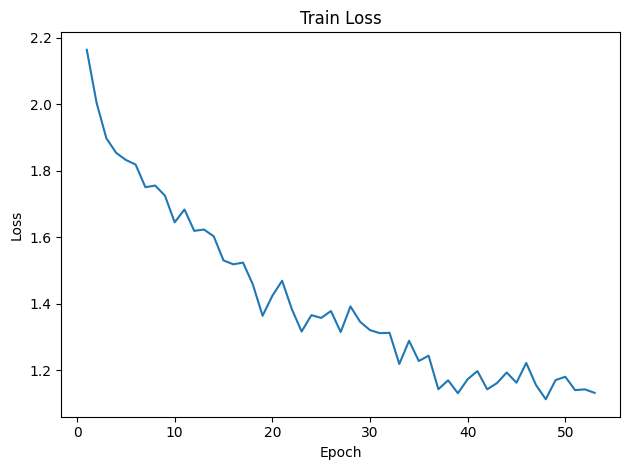

<Figure size 640x480 with 0 Axes>

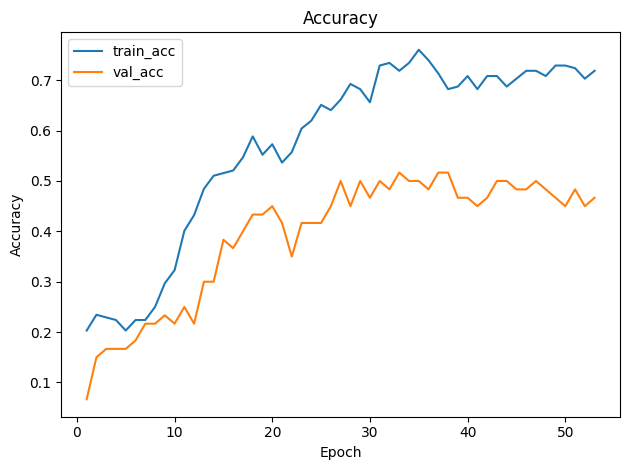

<Figure size 640x480 with 0 Axes>

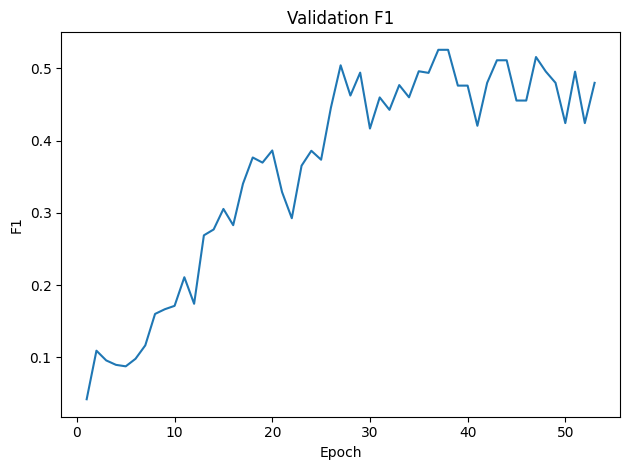

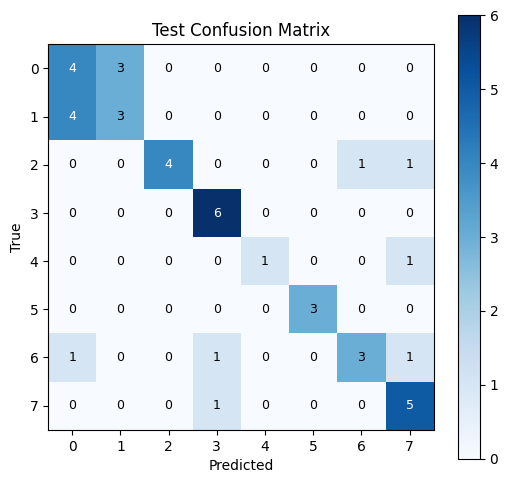

[Fold1] Best val acc=0.517 @ ep33 | Test acc=0.674, prec=0.759, rec=0.688, F1=0.700

Model 2 (Multi-Stream) | Fold 2
[Fold2] Ep001 tr_loss=2.1267 tr_acc=0.172 val_acc=0.138 val_f1=0.068 | best=0.138@1
[Fold2] Ep005 tr_loss=1.8700 tr_acc=0.292 val_acc=0.259 val_f1=0.174 | best=0.276@4
[Fold2] Ep010 tr_loss=1.7006 tr_acc=0.375 val_acc=0.328 val_f1=0.285 | best=0.328@9
[Fold2] Ep015 tr_loss=1.5397 tr_acc=0.516 val_acc=0.362 val_f1=0.331 | best=0.362@15
[Fold2] Ep020 tr_loss=1.3964 tr_acc=0.557 val_acc=0.397 val_f1=0.347 | best=0.448@19
[Fold2] Ep025 tr_loss=1.3835 tr_acc=0.620 val_acc=0.414 val_f1=0.374 | best=0.448@19
[Fold2] Ep030 tr_loss=1.3952 tr_acc=0.677 val_acc=0.431 val_f1=0.395 | best=0.466@27
[Fold2] Ep035 tr_loss=1.2125 tr_acc=0.729 val_acc=0.500 val_f1=0.450 | best=0.500@35
[Fold2] Ep040 tr_loss=1.1164 tr_acc=0.734 val_acc=0.603 val_f1=0.567 | best=0.603@40
[Fold2] Ep045 tr_loss=1.1913 tr_acc=0.776 val_acc=0.517 val_f1=0.536 | best=0.603@40
[Fold2] Ep050 tr_loss=1.1039 tr_acc=

<Figure size 640x480 with 0 Axes>

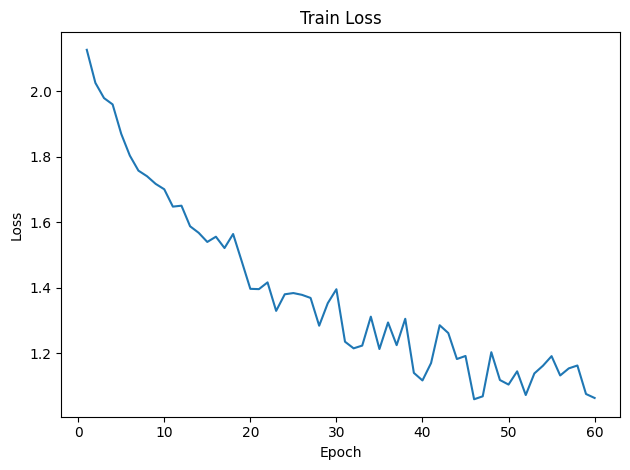

<Figure size 640x480 with 0 Axes>

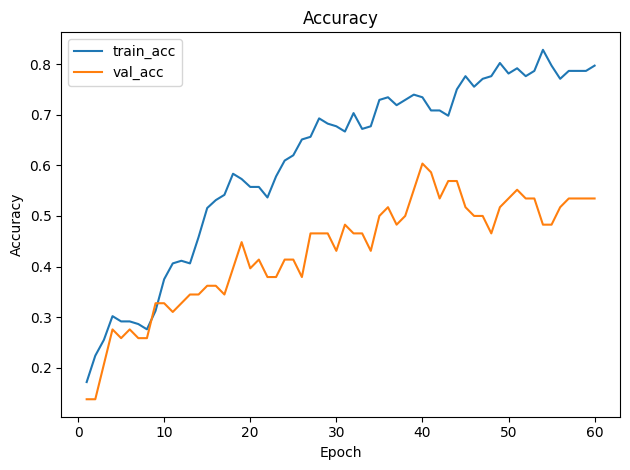

<Figure size 640x480 with 0 Axes>

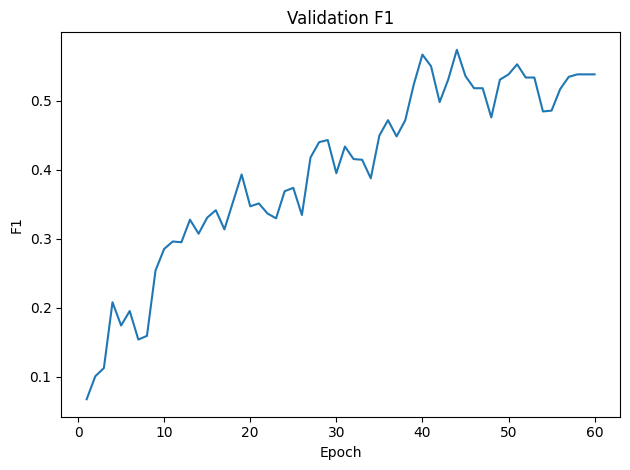

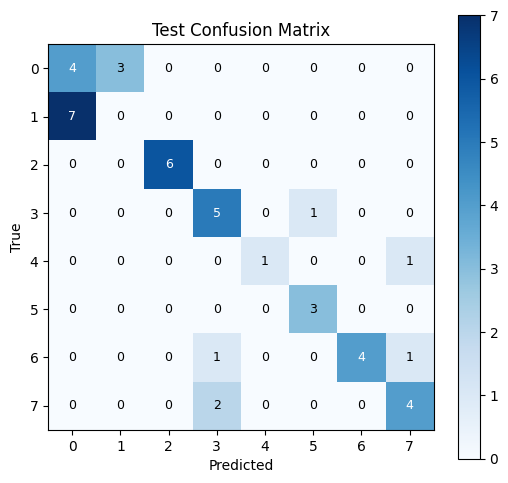

[Fold2] Best val acc=0.603 @ ep40 | Test acc=0.628, prec=0.676, rec=0.655, F1=0.644

Model 2 (Multi-Stream) | Fold 3
[Fold3] Ep001 tr_loss=2.1122 tr_acc=0.146 val_acc=0.105 val_f1=0.061 | best=0.105@1
[Fold3] Ep005 tr_loss=1.8771 tr_acc=0.224 val_acc=0.158 val_f1=0.090 | best=0.175@3
[Fold3] Ep010 tr_loss=1.6347 tr_acc=0.349 val_acc=0.246 val_f1=0.198 | best=0.246@10
[Fold3] Ep015 tr_loss=1.5131 tr_acc=0.469 val_acc=0.298 val_f1=0.249 | best=0.298@12
[Fold3] Ep020 tr_loss=1.5092 tr_acc=0.521 val_acc=0.368 val_f1=0.308 | best=0.368@20
[Fold3] Ep025 tr_loss=1.3239 tr_acc=0.568 val_acc=0.421 val_f1=0.341 | best=0.439@24
[Fold3] Ep030 tr_loss=1.3227 tr_acc=0.635 val_acc=0.474 val_f1=0.491 | best=0.474@30
[Fold3] Ep035 tr_loss=1.1345 tr_acc=0.693 val_acc=0.439 val_f1=0.398 | best=0.474@30
[Fold3] Ep040 tr_loss=1.0812 tr_acc=0.714 val_acc=0.474 val_f1=0.468 | best=0.474@30
[Fold3] Ep045 tr_loss=1.1144 tr_acc=0.734 val_acc=0.561 val_f1=0.581 | best=0.561@45
[Fold3] Ep050 tr_loss=1.1305 tr_acc

<Figure size 640x480 with 0 Axes>

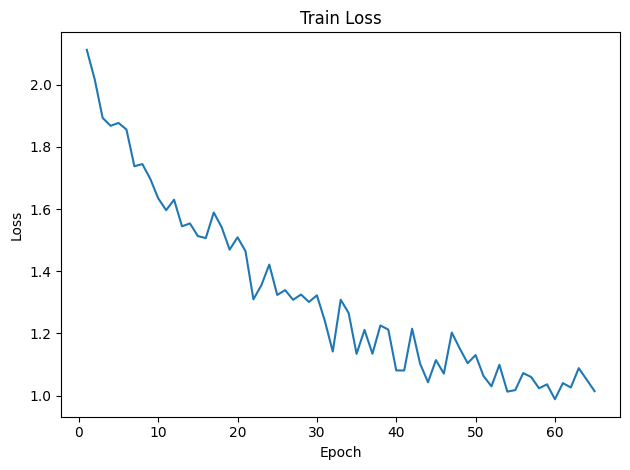

<Figure size 640x480 with 0 Axes>

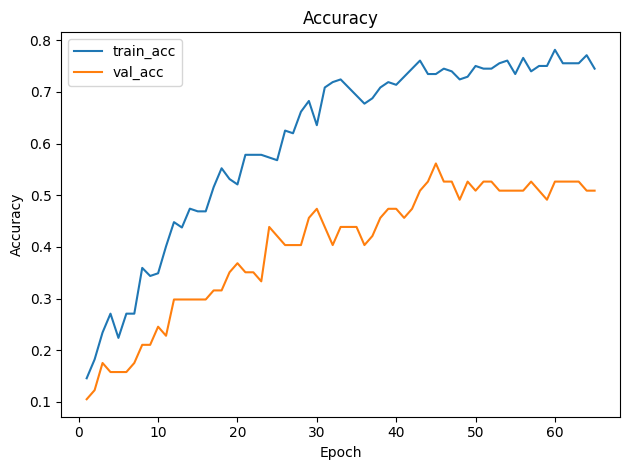

<Figure size 640x480 with 0 Axes>

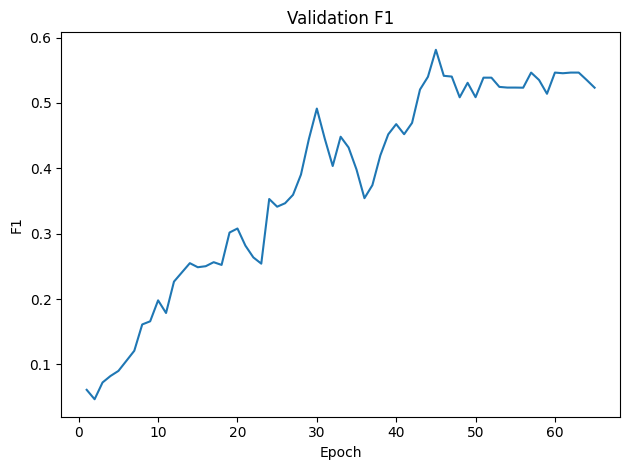

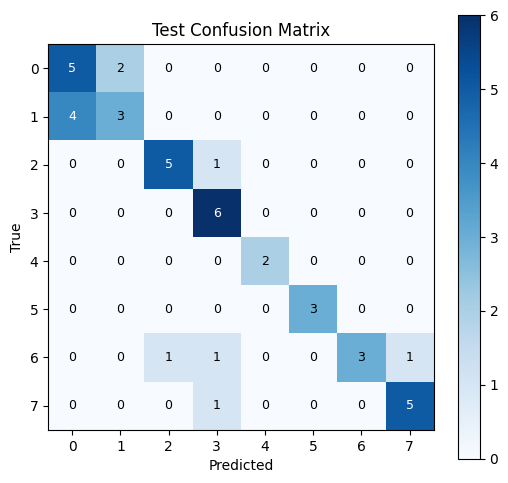

[Fold3] Best val acc=0.561 @ ep45 | Test acc=0.744, prec=0.811, rec=0.789, F1=0.782

Model 2 (Multi-Stream) | Fold 4
[Fold4] Ep001 tr_loss=2.1357 tr_acc=0.276 val_acc=0.185 val_f1=0.094 | best=0.185@1
[Fold4] Ep005 tr_loss=1.8352 tr_acc=0.255 val_acc=0.222 val_f1=0.165 | best=0.222@5
[Fold4] Ep010 tr_loss=1.6612 tr_acc=0.469 val_acc=0.370 val_f1=0.349 | best=0.370@10
[Fold4] Ep015 tr_loss=1.5749 tr_acc=0.552 val_acc=0.370 val_f1=0.350 | best=0.426@12
[Fold4] Ep020 tr_loss=1.5570 tr_acc=0.526 val_acc=0.389 val_f1=0.364 | best=0.463@17
[Fold4] Ep025 tr_loss=1.3808 tr_acc=0.573 val_acc=0.463 val_f1=0.420 | best=0.537@21
[Fold4] Ep030 tr_loss=1.3673 tr_acc=0.635 val_acc=0.500 val_f1=0.454 | best=0.537@21
[Fold4] Ep035 tr_loss=1.2447 tr_acc=0.667 val_acc=0.500 val_f1=0.466 | best=0.537@21
[Fold4] Ep040 tr_loss=1.3225 tr_acc=0.661 val_acc=0.519 val_f1=0.472 | best=0.537@21
[Fold4] Early stopping at epoch 41 (no val improvement for 20 epochs)


<Figure size 640x480 with 0 Axes>

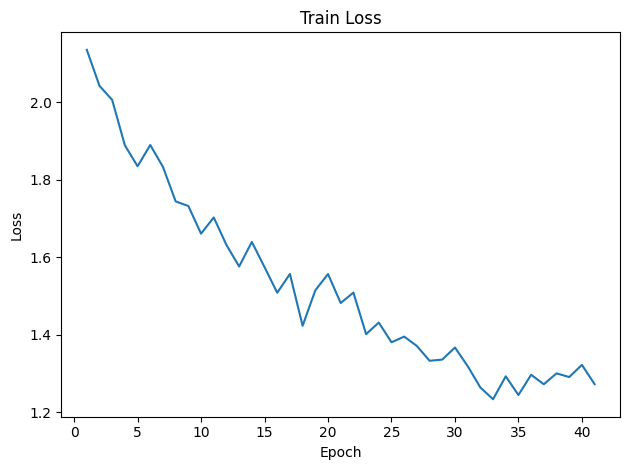

<Figure size 640x480 with 0 Axes>

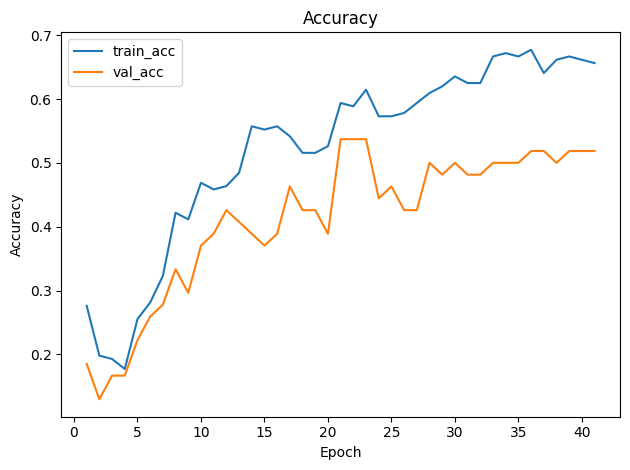

<Figure size 640x480 with 0 Axes>

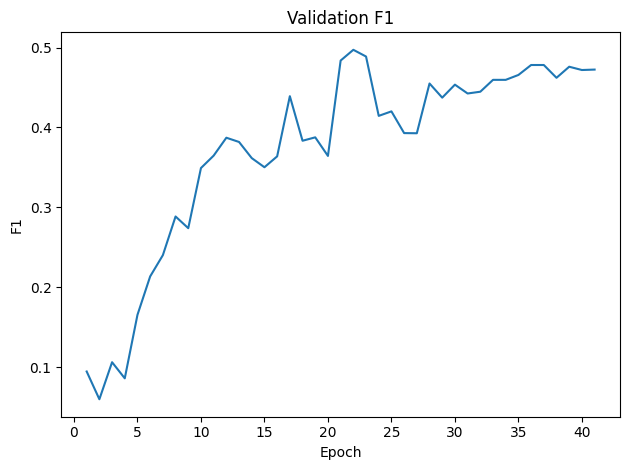

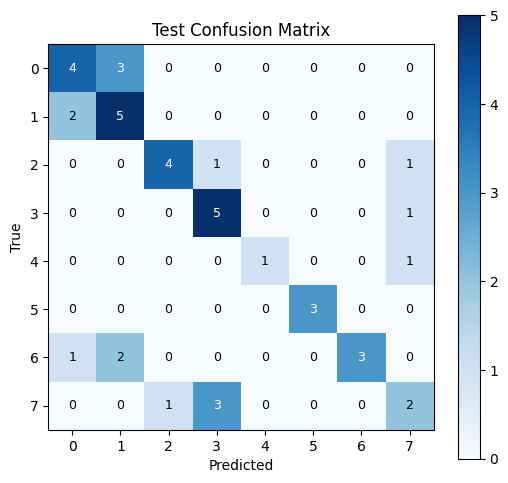

[Fold4] Best val acc=0.537 @ ep21 | Test acc=0.628, prec=0.728, rec=0.640, F1=0.656

Model 2 (Multi-Stream) | Fold 5
[Fold5] Ep001 tr_loss=2.1667 tr_acc=0.177 val_acc=0.132 val_f1=0.088 | best=0.132@1
[Fold5] Ep005 tr_loss=1.8918 tr_acc=0.219 val_acc=0.132 val_f1=0.077 | best=0.245@2
[Fold5] Ep010 tr_loss=1.7008 tr_acc=0.432 val_acc=0.302 val_f1=0.235 | best=0.321@9
[Fold5] Ep015 tr_loss=1.6335 tr_acc=0.469 val_acc=0.321 val_f1=0.301 | best=0.321@9
[Fold5] Ep020 tr_loss=1.5812 tr_acc=0.547 val_acc=0.358 val_f1=0.354 | best=0.358@16
[Fold5] Ep025 tr_loss=1.4287 tr_acc=0.568 val_acc=0.377 val_f1=0.363 | best=0.377@22
[Fold5] Ep030 tr_loss=1.4663 tr_acc=0.589 val_acc=0.358 val_f1=0.344 | best=0.396@26
[Fold5] Ep035 tr_loss=1.4252 tr_acc=0.630 val_acc=0.358 val_f1=0.338 | best=0.396@26
[Fold5] Ep040 tr_loss=1.3918 tr_acc=0.641 val_acc=0.358 val_f1=0.338 | best=0.396@26
[Fold5] Ep045 tr_loss=1.4139 tr_acc=0.620 val_acc=0.377 val_f1=0.352 | best=0.396@26
[Fold5] Early stopping at epoch 46 (n

<Figure size 640x480 with 0 Axes>

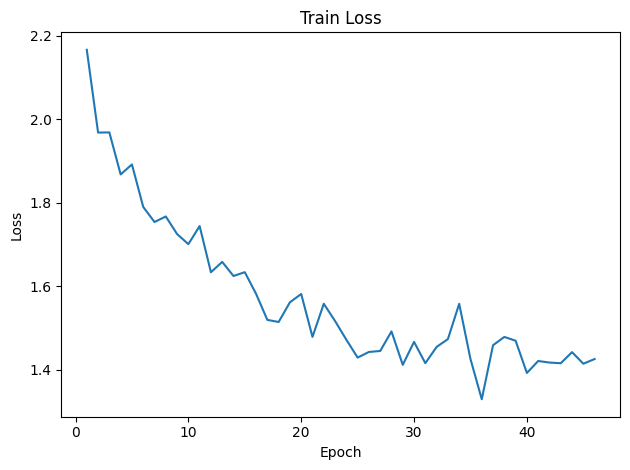

<Figure size 640x480 with 0 Axes>

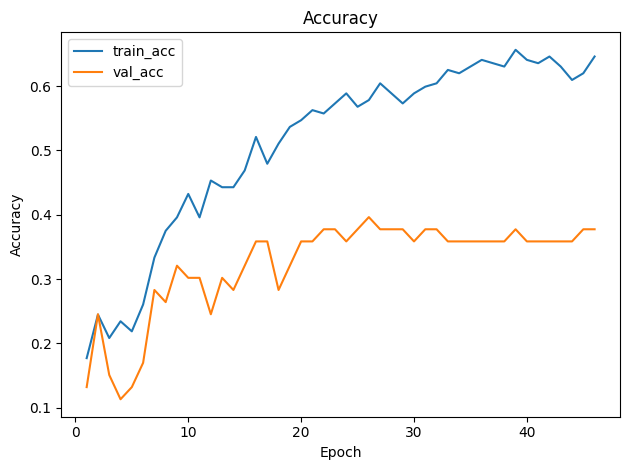

<Figure size 640x480 with 0 Axes>

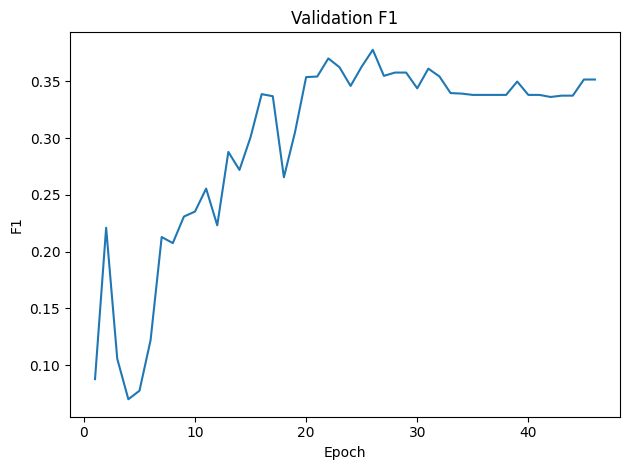

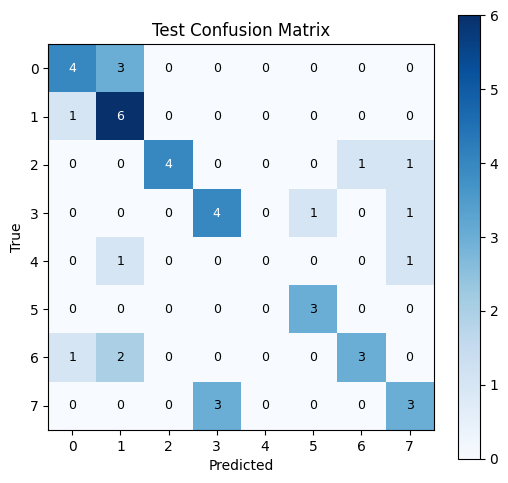

[Fold5] Best val acc=0.396 @ ep26 | Test acc=0.628, prec=0.592, rec=0.595, F1=0.577
Summary saved: /content/drive/MyDrive/ml_runs/sbu_models/Model_2_Original_MultiStream/outputs/summary.csv
       Best Val Acc  Best Epoch  Test Acc  Test Precision (macro)  \
Fold1      0.516667        33.0  0.674419                0.758681   
Fold2      0.603448        40.0  0.627907                0.675663   
Fold3      0.561404        45.0  0.744186                0.811111   
Fold4      0.537037        21.0  0.627907                0.728373   
Fold5      0.396226        26.0  0.627907                0.592262   
Mean       0.522956        33.0  0.660465                0.713218   

       Test Recall (macro)  Test F1 (macro)  Test Precision (weighted)  \
Fold1             0.687500         0.699954                   0.706072   
Fold2             0.654762         0.643651                   0.617336   
Fold3             0.788690         0.782292                   0.769509   
Fold4             0.639881    

In [3]:
# /content/drive/MyDrive/ml_runs/sbu_models/Model_2_Original_MultiStream/train.py

import os, json, pickle, random
from pathlib import Path
from typing import Any, Dict, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATA_ROOT = Path("/content/drive/MyDrive/ml_runs/sbu_hybrid_colab/data/sbu")
WORK_ROOT = Path("/content/drive/MyDrive/ml_runs/sbu_models/Model_2_Original_MultiStream/outputs")
WORK_ROOT.mkdir(parents=True, exist_ok=True)

EPOCHS       = 200
PATIENCE     = 20
BATCH_SIZE   = 64
LR           = 1e-3
WEIGHT_DECAY = 0.0
NUM_WORKERS  = 2
PIN_MEMORY   = torch.cuda.is_available()
DROPOUT      = 0.25

with open(WORK_ROOT/"hyperparams.json","w") as f:
    json.dump({
        "epochs":EPOCHS,"patience":PATIENCE,"batch_size":BATCH_SIZE,
        "lr":LR,"weight_decay":WEIGHT_DECAY,"num_workers":NUM_WORKERS,
        "dropout":DROPOUT
    }, f, indent=2)

def fold_paths(k:int)->Dict[str, Path]:
    d = DATA_ROOT / f"fold{k}"
    return {
        "train_x": d/"train_data.npy", "train_y": d/"train_label.pkl",
        "val_x":   d/"val_data.npy",   "val_y":   d/"val_label.pkl",
        "test_x":  d/"test_data.npy",  "test_y":  d/"test_label.pkl"
    }

def _first_int(x: Any):
    if isinstance(x, (int, np.integer)): return int(x)
    if isinstance(x, str):
        import re
        m = re.search(r"-?\d+", x)
        if m: return int(m.group(0))
        return None
    return None

def _to_int_list(seq: Any) -> List[int]:
    if isinstance(seq, np.ndarray):
        if seq.dtype.kind in "iu":
            return seq.astype(np.int64).tolist()
        seq = seq.tolist()
    if isinstance(seq, (list, tuple)):
        out = []
        for it in seq:
            v = _first_int(it)
            if v is None:
                raise ValueError(f"Label element not int-like: {repr(it)[:120]}")
            out.append(v)
        return out
    raise ValueError(f"Unsupported label container: {type(seq).__name__}")

def load_labels(y_path: Path, expected_N: int) -> np.ndarray:
    with open(y_path, "rb") as f:
        obj = pickle.load(f)

    if isinstance(obj, np.ndarray) and obj.ndim == 1 and obj.size == expected_N and obj.dtype.kind in "iu":
        y = obj.astype(np.int64)
    elif isinstance(obj, (list, tuple)) and len(obj) == expected_N and all(isinstance(e, (int, np.integer)) for e in obj):
        y = np.asarray(obj, dtype=np.int64)
    elif isinstance(obj, (list, tuple)) and len(obj) == 2:
        cand = obj[0]
        if isinstance(cand, (list, tuple, np.ndarray)):
            labels = _to_int_list(cand)
            if len(labels) != expected_N:
                raise ValueError(f"First element length {len(labels)} != N {expected_N} in {y_path}")
            y = np.asarray(labels, dtype=np.int64)
        else:
            raise ValueError(f"First element not list-like in {y_path}: {type(cand).__name__}")
    elif isinstance(obj, dict):
        for k in ["labels","y","targets"]:
            if k in obj:
                labels = _to_int_list(obj[k])
                if len(labels) != expected_N:
                    raise ValueError(f"dict['{k}'] length {len(labels)} != N {expected_N}")
                y = np.asarray(labels, dtype=np.int64)
                break
        else:
            raise ValueError(f"Unsupported dict label format keys={list(obj.keys())[:10]}")
    else:
        raise ValueError(f"Unsupported label.pkl type: {type(obj).__name__}")

    uniq = np.unique(y)
    if not np.array_equal(uniq, np.arange(int(uniq.max())+1)):
        mapping = {int(c):i for i,c in enumerate(sorted(uniq))}
        y = np.vectorize(lambda z: mapping[int(z)])(y).astype(np.int64)
    return y

class SBUFoldDataset(torch.utils.data.Dataset):
    def __init__(self, x_path: Path, y_path: Path):
        self.x = np.load(x_path)  # [N,C,T,V,M] or [N,C,T,V]
        N = self.x.shape[0]
        y = load_labels(y_path, expected_N=N)
        if len(y) != N:
            raise ValueError(f"N mismatch for {x_path.name}: X={N} y={len(y)}")
        self.y = y
        if self.x.ndim == 4:  # [N,C,T,V] -> add M=1
            self.x = self.x[..., None]
    def __len__(self): return self.x.shape[0]
    def __getitem__(self, idx):
        return torch.from_numpy(self.x[idx]).float(), int(self.y[idx])

class STGCNBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=9, stride=1, dropout=DROPOUT):
        super().__init__()
        pad = (kernel_size - 1) // 2
        self.conv = nn.Conv3d(in_ch, out_ch, kernel_size=(1, kernel_size, 1),
                              padding=(0, pad, 0), stride=(1, stride, 1), bias=False)
        self.bn   = nn.BatchNorm3d(out_ch)
        self.do   = nn.Dropout3d(dropout)
    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x = self.do(x)
        return x

class Branch(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.b1   = STGCNBlock(in_ch, 64,   dropout=DROPOUT)
        self.b2   = STGCNBlock(64,   128,  dropout=DROPOUT)
        self.b3   = STGCNBlock(128,  256,  dropout=DROPOUT)
        self.pool = nn.AdaptiveAvgPool3d((1,1,1))
        self.pre  = nn.Dropout(DROPOUT)
    def forward(self, x):                 # x: [N,C,T,V,1]
        x = self.b1(x); x = self.b2(x); x = self.b3(x)
        x = self.pool(x).flatten(1)       # [N,256]
        x = self.pre(x)
        return x

class MultiStreamSTGCN(nn.Module):
    def __init__(self, in_ch=2, num_class=8, num_streams=2):
        super().__init__()
        self.num_streams = num_streams
        self.branches = nn.ModuleList([Branch(in_ch) for _ in range(num_streams)])
        self.pre  = nn.Dropout(DROPOUT)
        self.fc   = nn.Linear(256 * num_streams, num_class)
    def forward(self, x):                 # x: [N,C,T,V,M]
        N,C,T,V,M = x.shape
        feats = []
        for s in range(self.num_streams):
            s_idx = s if s < M else (M-1)
            xs = x[..., s_idx:s_idx+1]   # [N,C,T,V,1]
            feats.append(self.branches[s](xs))
        feat = torch.cat(feats, dim=1)   # [N, 256*M]
        feat = self.pre(feat)
        return self.fc(feat)

@torch.no_grad()
def eval_loader(model, loader):
    model.eval()
    all_t, all_p = [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        out = model(xb)
        pred = out.argmax(1)
        all_t.extend(yb.cpu().numpy().tolist())
        all_p.extend(pred.cpu().numpy().tolist())
    acc   = accuracy_score(all_t, all_p)
    prec  = precision_score(all_t, all_p, average="macro",    zero_division=0)
    rec   = recall_score(all_t, all_p, average="macro",       zero_division=0)
    f1    = f1_score(all_t, all_p, average="macro",           zero_division=0)
    precw = precision_score(all_t, all_p, average="weighted", zero_division=0)
    recw  = recall_score(all_t, all_p, average="weighted",    zero_division=0)
    f1w   = f1_score(all_t, all_p, average="weighted",        zero_division=0)
    cm    = confusion_matrix(all_t, all_p)
    rep   = classification_report(all_t, all_p, output_dict=True, zero_division=0)
    return {
        "acc":acc, "prec":prec, "rec":rec, "f1":f1,
        "prec_w":precw, "rec_w":recw, "f1_w":f1w,
        "cm":cm, "rep":rep
    }

def plot_curves(history, out_dir: Path):
    df = pd.DataFrame(history)
    out_dir.mkdir(parents=True, exist_ok=True)

    plt.figure()
    df[["epoch","train_loss"]].set_index("epoch").plot(legend=False)
    plt.title("Train Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.tight_layout(); plt.savefig(out_dir/"loss.png", dpi=150); plt.show()

    plt.figure()
    df[["epoch","train_acc","val_acc"]].set_index("epoch").plot()
    plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.tight_layout(); plt.savefig(out_dir/"val_acc.png", dpi=150); plt.show()

    plt.figure()
    df[["epoch","val_f1"]].set_index("epoch").plot(legend=False)
    plt.title("Validation F1"); plt.xlabel("Epoch"); plt.ylabel("F1")
    plt.tight_layout(); plt.savefig(out_dir/"val_f1.png", dpi=150); plt.show()

def plot_confusion(cm: np.ndarray, out_path: Path, title="Confusion Matrix"):
    plt.figure(figsize=(5.5,5))
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title); plt.colorbar()
    ticks = np.arange(cm.shape[0])
    plt.xticks(ticks, ticks); plt.yticks(ticks, ticks)
    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            plt.text(j, i, str(val), ha="center", va="center",
                     color="white" if val > thresh else "black", fontsize=9)
    plt.ylabel("True"); plt.xlabel("Predicted")
    plt.tight_layout(); plt.savefig(out_path, dpi=150); plt.show()

def train_fold(k:int, epochs=EPOCHS, patience=PATIENCE, batch_size=BATCH_SIZE, lr=LR):
    paths = fold_paths(k)
    out_dir = WORK_ROOT/f"fold{k}"; out_dir.mkdir(parents=True, exist_ok=True)

    tr_ds = SBUFoldDataset(paths["train_x"], paths["train_y"])
    va_ds = SBUFoldDataset(paths["val_x"], paths["val_y"])
    te_ds = SBUFoldDataset(paths["test_x"], paths["test_y"])

    tr_ld = DataLoader(tr_ds, batch_size=batch_size, shuffle=True,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=True)
    va_ld = DataLoader(va_ds, batch_size=batch_size, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    te_ld = DataLoader(te_ds, batch_size=batch_size, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    C = tr_ds.x.shape[1]
    M = tr_ds.x.shape[-1]
    num_class = int(max(tr_ds.y.max(), va_ds.y.max(), te_ds.y.max()) + 1)

    model = MultiStreamSTGCN(in_ch=C, num_class=num_class, num_streams=M).to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", patience=4, factor=0.5)

    best_val, best_ep, no_improve = -1.0, -1, 0
    history = []
    best_path = out_dir/"best.pt"

    with open(out_dir/"label_summary.json","w") as f:
        json.dump({
            "train_unique": sorted(list(map(int, np.unique(tr_ds.y)))),
            "val_unique":   sorted(list(map(int, np.unique(va_ds.y)))),
            "test_unique":  sorted(list(map(int, np.unique(te_ds.y)))),
            "num_class":    int(num_class),
            "streams":      int(M)
        }, f, indent=2)

    for ep in range(1, epochs+1):
        model.train()
        n, loss_sum = 0, 0.0
        for xb, yb in tr_ld:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            out = model(xb)
            loss = F.cross_entropy(out, yb)
            loss.backward()
            opt.step()
            loss_sum += loss.item() * yb.size(0)
            n += yb.size(0)

        tr_loss = loss_sum / max(1, n)
        tr_eval = eval_loader(model, tr_ld)
        va_eval = eval_loader(model, va_ld)

        sched.step(va_eval["acc"])

        history.append({
            "epoch": ep,
            "train_loss": tr_loss,
            "train_acc": tr_eval["acc"],
            "val_acc": va_eval["acc"],
            "val_f1": va_eval["f1"]
        })

        if va_eval["acc"] > best_val + 1e-8:
            best_val = va_eval["acc"]
            best_ep = ep
            no_improve = 0
            torch.save({"model": model.state_dict()}, best_path)
            np.savetxt(out_dir/"cm_val_best.csv", va_eval["cm"].astype(int), fmt="%d", delimiter=",")
            pd.DataFrame(va_eval["rep"]).to_csv(out_dir/"report_val_best.csv")
            with open(out_dir/"best.json","w") as f:
                json.dump({"best_epoch": int(best_ep), "best_val_acc": float(best_val)}, f, indent=2)
        else:
            no_improve += 1

        if ep == 1 or ep % 5 == 0:
            pd.DataFrame(history).to_csv(out_dir/"history.csv", index=False)
            print(f"[Fold{k}] Ep{ep:03d} tr_loss={tr_loss:.4f} tr_acc={tr_eval['acc']:.3f} "
                  f"val_acc={va_eval['acc']:.3f} val_f1={va_eval['f1']:.3f} | best={best_val:.3f}@{best_ep}")

        if no_improve >= patience:
            print(f"[Fold{k}] Early stopping at epoch {ep} (no val improvement for {patience} epochs)")
            break

    pd.DataFrame(history).to_csv(out_dir/"history.csv", index=False)
    plot_curves(history, out_dir)

    state = torch.load(best_path, map_location="cpu")
    model.load_state_dict(state["model"])
    te = eval_loader(model, te_ld)
    np.savetxt(out_dir/"cm_test.csv", te["cm"].astype(int), fmt="%d", delimiter=",")
    pd.DataFrame(te["rep"]).to_csv(out_dir/"report_test.csv")
    with open(out_dir/"results.json","w") as f:
        json.dump({
            "best_val_acc": float(best_val),
            "best_epoch": int(best_ep),
            "test_acc": float(te["acc"]),
            "test_precision_macro": float(te["prec"]),
            "test_recall_macro": float(te["rec"]),
            "test_f1_macro": float(te["f1"]),
            "test_precision_weighted": float(te["prec_w"]),
            "test_recall_weighted": float(te["rec_w"]),
            "test_f1_weighted": float(te["f1_w"]),
            "streams_used": int(M)
        }, f, indent=2)

    plot_confusion(te["cm"], out_dir/"cm_test.png", title="Test Confusion Matrix")

    print(f"[Fold{k}] Best val acc={best_val:.3f} @ ep{best_ep} | "
          f"Test acc={te['acc']:.3f}, prec={te['prec']:.3f}, rec={te['rec']:.3f}, F1={te['f1']:.3f}")

    return {
        "best_val_acc": best_val,
        "best_epoch": best_ep,
        "test_acc": te["acc"],
        "test_precision_macro": te["prec"],
        "test_recall_macro": te["rec"],
        "test_f1_macro": te["f1"],
        "test_precision_weighted": te["prec_w"],
        "test_recall_weighted": te["rec_w"],
        "test_f1_weighted": te["f1_w"]
    }

def run_all():
    rows = []
    for k in range(1,6):
        print(f"\nModel 2 (Multi-Stream) | Fold {k}")
        r = train_fold(k)
        rows.append([
            r["best_val_acc"], r["best_epoch"], r["test_acc"],
            r["test_precision_macro"], r["test_recall_macro"], r["test_f1_macro"],
            r["test_precision_weighted"], r["test_recall_weighted"], r["test_f1_weighted"]
        ])
    cols = [
        "Best Val Acc","Best Epoch","Test Acc",
        "Test Precision (macro)","Test Recall (macro)","Test F1 (macro)",
        "Test Precision (weighted)","Test Recall (weighted)","Test F1 (weighted)"
    ]
    df = pd.DataFrame(rows, columns=cols, index=[f"Fold{i}" for i in range(1,6)])
    df.loc["Mean"] = df.mean(numeric_only=True).to_dict()
    df.to_csv(WORK_ROOT/"summary.csv", index=True)
    print("Summary saved:", WORK_ROOT/"summary.csv")
    print(df)

if __name__ == "__main__":
    run_all()



Model 3 (Dilated TCN) | Fold 1
[Fold1] Ep001 tr_loss=1.9203 tr_acc=0.214 val_acc=0.150 val_f1=0.049 | best=0.150@1
[Fold1] Ep005 tr_loss=0.6111 tr_acc=0.177 val_acc=0.167 val_f1=0.078 | best=0.200@2
[Fold1] Ep010 tr_loss=0.2412 tr_acc=0.255 val_acc=0.217 val_f1=0.158 | best=0.217@10
[Fold1] Ep015 tr_loss=0.1619 tr_acc=0.641 val_acc=0.483 val_f1=0.447 | best=0.483@15
[Fold1] Ep020 tr_loss=0.0804 tr_acc=0.958 val_acc=0.667 val_f1=0.641 | best=0.667@20
[Fold1] Ep025 tr_loss=0.0565 tr_acc=1.000 val_acc=0.717 val_f1=0.700 | best=0.717@22
[Fold1] Ep030 tr_loss=0.0433 tr_acc=1.000 val_acc=0.700 val_f1=0.673 | best=0.733@26
[Fold1] Ep035 tr_loss=0.0282 tr_acc=1.000 val_acc=0.717 val_f1=0.694 | best=0.733@26
[Fold1] Ep040 tr_loss=0.0202 tr_acc=1.000 val_acc=0.750 val_f1=0.730 | best=0.767@38
[Fold1] Ep045 tr_loss=0.0228 tr_acc=1.000 val_acc=0.750 val_f1=0.730 | best=0.767@38
[Fold1] Ep050 tr_loss=0.0219 tr_acc=1.000 val_acc=0.717 val_f1=0.698 | best=0.767@38
[Fold1] Ep055 tr_loss=0.0173 tr_acc

<Figure size 640x480 with 0 Axes>

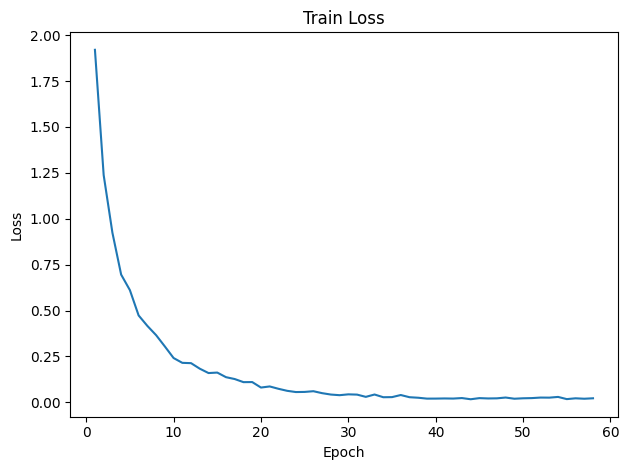

<Figure size 640x480 with 0 Axes>

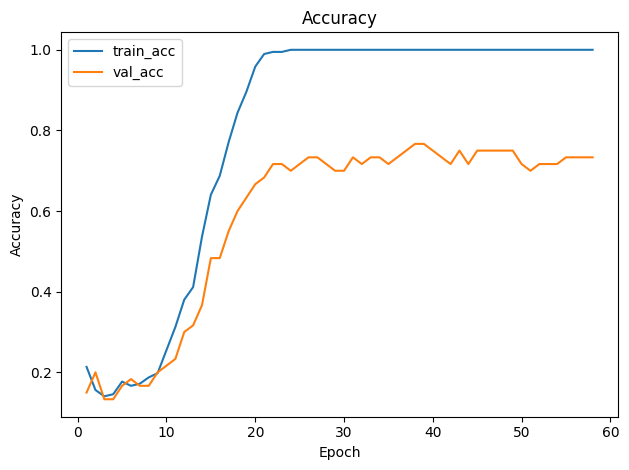

<Figure size 640x480 with 0 Axes>

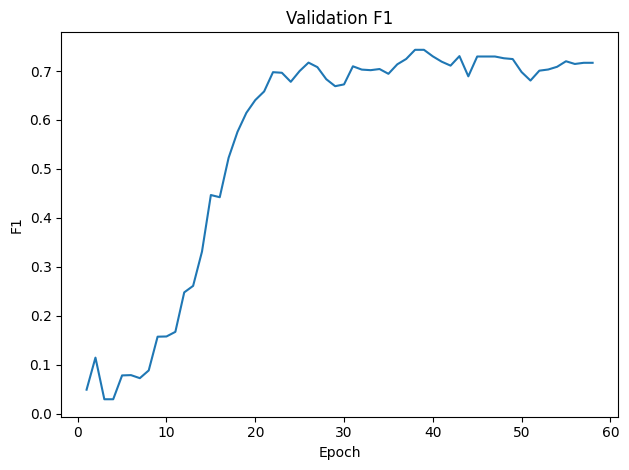

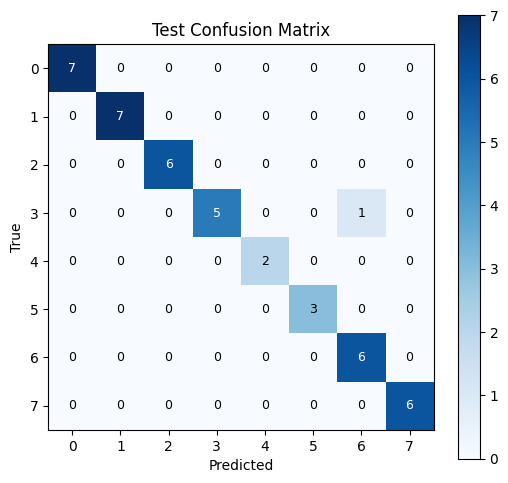

[Fold1] Best val acc=0.767 @ ep38 | Test acc=0.977, prec=0.982, rec=0.979, F1=0.979

Model 3 (Dilated TCN) | Fold 2
[Fold2] Ep001 tr_loss=1.9850 tr_acc=0.177 val_acc=0.207 val_f1=0.080 | best=0.207@1
[Fold2] Ep005 tr_loss=0.5428 tr_acc=0.156 val_acc=0.172 val_f1=0.107 | best=0.207@1
[Fold2] Ep010 tr_loss=0.2725 tr_acc=0.255 val_acc=0.224 val_f1=0.131 | best=0.224@10
[Fold2] Ep015 tr_loss=0.1717 tr_acc=0.651 val_acc=0.534 val_f1=0.528 | best=0.534@15
[Fold2] Ep020 tr_loss=0.0878 tr_acc=0.990 val_acc=0.741 val_f1=0.711 | best=0.741@18
[Fold2] Ep025 tr_loss=0.0557 tr_acc=1.000 val_acc=0.828 val_f1=0.813 | best=0.828@24
[Fold2] Ep030 tr_loss=0.0316 tr_acc=1.000 val_acc=0.741 val_f1=0.670 | best=0.828@24
[Fold2] Ep035 tr_loss=0.0332 tr_acc=1.000 val_acc=0.776 val_f1=0.741 | best=0.828@24
[Fold2] Ep040 tr_loss=0.0259 tr_acc=1.000 val_acc=0.776 val_f1=0.743 | best=0.828@24
[Fold2] Early stopping at epoch 44 (no val improvement for 20 epochs)


<Figure size 640x480 with 0 Axes>

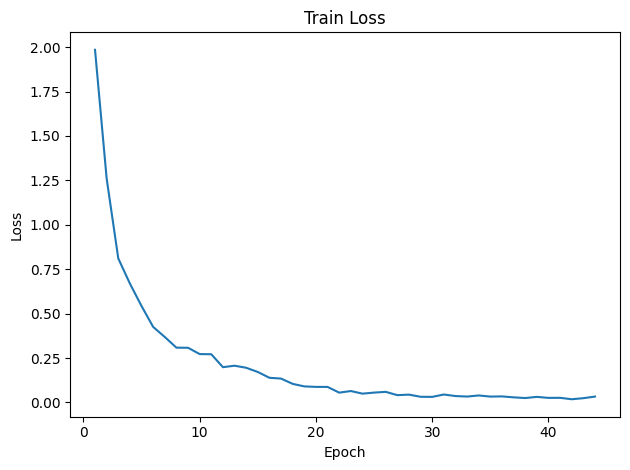

<Figure size 640x480 with 0 Axes>

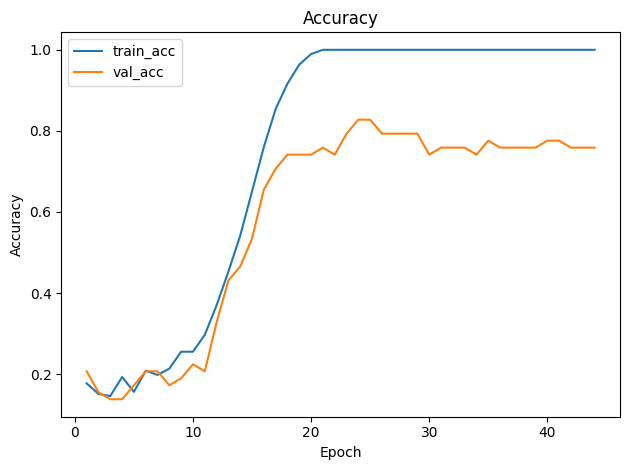

<Figure size 640x480 with 0 Axes>

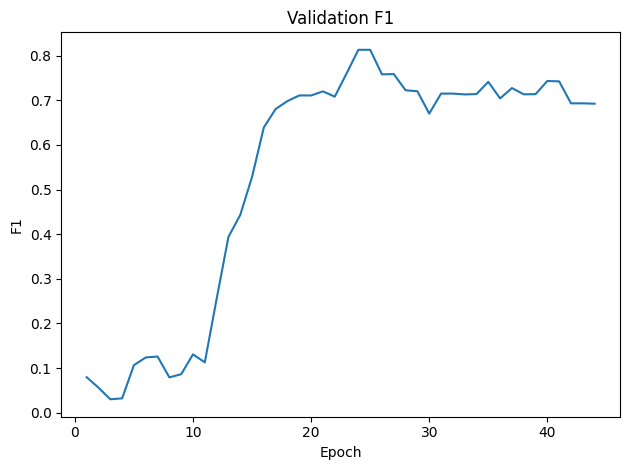

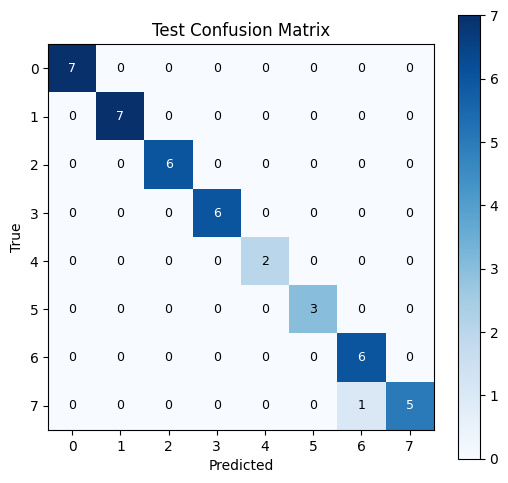

[Fold2] Best val acc=0.828 @ ep24 | Test acc=0.977, prec=0.982, rec=0.979, F1=0.979

Model 3 (Dilated TCN) | Fold 3
[Fold3] Ep001 tr_loss=1.8916 tr_acc=0.203 val_acc=0.263 val_f1=0.172 | best=0.263@1
[Fold3] Ep005 tr_loss=0.5274 tr_acc=0.135 val_acc=0.140 val_f1=0.035 | best=0.263@1
[Fold3] Ep010 tr_loss=0.2459 tr_acc=0.260 val_acc=0.333 val_f1=0.279 | best=0.333@10
[Fold3] Ep015 tr_loss=0.1184 tr_acc=0.672 val_acc=0.526 val_f1=0.480 | best=0.526@15
[Fold3] Ep020 tr_loss=0.0813 tr_acc=0.979 val_acc=0.667 val_f1=0.647 | best=0.667@18
[Fold3] Ep025 tr_loss=0.0483 tr_acc=1.000 val_acc=0.737 val_f1=0.700 | best=0.737@25
[Fold3] Ep030 tr_loss=0.0429 tr_acc=1.000 val_acc=0.754 val_f1=0.720 | best=0.754@26
[Fold3] Ep035 tr_loss=0.0478 tr_acc=1.000 val_acc=0.737 val_f1=0.704 | best=0.754@26
[Fold3] Ep040 tr_loss=0.0292 tr_acc=1.000 val_acc=0.737 val_f1=0.695 | best=0.754@26
[Fold3] Ep045 tr_loss=0.0268 tr_acc=1.000 val_acc=0.737 val_f1=0.697 | best=0.754@26
[Fold3] Early stopping at epoch 46 (

<Figure size 640x480 with 0 Axes>

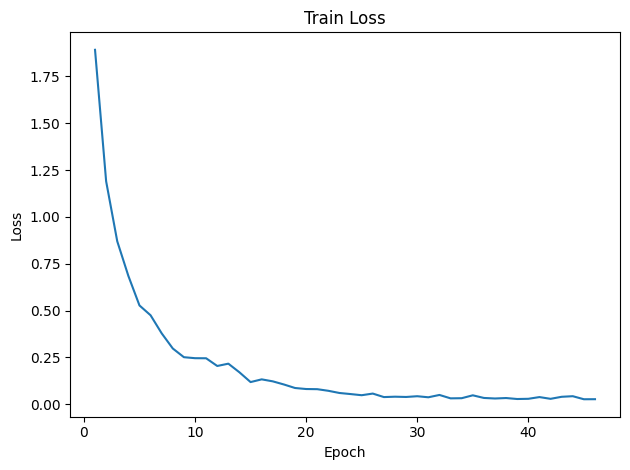

<Figure size 640x480 with 0 Axes>

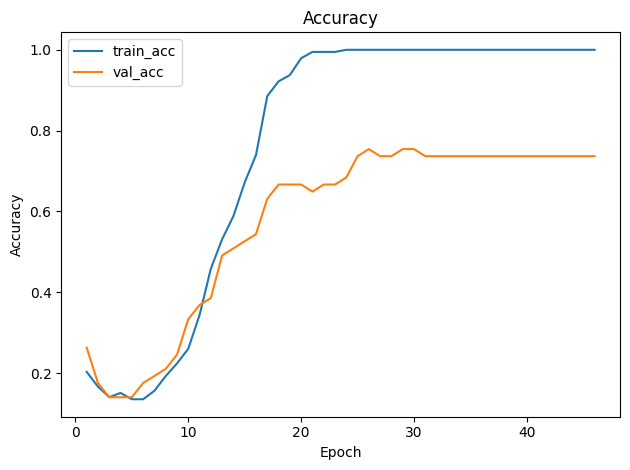

<Figure size 640x480 with 0 Axes>

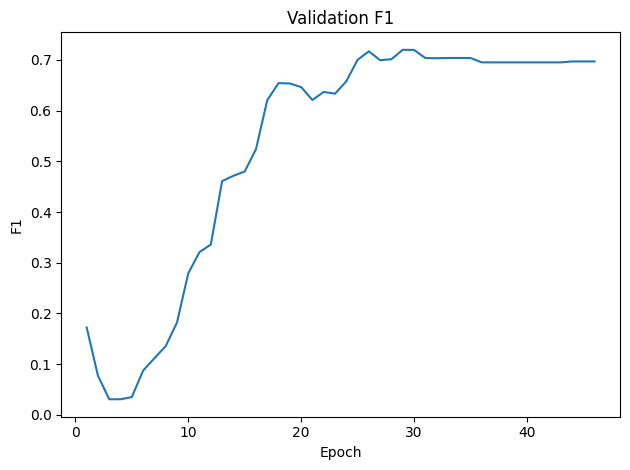

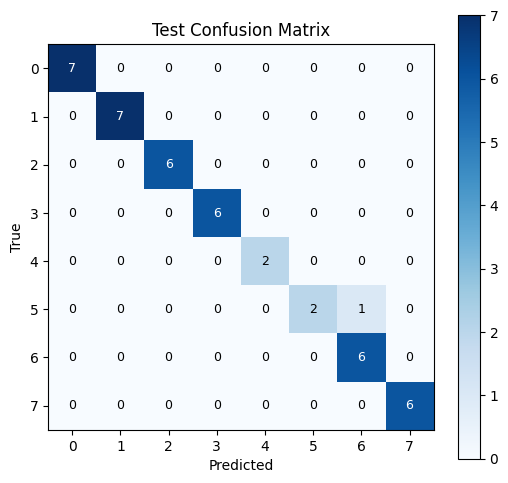

[Fold3] Best val acc=0.754 @ ep26 | Test acc=0.977, prec=0.982, rec=0.958, F1=0.965

Model 3 (Dilated TCN) | Fold 4
[Fold4] Ep001 tr_loss=1.9633 tr_acc=0.161 val_acc=0.167 val_f1=0.061 | best=0.167@1
[Fold4] Ep005 tr_loss=0.5830 tr_acc=0.141 val_acc=0.167 val_f1=0.095 | best=0.259@2
[Fold4] Ep010 tr_loss=0.2666 tr_acc=0.286 val_acc=0.278 val_f1=0.204 | best=0.278@10
[Fold4] Ep015 tr_loss=0.1729 tr_acc=0.693 val_acc=0.593 val_f1=0.510 | best=0.593@15
[Fold4] Ep020 tr_loss=0.0988 tr_acc=0.974 val_acc=0.796 val_f1=0.711 | best=0.796@20
[Fold4] Ep025 tr_loss=0.0503 tr_acc=1.000 val_acc=0.815 val_f1=0.746 | best=0.815@23
[Fold4] Ep030 tr_loss=0.0337 tr_acc=1.000 val_acc=0.833 val_f1=0.759 | best=0.852@27
[Fold4] Ep035 tr_loss=0.0235 tr_acc=1.000 val_acc=0.815 val_f1=0.746 | best=0.852@27
[Fold4] Ep040 tr_loss=0.0275 tr_acc=1.000 val_acc=0.833 val_f1=0.759 | best=0.870@38
[Fold4] Ep045 tr_loss=0.0234 tr_acc=1.000 val_acc=0.833 val_f1=0.770 | best=0.870@38
[Fold4] Ep050 tr_loss=0.0244 tr_acc=

<Figure size 640x480 with 0 Axes>

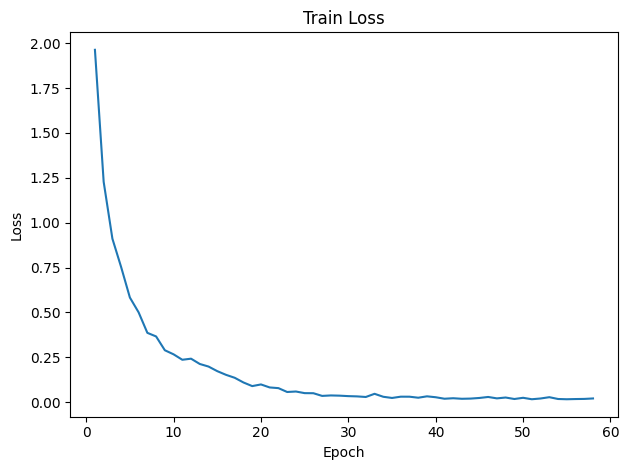

<Figure size 640x480 with 0 Axes>

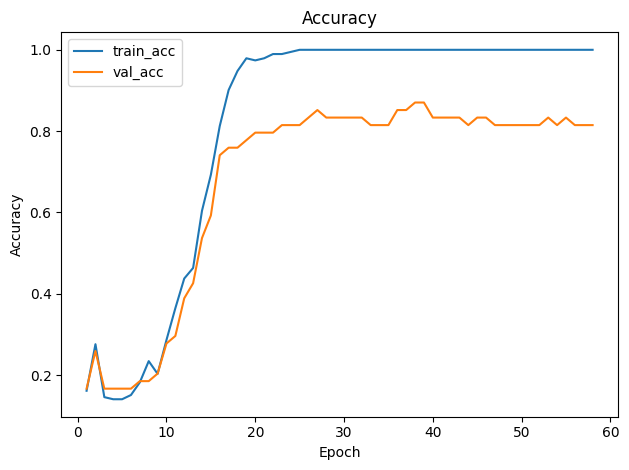

<Figure size 640x480 with 0 Axes>

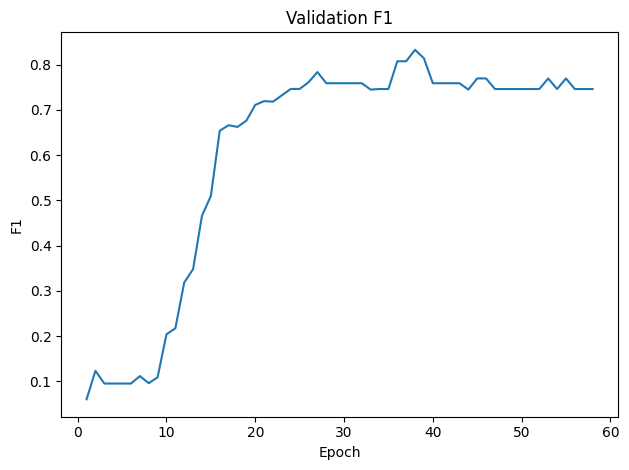

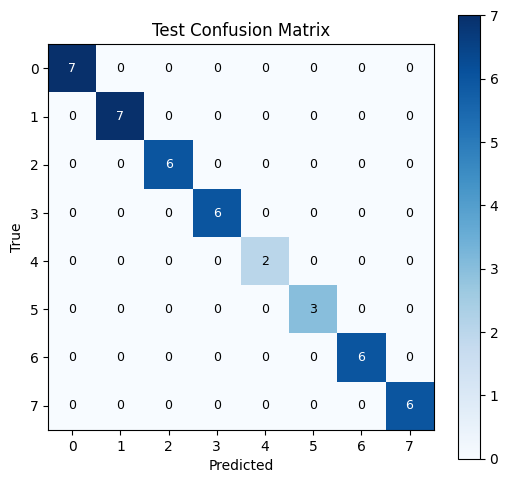

[Fold4] Best val acc=0.870 @ ep38 | Test acc=1.000, prec=1.000, rec=1.000, F1=1.000

Model 3 (Dilated TCN) | Fold 5
[Fold5] Ep001 tr_loss=2.1250 tr_acc=0.177 val_acc=0.151 val_f1=0.050 | best=0.151@1
[Fold5] Ep005 tr_loss=0.6141 tr_acc=0.156 val_acc=0.170 val_f1=0.094 | best=0.189@2
[Fold5] Ep010 tr_loss=0.3345 tr_acc=0.297 val_acc=0.264 val_f1=0.220 | best=0.264@10
[Fold5] Ep015 tr_loss=0.1893 tr_acc=0.630 val_acc=0.491 val_f1=0.490 | best=0.491@15
[Fold5] Ep020 tr_loss=0.1116 tr_acc=0.958 val_acc=0.736 val_f1=0.721 | best=0.736@20
[Fold5] Ep025 tr_loss=0.0596 tr_acc=1.000 val_acc=0.698 val_f1=0.687 | best=0.774@22
[Fold5] Ep030 tr_loss=0.0425 tr_acc=1.000 val_acc=0.755 val_f1=0.729 | best=0.774@22
[Fold5] Ep035 tr_loss=0.0379 tr_acc=1.000 val_acc=0.755 val_f1=0.729 | best=0.774@22
[Fold5] Ep040 tr_loss=0.0392 tr_acc=1.000 val_acc=0.717 val_f1=0.700 | best=0.774@22
[Fold5] Early stopping at epoch 42 (no val improvement for 20 epochs)


<Figure size 640x480 with 0 Axes>

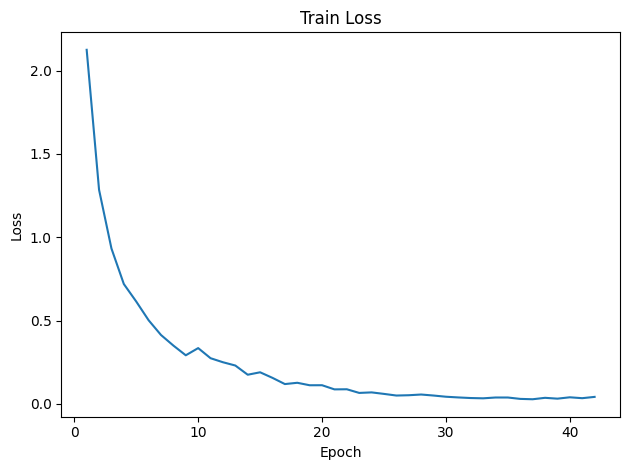

<Figure size 640x480 with 0 Axes>

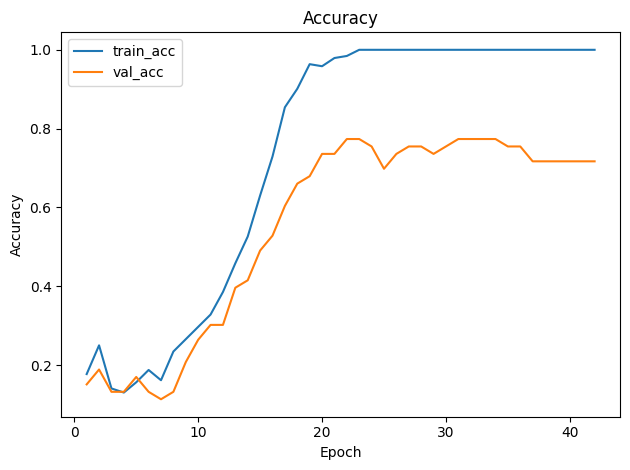

<Figure size 640x480 with 0 Axes>

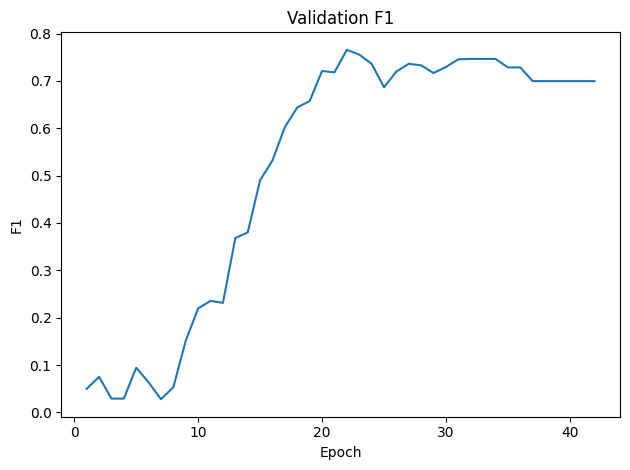

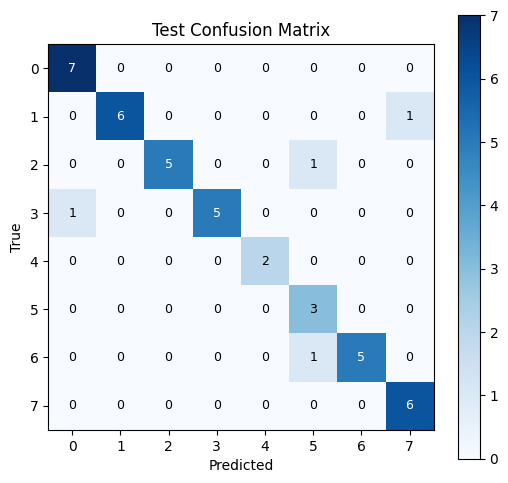

[Fold5] Best val acc=0.774 @ ep22 | Test acc=0.907, prec=0.917, rec=0.920, F1=0.907
Summary saved: /content/drive/MyDrive/ml_runs/sbu_models/Model_3_Original_DilatedTCN/outputs/summary.csv
       Best Val Acc  Best Epoch  Test Acc  Test Precision (macro)  \
Fold1      0.766667        38.0  0.976744                0.982143   
Fold2      0.827586        24.0  0.976744                0.982143   
Fold3      0.754386        26.0  0.976744                0.982143   
Fold4      0.870370        38.0  1.000000                1.000000   
Fold5      0.773585        22.0  0.906977                0.916518   
Mean       0.798519        29.6  0.967442                0.972589   

       Test Recall (macro)  Test F1 (macro)  Test Precision (weighted)  \
Fold1             0.979167         0.979021                   0.980066   
Fold2             0.979167         0.979021                   0.980066   
Fold3             0.958333         0.965385                   0.980066   
Fold4             1.000000     

In [ ]:
# /content/drive/MyDrive/ml_runs/sbu_models/Model_3_Original_DilatedTCN/train.py

import os, json, pickle, random
from pathlib import Path
from typing import Any, Dict, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATA_ROOT = Path("/content/drive/MyDrive/ml_runs/sbu_hybrid_colab/data/sbu")
WORK_ROOT = Path("/content/drive/MyDrive/ml_runs/sbu_models/Model_3_Original_DilatedTCN/outputs")
WORK_ROOT.mkdir(parents=True, exist_ok=True)

EPOCHS       = 200
PATIENCE     = 20
BATCH_SIZE   = 64
LR           = 1e-3
WEIGHT_DECAY = 0.0
NUM_WORKERS  = 2
PIN_MEMORY   = torch.cuda.is_available()
DROPOUT      = 0.25

with open(WORK_ROOT/"hyperparams.json","w") as f:
    json.dump({
        "epochs":EPOCHS,"patience":PATIENCE,"batch_size":BATCH_SIZE,
        "lr":LR,"weight_decay":WEIGHT_DECAY,"num_workers":NUM_WORKERS,
        "dropout":DROPOUT
    }, f, indent=2)

def fold_paths(k:int)->Dict[str, Path]:
    d = DATA_ROOT / f"fold{k}"
    return {
        "train_x": d/"train_data.npy", "train_y": d/"train_label.pkl",
        "val_x":   d/"val_data.npy",   "val_y":   d/"val_label.pkl",
        "test_x":  d/"test_data.npy",  "test_y":  d/"test_label.pkl"
    }

def _first_int(x: Any):
    if isinstance(x, (int, np.integer)): return int(x)
    if isinstance(x, str):
        import re
        m = re.search(r"-?\d+", x)
        if m: return int(m.group(0))
        return None
    return None

def _to_int_list(seq: Any) -> List[int]:
    if isinstance(seq, np.ndarray):
        if seq.dtype.kind in "iu":
            return seq.astype(np.int64).tolist()
        seq = seq.tolist()
    if isinstance(seq, (list, tuple)):
        out = []
        for it in seq:
            v = _first_int(it)
            if v is None:
                raise ValueError(f"Label element not int-like: {repr(it)[:120]}")
            out.append(v)
        return out
    raise ValueError(f"Unsupported label container: {type(seq).__name__}")

def load_labels(y_path: Path, expected_N: int) -> np.ndarray:
    with open(y_path, "rb") as f:
        obj = pickle.load(f)

    if isinstance(obj, np.ndarray) and obj.ndim == 1 and obj.size == expected_N and obj.dtype.kind in "iu":
        y = obj.astype(np.int64)
    elif isinstance(obj, (list, tuple)) and len(obj) == expected_N and all(isinstance(e, (int, np.integer)) for e in obj):
        y = np.asarray(obj, dtype=np.int64)
    elif isinstance(obj, (list, tuple)) and len(obj) == 2:
        cand = obj[0]
        if isinstance(cand, (list, tuple, np.ndarray)):
            labels = _to_int_list(cand)
            if len(labels) != expected_N:
                raise ValueError(f"First element length {len(labels)} != N {expected_N} in {y_path}")
            y = np.asarray(labels, dtype=np.int64)
        else:
            raise ValueError(f"First element not list-like in {y_path}: {type(cand).__name__}")
    elif isinstance(obj, dict):
        for k in ["labels","y","targets"]:
            if k in obj:
                labels = _to_int_list(obj[k])
                if len(labels) != expected_N:
                    raise ValueError(f"dict['{k}'] length {len(labels)} != N {expected_N}")
                y = np.asarray(labels, dtype=np.int64)
                break
        else:
            raise ValueError(f"Unsupported dict label format keys={list(obj.keys())[:10]}")
    else:
        raise ValueError(f"Unsupported label.pkl type: {type(obj).__name__}")

    uniq = np.unique(y)
    if not np.array_equal(uniq, np.arange(int(uniq.max())+1)):
        mapping = {int(c):i for i,c in enumerate(sorted(uniq))}
        y = np.vectorize(lambda z: mapping[int(z)])(y).astype(np.int64)
    return y

class SBUFoldDataset(torch.utils.data.Dataset):
    def __init__(self, x_path: Path, y_path: Path):
        self.x = np.load(x_path)  # [N,C,T,V,M] or [N,C,T,V]
        N = self.x.shape[0]
        y = load_labels(y_path, expected_N=N)
        if len(y) != N:
            raise ValueError(f"N mismatch for {x_path.name}: X={N} y={len(y)}")
        self.y = y
        if self.x.ndim == 4:  # [N,C,T,V] -> add M=1
            self.x = self.x[..., None]
    def __len__(self): return self.x.shape[0]
    def __getitem__(self, idx):
        return torch.from_numpy(self.x[idx]).float(), int(self.y[idx])

class DilatedBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel=3, dilation=1, dropout=0.0):
        super().__init__()
        pad = (kernel - 1) * dilation // 2
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size=kernel, dilation=dilation, padding=pad)
        self.bn   = nn.BatchNorm1d(out_ch)
        self.drop = nn.Dropout(dropout)
        self.proj = nn.Conv1d(in_ch, out_ch, kernel_size=1) if in_ch != out_ch else nn.Identity()
    def forward(self, x):
        y = self.drop(F.relu(self.bn(self.conv(x))))
        return y + self.proj(x)

class DilatedTCN(nn.Module):
    def __init__(self, in_ch_per_joint=2, num_joints=15, num_class=8, dropout=0.25):
        super().__init__()
        in_ch = in_ch_per_joint * num_joints
        self.t1 = DilatedBlock(in_ch,   128, kernel=3, dilation=1, dropout=dropout)
        self.t2 = DilatedBlock(128,     256, kernel=3, dilation=2, dropout=dropout)
        self.t3 = DilatedBlock(256,     256, kernel=3, dilation=4, dropout=dropout)
        self.t4 = DilatedBlock(256,     256, kernel=3, dilation=8, dropout=dropout)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc   = nn.Linear(256, num_class)

    def forward(self, x):  # x: [N,C,T,V,M]
        x = x.mean(dim=-1)            # [N,C,T,V]
        N,C,T,V = x.shape
        x = x.permute(0,1,3,2).contiguous().view(N, C*V, T)  # [N, C*V, T]
        x = self.t1(x); x = self.t2(x); x = self.t3(x); x = self.t4(x)
        x = self.pool(x).squeeze(-1)  # [N, 256]
        return self.fc(x)

@torch.no_grad()
def eval_loader(model, loader):
    model.eval()
    all_t, all_p = [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        out = model(xb)
        pred = out.argmax(1)
        all_t.extend(yb.cpu().numpy().tolist())
        all_p.extend(pred.cpu().numpy().tolist())
    acc   = accuracy_score(all_t, all_p)
    prec  = precision_score(all_t, all_p, average="macro",    zero_division=0)
    rec   = recall_score(all_t, all_p, average="macro",       zero_division=0)
    f1    = f1_score(all_t, all_p, average="macro",           zero_division=0)
    precw = precision_score(all_t, all_p, average="weighted", zero_division=0)
    recw  = recall_score(all_t, all_p, average="weighted",    zero_division=0)
    f1w   = f1_score(all_t, all_p, average="weighted",        zero_division=0)
    cm    = confusion_matrix(all_t, all_p)
    rep   = classification_report(all_t, all_p, output_dict=True, zero_division=0)
    return {
        "acc":acc, "prec":prec, "rec":rec, "f1":f1,
        "prec_w":precw, "rec_w":recw, "f1_w":f1w,
        "cm":cm, "rep":rep
    }

def plot_curves(history, out_dir: Path):
    df = pd.DataFrame(history)
    out_dir.mkdir(parents=True, exist_ok=True)

    plt.figure()
    df[["epoch","train_loss"]].set_index("epoch").plot(legend=False)
    plt.title("Train Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.tight_layout(); plt.savefig(out_dir/"loss.png", dpi=150); plt.show()

    plt.figure()
    df[["epoch","train_acc","val_acc"]].set_index("epoch").plot()
    plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.tight_layout(); plt.savefig(out_dir/"val_acc.png", dpi=150); plt.show()

    plt.figure()
    df[["epoch","val_f1"]].set_index("epoch").plot(legend=False)
    plt.title("Validation F1"); plt.xlabel("Epoch"); plt.ylabel("F1")
    plt.tight_layout(); plt.savefig(out_dir/"val_f1.png", dpi=150); plt.show()

def plot_confusion(cm: np.ndarray, out_path: Path, title="Confusion Matrix"):
    plt.figure(figsize=(5.5,5))
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title); plt.colorbar()
    ticks = np.arange(cm.shape[0])
    plt.xticks(ticks, ticks); plt.yticks(ticks, ticks)
    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            plt.text(j, i, str(val), ha="center", va="center",
                     color="white" if val > thresh else "black", fontsize=9)
    plt.ylabel("True"); plt.xlabel("Predicted")
    plt.tight_layout(); plt.savefig(out_path, dpi=150); plt.show()

def train_fold(k:int, epochs=EPOCHS, patience=PATIENCE, batch_size=BATCH_SIZE, lr=LR):
    paths = fold_paths(k)
    out_dir = WORK_ROOT/f"fold{k}"; out_dir.mkdir(parents=True, exist_ok=True)

    tr_ds = SBUFoldDataset(paths["train_x"], paths["train_y"])
    va_ds = SBUFoldDataset(paths["val_x"], paths["val_y"])
    te_ds = SBUFoldDataset(paths["test_x"], paths["test_y"])

    tr_ld = DataLoader(tr_ds, batch_size=batch_size, shuffle=True,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=True)
    va_ld = DataLoader(va_ds, batch_size=batch_size, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    te_ld = DataLoader(te_ds, batch_size=batch_size, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    C = tr_ds.x.shape[1]
    V = tr_ds.x.shape[3]
    num_class = int(max(tr_ds.y.max(), va_ds.y.max(), te_ds.y.max()) + 1)

    model = DilatedTCN(in_ch_per_joint=C, num_joints=V, num_class=num_class, dropout=DROPOUT).to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", patience=4, factor=0.5)

    best_val, best_ep, no_improve = -1.0, -1, 0
    history = []
    best_path = out_dir/"best.pt"

    for ep in range(1, epochs+1):
        model.train()
        n, loss_sum = 0, 0.0
        for xb, yb in tr_ld:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            out = model(xb)
            loss = F.cross_entropy(out, yb)
            loss.backward()
            opt.step()
            loss_sum += loss.item() * yb.size(0)
            n += yb.size(0)

        tr_loss = loss_sum / max(1, n)
        tr_eval = eval_loader(model, tr_ld)
        va_eval = eval_loader(model, va_ld)

        history.append({
            "epoch":ep, "train_loss":tr_loss,
            "train_acc":tr_eval["acc"], "val_acc":va_eval["acc"], "val_f1":va_eval["f1"]
        })

        sched.step(va_eval["acc"])
        if va_eval["acc"] > best_val + 1e-8:
            best_val = va_eval["acc"]
            best_ep = ep
            no_improve = 0
            torch.save({"model": model.state_dict()}, best_path)
            np.savetxt(out_dir/"cm_val_best.csv", va_eval["cm"].astype(int), fmt="%d", delimiter=",")
            pd.DataFrame(va_eval["rep"]).to_csv(out_dir/"report_val_best.csv")
            with open(out_dir/"best.json","w") as f:
                json.dump({"best_epoch": int(best_ep), "best_val_acc": float(best_val)}, f, indent=2)
        else:
            no_improve += 1

        if ep == 1 or ep % 5 == 0:
            pd.DataFrame(history).to_csv(out_dir/"history.csv", index=False)
            print(f"[Fold{k}] Ep{ep:03d} tr_loss={tr_loss:.4f} tr_acc={tr_eval['acc']:.3f} "
                  f"val_acc={va_eval['acc']:.3f} val_f1={va_eval['f1']:.3f} | best={best_val:.3f}@{best_ep}")

        if no_improve >= patience:
            print(f"[Fold{k}] Early stopping at epoch {ep} (no val improvement for {patience} epochs)")
            break

    pd.DataFrame(history).to_csv(out_dir/"history.csv", index=False)
    plot_curves(history, out_dir)

    state = torch.load(best_path, map_location="cpu")
    model.load_state_dict(state["model"])

    te = eval_loader(model, te_ld)
    np.savetxt(out_dir/"cm_test.csv", te["cm"].astype(int), fmt="%d", delimiter=",")
    pd.DataFrame(te["rep"]).to_csv(out_dir/"report_test.csv")
    with open(out_dir/"results.json","w") as f:
        json.dump({
            "best_val_acc": float(best_val), "best_epoch": int(best_ep),
            "test_acc": float(te["acc"]),
            "test_precision_macro": float(te["prec"]),
            "test_recall_macro": float(te["rec"]),
            "test_f1_macro": float(te["f1"]),
            "test_precision_weighted": float(te["prec_w"]),
            "test_recall_weighted": float(te["rec_w"]),
            "test_f1_weighted": float(te["f1_w"])
        }, f, indent=2)

    plot_confusion(te["cm"], out_dir/"cm_test.png", title="Test Confusion Matrix")

    print(f"[Fold{k}] Best val acc={best_val:.3f} @ ep{best_ep} | "
          f"Test acc={te['acc']:.3f}, prec={te['prec']:.3f}, rec={te['rec']:.3f}, F1={te['f1']:.3f}")

    return {
        "best_val_acc": best_val,
        "best_epoch": best_ep,
        "test_acc": te["acc"],
        "test_precision_macro": te["prec"],
        "test_recall_macro": te["rec"],
        "test_f1_macro": te["f1"],
        "test_precision_weighted": te["prec_w"],
        "test_recall_weighted": te["rec_w"],
        "test_f1_weighted": te["f1_w"]
    }

def run_all():
    rows = []
    for k in range(1,6):
        print(f"\nModel 3 (Dilated TCN) | Fold {k}")
        r = train_fold(k)
        rows.append([
            r["best_val_acc"], r["best_epoch"], r["test_acc"],
            r["test_precision_macro"], r["test_recall_macro"], r["test_f1_macro"],
            r["test_precision_weighted"], r["test_recall_weighted"], r["test_f1_weighted"]
        ])
    cols = [
        "Best Val Acc","Best Epoch","Test Acc",
        "Test Precision (macro)","Test Recall (macro)","Test F1 (macro)",
        "Test Precision (weighted)","Test Recall (weighted)","Test F1 (weighted)"
    ]
    df = pd.DataFrame(rows, columns=cols, index=[f"Fold{i}" for i in range(1,6)])
    df.loc["Mean"] = df.mean(numeric_only=True).to_dict()
    df.to_csv(WORK_ROOT/"summary.csv", index=True)
    print("Summary saved:", WORK_ROOT/"summary.csv")
    print(df)

if __name__ == "__main__":
    run_all()



Model 4 (SE) | Fold 1
[Fold1] Ep001 tr_loss=2.0581 tr_acc=0.156 val_acc=0.150 val_f1=0.033 | best=0.150@1
[Fold1] Ep005 tr_loss=1.7763 tr_acc=0.250 val_acc=0.183 val_f1=0.071 | best=0.283@4
[Fold1] Ep010 tr_loss=1.5782 tr_acc=0.411 val_acc=0.283 val_f1=0.234 | best=0.283@4
[Fold1] Ep015 tr_loss=1.5226 tr_acc=0.484 val_acc=0.350 val_f1=0.328 | best=0.400@12
[Fold1] Ep020 tr_loss=1.4098 tr_acc=0.542 val_acc=0.400 val_f1=0.370 | best=0.417@17
[Fold1] Ep025 tr_loss=1.3201 tr_acc=0.552 val_acc=0.433 val_f1=0.401 | best=0.433@25
[Fold1] Ep030 tr_loss=1.3353 tr_acc=0.526 val_acc=0.433 val_f1=0.399 | best=0.450@26
[Fold1] Ep035 tr_loss=1.2688 tr_acc=0.568 val_acc=0.467 val_f1=0.427 | best=0.467@35
[Fold1] Ep040 tr_loss=1.2493 tr_acc=0.594 val_acc=0.500 val_f1=0.470 | best=0.500@39
[Fold1] Ep045 tr_loss=1.2785 tr_acc=0.609 val_acc=0.450 val_f1=0.416 | best=0.500@39
[Fold1] Ep050 tr_loss=1.2073 tr_acc=0.615 val_acc=0.433 val_f1=0.398 | best=0.500@39
[Fold1] Ep055 tr_loss=1.2326 tr_acc=0.594 val

<Figure size 640x480 with 0 Axes>

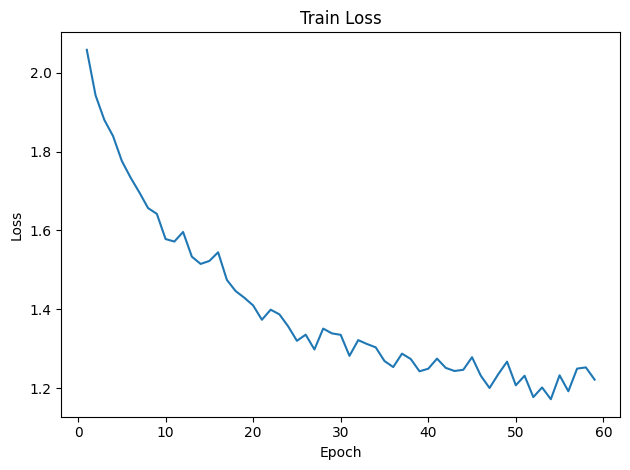

<Figure size 640x480 with 0 Axes>

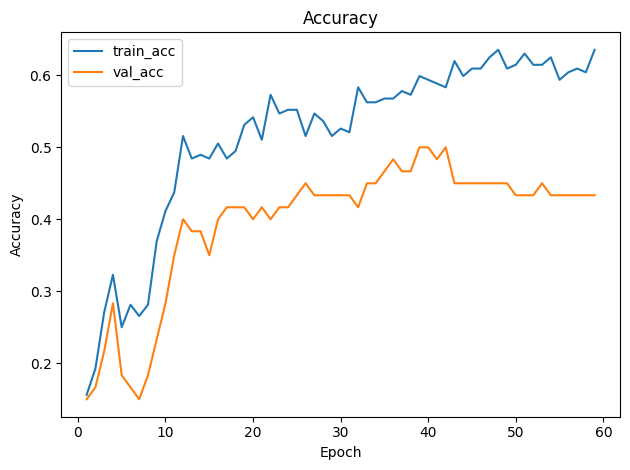

<Figure size 640x480 with 0 Axes>

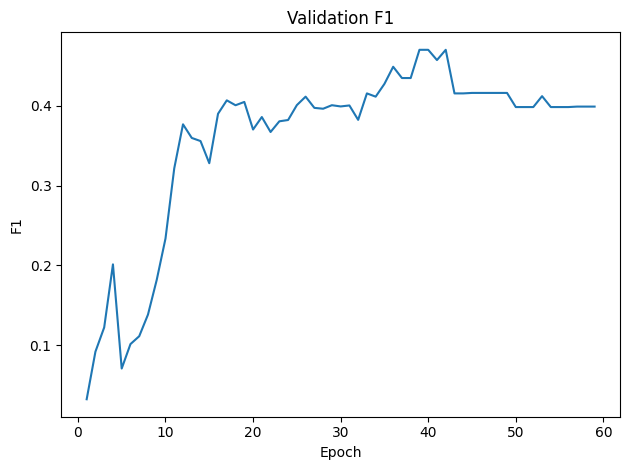

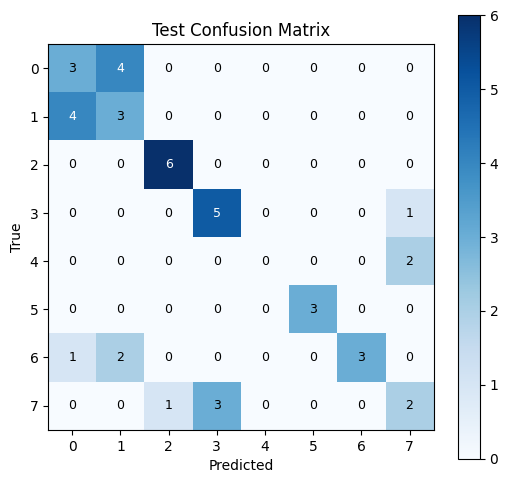

[Fold1] Best val acc=0.500 @ ep39 | Test acc=0.581, prec=0.574, rec=0.565, F1=0.555

Model 4 (SE) | Fold 2
[Fold2] Ep001 tr_loss=2.0730 tr_acc=0.177 val_acc=0.190 val_f1=0.078 | best=0.190@1
[Fold2] Ep005 tr_loss=1.7657 tr_acc=0.141 val_acc=0.155 val_f1=0.059 | best=0.190@1
[Fold2] Ep010 tr_loss=1.6326 tr_acc=0.443 val_acc=0.414 val_f1=0.356 | best=0.414@10
[Fold2] Ep015 tr_loss=1.5471 tr_acc=0.562 val_acc=0.414 val_f1=0.375 | best=0.414@10
[Fold2] Ep020 tr_loss=1.4623 tr_acc=0.620 val_acc=0.483 val_f1=0.428 | best=0.483@20
[Fold2] Ep025 tr_loss=1.4161 tr_acc=0.599 val_acc=0.448 val_f1=0.391 | best=0.517@21
[Fold2] Ep030 tr_loss=1.4285 tr_acc=0.651 val_acc=0.517 val_f1=0.466 | best=0.517@21
[Fold2] Ep035 tr_loss=1.3977 tr_acc=0.646 val_acc=0.517 val_f1=0.463 | best=0.517@21
[Fold2] Ep040 tr_loss=1.3885 tr_acc=0.661 val_acc=0.534 val_f1=0.482 | best=0.534@36
[Fold2] Ep045 tr_loss=1.3393 tr_acc=0.630 val_acc=0.517 val_f1=0.468 | best=0.534@36
[Fold2] Ep050 tr_loss=1.3247 tr_acc=0.667 val

<Figure size 640x480 with 0 Axes>

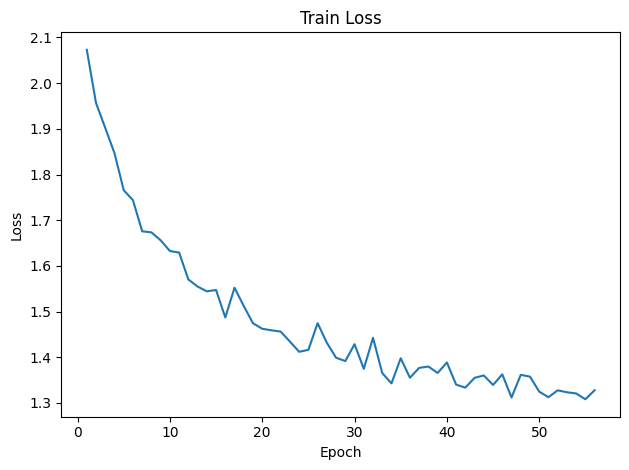

<Figure size 640x480 with 0 Axes>

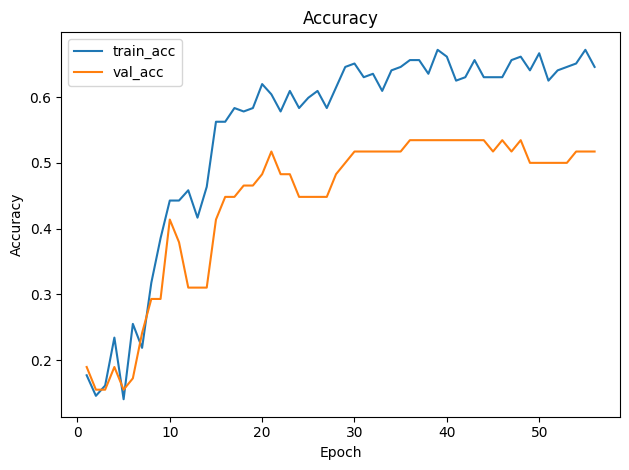

<Figure size 640x480 with 0 Axes>

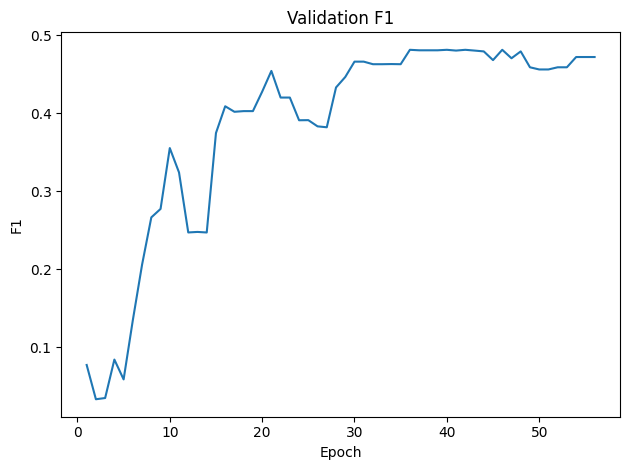

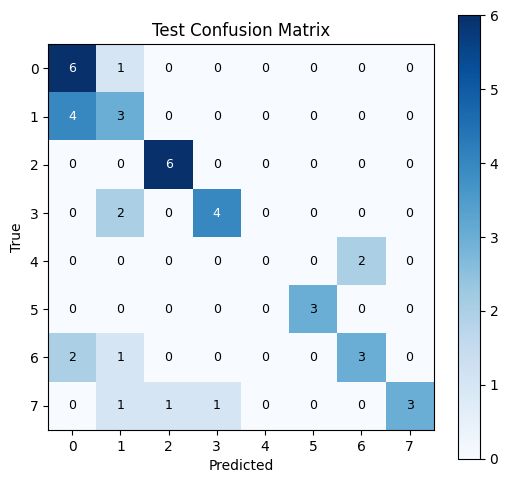

[Fold2] Best val acc=0.534 @ ep36 | Test acc=0.651, prec=0.642, rec=0.619, F1=0.612

Model 4 (SE) | Fold 3
[Fold3] Ep001 tr_loss=2.0586 tr_acc=0.146 val_acc=0.140 val_f1=0.051 | best=0.140@1
[Fold3] Ep005 tr_loss=1.7874 tr_acc=0.161 val_acc=0.158 val_f1=0.113 | best=0.211@3
[Fold3] Ep010 tr_loss=1.6057 tr_acc=0.365 val_acc=0.316 val_f1=0.233 | best=0.316@9
[Fold3] Ep015 tr_loss=1.4344 tr_acc=0.479 val_acc=0.439 val_f1=0.392 | best=0.439@15
[Fold3] Ep020 tr_loss=1.2581 tr_acc=0.568 val_acc=0.509 val_f1=0.475 | best=0.544@19
[Fold3] Ep025 tr_loss=1.1252 tr_acc=0.557 val_acc=0.439 val_f1=0.403 | best=0.544@19
[Fold3] Ep030 tr_loss=1.1040 tr_acc=0.682 val_acc=0.561 val_f1=0.523 | best=0.561@28
[Fold3] Ep035 tr_loss=0.9913 tr_acc=0.724 val_acc=0.596 val_f1=0.604 | best=0.596@32
[Fold3] Ep040 tr_loss=0.9465 tr_acc=0.745 val_acc=0.579 val_f1=0.584 | best=0.614@37
[Fold3] Ep045 tr_loss=0.9326 tr_acc=0.740 val_acc=0.561 val_f1=0.563 | best=0.632@41
[Fold3] Ep050 tr_loss=0.9235 tr_acc=0.760 val_

<Figure size 640x480 with 0 Axes>

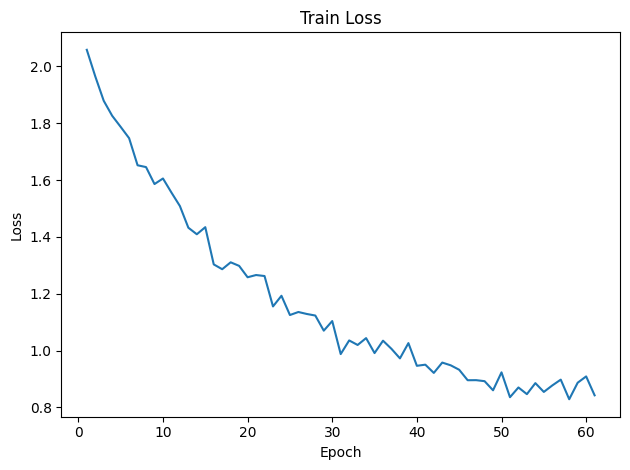

<Figure size 640x480 with 0 Axes>

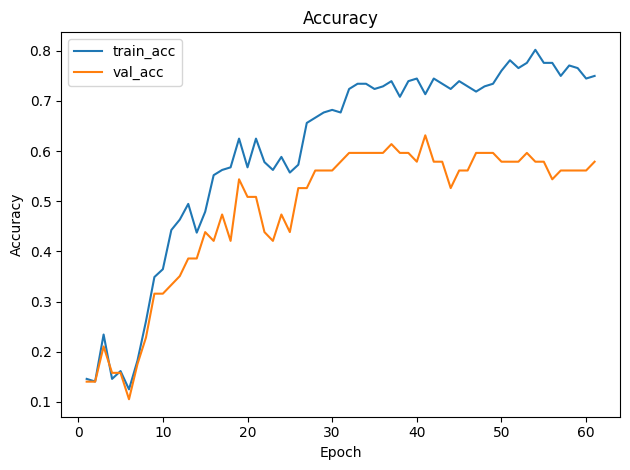

<Figure size 640x480 with 0 Axes>

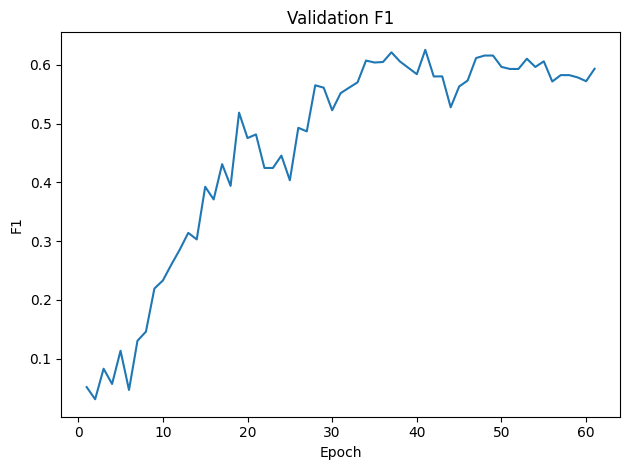

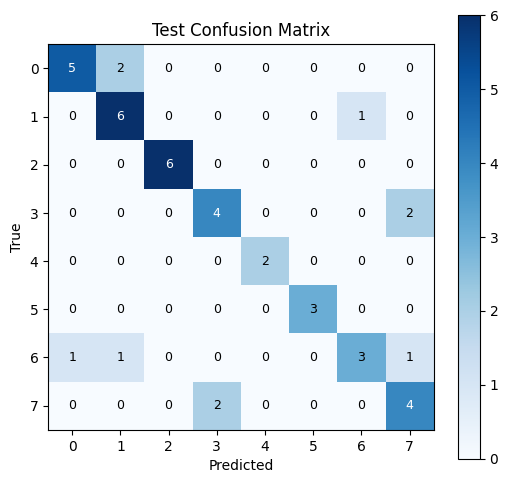

[Fold3] Best val acc=0.632 @ ep41 | Test acc=0.767, prec=0.811, rec=0.801, F1=0.800

Model 4 (SE) | Fold 4
[Fold4] Ep001 tr_loss=2.0648 tr_acc=0.156 val_acc=0.148 val_f1=0.032 | best=0.148@1
[Fold4] Ep005 tr_loss=1.7942 tr_acc=0.354 val_acc=0.222 val_f1=0.173 | best=0.259@2
[Fold4] Ep010 tr_loss=1.6090 tr_acc=0.417 val_acc=0.352 val_f1=0.320 | best=0.352@7
[Fold4] Ep015 tr_loss=1.4262 tr_acc=0.552 val_acc=0.426 val_f1=0.399 | best=0.426@14
[Fold4] Ep020 tr_loss=1.3228 tr_acc=0.562 val_acc=0.463 val_f1=0.408 | best=0.481@19
[Fold4] Ep025 tr_loss=1.1733 tr_acc=0.677 val_acc=0.519 val_f1=0.505 | best=0.519@25
[Fold4] Ep030 tr_loss=1.0548 tr_acc=0.688 val_acc=0.630 val_f1=0.570 | best=0.630@30
[Fold4] Ep035 tr_loss=1.0311 tr_acc=0.708 val_acc=0.722 val_f1=0.734 | best=0.722@34
[Fold4] Ep040 tr_loss=0.8923 tr_acc=0.750 val_acc=0.648 val_f1=0.652 | best=0.722@34
[Fold4] Ep045 tr_loss=0.9445 tr_acc=0.776 val_acc=0.778 val_f1=0.790 | best=0.778@45
[Fold4] Ep050 tr_loss=0.8466 tr_acc=0.745 val_

<Figure size 640x480 with 0 Axes>

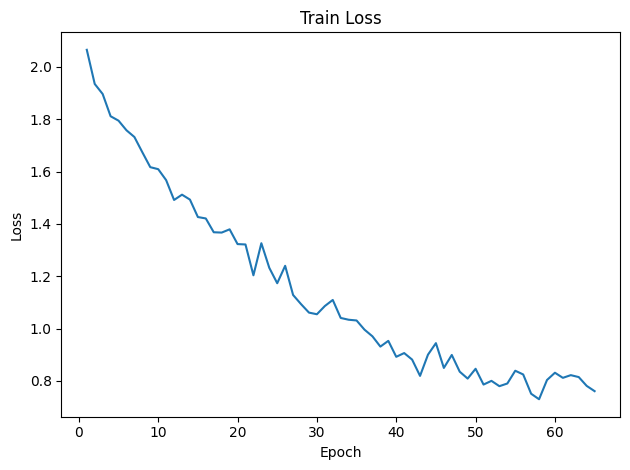

<Figure size 640x480 with 0 Axes>

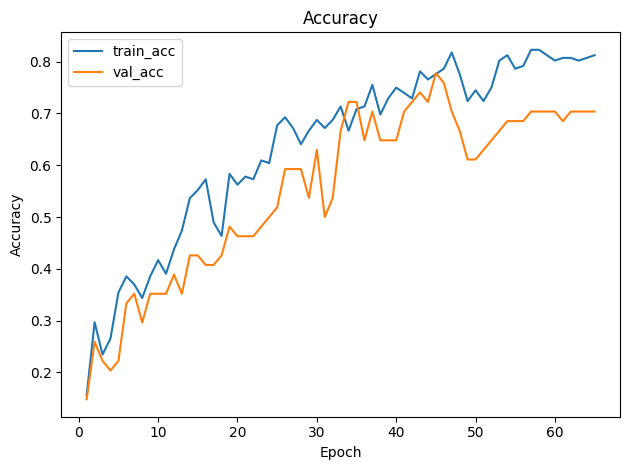

<Figure size 640x480 with 0 Axes>

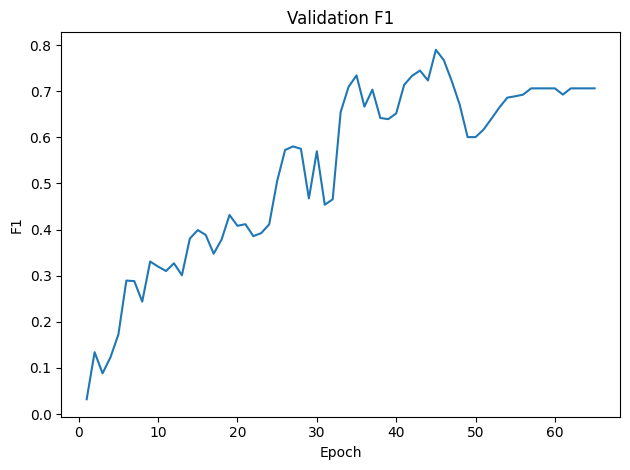

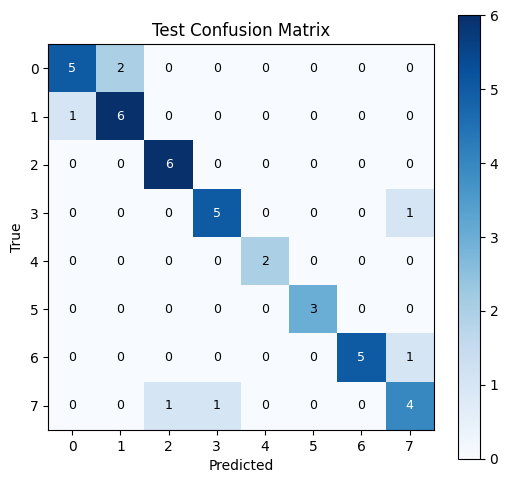

[Fold4] Best val acc=0.778 @ ep45 | Test acc=0.837, prec=0.868, rec=0.863, F1=0.863

Model 4 (SE) | Fold 5
[Fold5] Ep001 tr_loss=2.0504 tr_acc=0.146 val_acc=0.151 val_f1=0.033 | best=0.151@1
[Fold5] Ep005 tr_loss=1.8021 tr_acc=0.214 val_acc=0.189 val_f1=0.104 | best=0.264@3
[Fold5] Ep010 tr_loss=1.6011 tr_acc=0.448 val_acc=0.415 val_f1=0.342 | best=0.415@10
[Fold5] Ep015 tr_loss=1.3979 tr_acc=0.568 val_acc=0.509 val_f1=0.460 | best=0.509@15
[Fold5] Ep020 tr_loss=1.3365 tr_acc=0.594 val_acc=0.566 val_f1=0.519 | best=0.585@18
[Fold5] Ep025 tr_loss=1.1986 tr_acc=0.682 val_acc=0.547 val_f1=0.515 | best=0.642@23
[Fold5] Ep030 tr_loss=1.0309 tr_acc=0.698 val_acc=0.623 val_f1=0.557 | best=0.698@29
[Fold5] Ep035 tr_loss=1.0173 tr_acc=0.677 val_acc=0.642 val_f1=0.574 | best=0.698@29
[Fold5] Ep040 tr_loss=0.9845 tr_acc=0.750 val_acc=0.642 val_f1=0.590 | best=0.698@29
[Fold5] Ep045 tr_loss=0.9284 tr_acc=0.750 val_acc=0.642 val_f1=0.596 | best=0.698@29
[Fold5] Early stopping at epoch 49 (no val im

<Figure size 640x480 with 0 Axes>

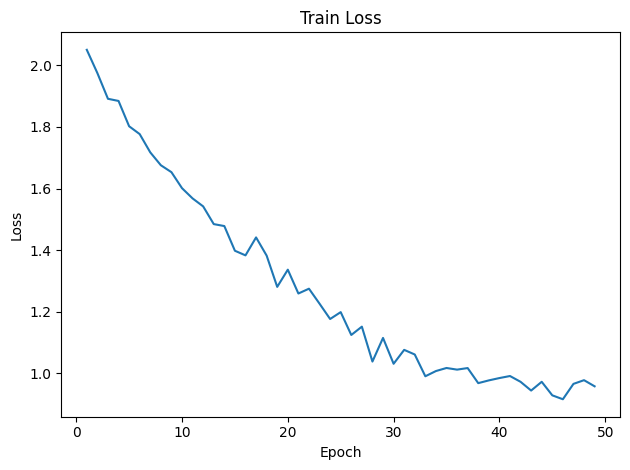

<Figure size 640x480 with 0 Axes>

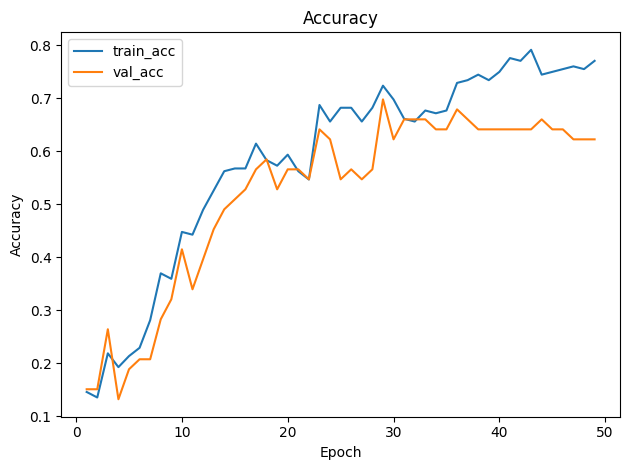

<Figure size 640x480 with 0 Axes>

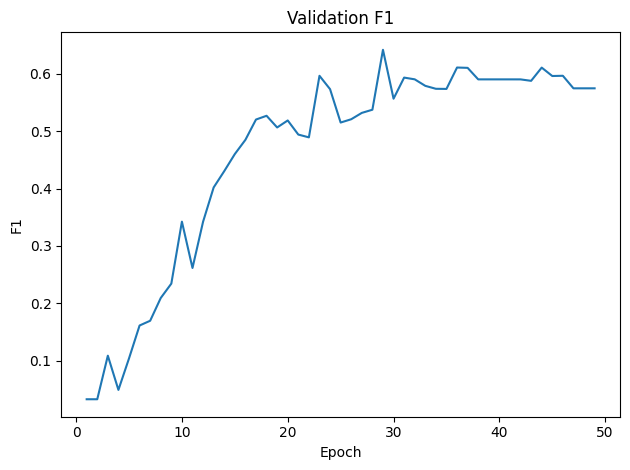

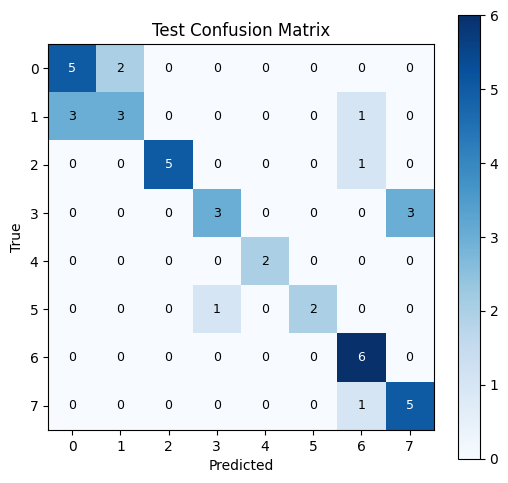

[Fold5] Best val acc=0.698 @ ep29 | Test acc=0.721, prec=0.783, rec=0.747, F1=0.749

Summary saved: /content/drive/MyDrive/ml_runs/sbu_models/Model_4_Original_SE/outputs/summary.csv
       Best Val Acc  Best Epoch  Test Acc  Test Precision (macro)  \
Fold1      0.500000        39.0  0.581395                0.573810   
Fold2      0.534483        36.0  0.651163                0.641518   
Fold3      0.631579        41.0  0.767442                0.811012   
Fold4      0.777778        45.0  0.837209                0.867560   
Fold5      0.698113        29.0  0.720930                0.783333   
Mean       0.628391        38.0  0.711628                0.735446   

       Test Recall (macro)  Test F1 (macro)  Test Precision (weighted)  \
Fold1             0.565476         0.555333                   0.587237   
Fold2             0.619048         0.611756                   0.666694   
Fold3             0.800595         0.800160                   0.777409   
Fold4             0.863095         0.8

In [ ]:
# /content/drive/MyDrive/ml_runs/sbu_models/Model_4_Original_SE/train.py

import os, json, pickle, random
from pathlib import Path
from typing import Any, Dict, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATA_ROOT = Path("/content/drive/MyDrive/ml_runs/sbu_hybrid_colab/data/sbu")
WORK_ROOT = Path("/content/drive/MyDrive/ml_runs/sbu_models/Model_4_Original_SE/outputs")
WORK_ROOT.mkdir(parents=True, exist_ok=True)

EPOCHS       = 200
PATIENCE     = 20
BATCH_SIZE   = 64
LR           = 1e-3
WEIGHT_DECAY = 0.0
NUM_WORKERS  = 2
PIN_MEMORY   = torch.cuda.is_available()
DROPOUT_P    = 0.25
SE_RATIO     = 16

with open(WORK_ROOT/"hyperparams.json","w") as f:
    json.dump({
        "epochs":EPOCHS,"patience":PATIENCE,"batch_size":BATCH_SIZE,
        "lr":LR,"weight_decay":WEIGHT_DECAY,"num_workers":NUM_WORKERS,
        "se_ratio":SE_RATIO,"dropout_p":DROPOUT_P
    }, f, indent=2)

def fold_paths(k:int)->Dict[str, Path]:
    d = DATA_ROOT / f"fold{k}"
    return {
        "train_x": d/"train_data.npy", "train_y": d/"train_label.pkl",
        "val_x":   d/"val_data.npy",   "val_y":   d/"val_label.pkl",
        "test_x":  d/"test_data.npy",  "test_y":  d/"test_label.pkl"
    }

def _first_int(x: Any):
    if isinstance(x, (int, np.integer)): return int(x)
    if isinstance(x, str):
        import re
        m = re.search(r"-?\d+", x)
        if m: return int(m.group(0))
        return None
    return None

def _to_int_list(seq: Any) -> List[int]:
    if isinstance(seq, np.ndarray):
        if seq.dtype.kind in "iu": return seq.astype(np.int64).tolist()
        seq = seq.tolist()
    if isinstance(seq, (list, tuple)):
        out = []
        for it in seq:
            v = _first_int(it)
            if v is None: raise ValueError(f"Label element not int-like: {repr(it)[:120]}")
            out.append(v)
        return out
    raise ValueError(f"Unsupported label container: {type(seq).__name__}")

def load_labels(y_path: Path, expected_N: int) -> np.ndarray:
    with open(y_path, "rb") as f:
        obj = pickle.load(f)
    if isinstance(obj, np.ndarray) and obj.ndim==1 and obj.size==expected_N and obj.dtype.kind in "iu":
        y = obj.astype(np.int64)
    elif isinstance(obj, (list, tuple)) and len(obj)==expected_N and all(isinstance(e, (int, np.integer)) for e in obj):
        y = np.asarray(obj, dtype=np.int64)
    elif isinstance(obj, (list, tuple)) and len(obj)==2:
        cand = obj[0]
        if isinstance(cand, (list, tuple, np.ndarray)):
            labels = _to_int_list(cand)
            if len(labels)!=expected_N: raise ValueError(f"First element length {len(labels)} != N {expected_N}")
            y = np.asarray(labels, dtype=np.int64)
        else:
            raise ValueError(f"First element not list-like in {y_path}: {type(cand).__name__}")
    elif isinstance(obj, dict):
        for k in ["labels","y","targets"]:
            if k in obj:
                labels = _to_int_list(obj[k])
                if len(labels)!=expected_N: raise ValueError(f"dict['{k}'] length {len(labels)} != N {expected_N}")
                y = np.asarray(labels, dtype=np.int64)
                break
        else:
            raise ValueError(f"Unsupported dict label format keys={list(obj.keys())[:10]}")
    else:
        raise ValueError(f"Unsupported label.pkl type: {type(obj).__name__}")
    uniq = np.unique(y)
    if not np.array_equal(uniq, np.arange(int(uniq.max())+1)):
        mapping = {int(c):i for i,c in enumerate(sorted(uniq))}
        y = np.vectorize(lambda z: mapping[int(z)])(y).astype(np.int64)
    return y

class SBUFoldDataset(torch.utils.data.Dataset):
    def __init__(self, x_path: Path, y_path: Path):
        x = np.load(x_path)
        if x.ndim == 4:
            x = x[..., None]
        self.x = x
        N = self.x.shape[0]
        y = load_labels(y_path, expected_N=N)
        if len(y)!=N: raise ValueError(f"N mismatch for {x_path.name}: X={N} y={len(y)}")
        self.y = y
    def __len__(self): return self.x.shape[0]
    def __getitem__(self, idx):
        return torch.from_numpy(self.x[idx]).float(), int(self.y[idx])

class SE3D(nn.Module):
    def __init__(self, channels: int, r: int = 16):
        super().__init__()
        hidden = max(8, channels // r)
        self.pool = nn.AdaptiveAvgPool3d(1)
        self.fc1  = nn.Conv3d(channels, hidden, kernel_size=1)
        self.fc2  = nn.Conv3d(hidden, channels, kernel_size=1)
    def forward(self, x):
        w = self.pool(x)
        w = F.relu(self.fc1(w), inplace=True)
        w = torch.sigmoid(self.fc2(w))
        return x * w

class STGCN_SE_Block(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=9, stride=1, se_ratio=16, p_drop=0.25):
        super().__init__()
        pad = (kernel_size - 1) // 2
        self.conv = nn.Conv3d(in_ch, out_ch, kernel_size=(1, kernel_size, 1),
                              padding=(0, pad, 0), stride=(1, stride, 1), bias=False)
        self.bn   = nn.BatchNorm3d(out_ch)
        self.se   = SE3D(out_ch, r=se_ratio)
        self.drop = nn.Dropout3d(p_drop) if p_drop > 0 else nn.Identity()
        self.proj = nn.Conv3d(in_ch, out_ch, kernel_size=1) if (in_ch != out_ch or stride!=1) else nn.Identity()
    def forward(self, x):
        y = self.conv(x)
        y = self.bn(y)
        y = F.relu(y, inplace=True)
        y = self.se(y)
        y = self.drop(y)
        return y + self.proj(x)

class STGCN_SE(nn.Module):
    def __init__(self, in_ch=2, num_class=8, se_ratio=16, p_drop=0.25):
        super().__init__()
        self.block1 = STGCN_SE_Block(in_ch,   64, se_ratio=se_ratio, p_drop=p_drop)
        self.block2 = STGCN_SE_Block(64,     128, se_ratio=se_ratio, p_drop=p_drop)
        self.block3 = STGCN_SE_Block(128,    256, se_ratio=se_ratio, p_drop=p_drop)
        self.pool   = nn.AdaptiveAvgPool3d((1,1,1))
        self.fc     = nn.Linear(256, num_class)
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)

@torch.no_grad()
def eval_loader(model, loader):
    model.eval()
    all_t, all_p = [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        out = model(xb)
        pred = out.argmax(1)
        all_t.extend(yb.cpu().numpy().tolist())
        all_p.extend(pred.cpu().numpy().tolist())
    acc   = accuracy_score(all_t, all_p)
    prec  = precision_score(all_t, all_p, average="macro",    zero_division=0)
    rec   = recall_score(all_t, all_p, average="macro",       zero_division=0)
    f1    = f1_score(all_t, all_p, average="macro",           zero_division=0)
    precw = precision_score(all_t, all_p, average="weighted", zero_division=0)
    recw  = recall_score(all_t, all_p, average="weighted",    zero_division=0)
    f1w   = f1_score(all_t, all_p, average="weighted",        zero_division=0)
    cm    = confusion_matrix(all_t, all_p)
    rep   = classification_report(all_t, all_p, output_dict=True, zero_division=0)
    return {
        "acc":acc, "prec":prec, "rec":rec, "f1":f1,
        "prec_w":precw, "rec_w":recw, "f1_w":f1w,
        "cm":cm, "rep":rep
    }

def plot_curves(history, out_dir: Path):
    df = pd.DataFrame(history)
    out_dir.mkdir(parents=True, exist_ok=True)

    plt.figure()
    df[["epoch","train_loss"]].set_index("epoch").plot(legend=False)
    plt.title("Train Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.tight_layout(); plt.savefig(out_dir/"loss.png", dpi=150); plt.show()

    plt.figure()
    df[["epoch","train_acc","val_acc"]].set_index("epoch").plot()
    plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.tight_layout(); plt.savefig(out_dir/"val_acc.png", dpi=150); plt.show()

    plt.figure()
    df[["epoch","val_f1"]].set_index("epoch").plot(legend=False)
    plt.title("Validation F1"); plt.xlabel("Epoch"); plt.ylabel("F1")
    plt.tight_layout(); plt.savefig(out_dir/"val_f1.png", dpi=150); plt.show()

def plot_confusion(cm: np.ndarray, out_path: Path, title="Confusion Matrix"):
    plt.figure(figsize=(5.5,5))
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title); plt.colorbar()
    ticks = np.arange(cm.shape[0])
    plt.xticks(ticks, ticks); plt.yticks(ticks, ticks)
    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            plt.text(j, i, str(val), ha="center", va="center",
                     color="white" if val > thresh else "black", fontsize=9)
    plt.ylabel("True"); plt.xlabel("Predicted")
    plt.tight_layout(); plt.savefig(out_path, dpi=150); plt.show()

def train_fold(k:int, epochs=EPOCHS, patience=PATIENCE, batch_size=BATCH_SIZE, lr=LR):
    paths = fold_paths(k)
    out_dir = WORK_ROOT/f"fold{k}"; out_dir.mkdir(parents=True, exist_ok=True)

    tr_ds = SBUFoldDataset(paths["train_x"], paths["train_y"])
    va_ds = SBUFoldDataset(paths["val_x"], paths["val_y"])
    te_ds = SBUFoldDataset(paths["test_x"], paths["test_y"])

    tr_ld = DataLoader(tr_ds, batch_size=batch_size, shuffle=True,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=True)
    va_ld = DataLoader(va_ds, batch_size=batch_size, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    te_ld = DataLoader(te_ds, batch_size=batch_size, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    in_ch = tr_ds.x.shape[1]
    num_class = int(max(tr_ds.y.max(), va_ds.y.max(), te_ds.y.max()) + 1)

    with open(out_dir/"label_summary.json","w") as f:
        json.dump({
            "train_unique": sorted(list(map(int, np.unique(tr_ds.y)))),
            "val_unique":   sorted(list(map(int, np.unique(va_ds.y)))),
            "test_unique":  sorted(list(map(int, np.unique(te_ds.y)))),
            "num_class":    int(num_class)
        }, f, indent=2)

    model = STGCN_SE(in_ch=in_ch, num_class=num_class, se_ratio=SE_RATIO, p_drop=DROPOUT_P).to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", patience=4, factor=0.5)

    best_val, best_ep, no_improve = -1.0, -1, 0
    history = []
    best_path = out_dir/"best.pt"

    for ep in range(1, epochs+1):
        model.train()
        n, loss_sum = 0, 0.0
        for xb, yb in tr_ld:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            out = model(xb)
            loss = F.cross_entropy(out, yb)
            loss.backward()
            opt.step()
            loss_sum += loss.item() * yb.size(0)
            n += yb.size(0)

        tr_loss = loss_sum / max(1, n)
        tr_eval = eval_loader(model, tr_ld)
        va_eval = eval_loader(model, va_ld)

        history.append({
            "epoch":ep, "train_loss":tr_loss,
            "train_acc":tr_eval["acc"], "val_acc":va_eval["acc"], "val_f1":va_eval["f1"]
        })

        sched.step(va_eval["acc"])
        if va_eval["acc"] > best_val + 1e-8:
            best_val = va_eval["acc"]
            best_ep = ep
            no_improve = 0
            torch.save({"model": model.state_dict()}, best_path)
            np.savetxt(out_dir/"cm_val_best.csv", va_eval["cm"].astype(int), fmt="%d", delimiter=",")
            pd.DataFrame(va_eval["rep"]).to_csv(out_dir/"report_val_best.csv")
            with open(out_dir/"best.json","w") as f:
                json.dump({"best_epoch": int(best_ep), "best_val_acc": float(best_val)}, f, indent=2)
        else:
            no_improve += 1

        if ep == 1 or ep % 5 == 0:
            pd.DataFrame(history).to_csv(out_dir/"history.csv", index=False)
            print(f"[Fold{k}] Ep{ep:03d} tr_loss={tr_loss:.4f} tr_acc={tr_eval['acc']:.3f} "
                  f"val_acc={va_eval['acc']:.3f} val_f1={va_eval['f1']:.3f} | best={best_val:.3f}@{best_ep}")

        if no_improve >= patience:
            print(f"[Fold{k}] Early stopping at epoch {ep} (no val improvement for {patience} epochs)")
            break

    pd.DataFrame(history).to_csv(out_dir/"history.csv", index=False)
    plot_curves(history, out_dir)

    state = torch.load(best_path, map_location="cpu")
    model.load_state_dict(state["model"])
    te = eval_loader(model, te_ld)
    np.savetxt(out_dir/"cm_test.csv", te["cm"].astype(int), fmt="%d", delimiter=",")
    pd.DataFrame(te["rep"]).to_csv(out_dir/"report_test.csv")
    with open(out_dir/"results.json","w") as f:
        json.dump({
            "best_val_acc": float(best_val), "best_epoch": int(best_ep),
            "test_acc": float(te["acc"]),
            "test_precision_macro": float(te["prec"]),
            "test_recall_macro": float(te["rec"]),
            "test_f1_macro": float(te["f1"]),
            "test_precision_weighted": float(te["prec_w"]),
            "test_recall_weighted": float(te["rec_w"]),
            "test_f1_weighted": float(te["f1_w"])
        }, f, indent=2)

    plot_confusion(te["cm"], out_dir/"cm_test.png", title="Test Confusion Matrix")

    print(f"[Fold{k}] Best val acc={best_val:.3f} @ ep{best_ep} | "
          f"Test acc={te['acc']:.3f}, prec={te['prec']:.3f}, rec={te['rec']:.3f}, F1={te['f1']:.3f}")

    return {
        "best_val_acc": best_val,
        "best_epoch": best_ep,
        "test_acc": te["acc"],
        "test_precision_macro": te["prec"],
        "test_recall_macro": te["rec"],
        "test_f1_macro": te["f1"],
        "test_precision_weighted": te["prec_w"],
        "test_recall_weighted": te["rec_w"],
        "test_f1_weighted": te["f1_w"]
    }

def run_all():
    rows = []
    for k in range(1,6):
        print(f"\nModel 4 (SE) | Fold {k}")
        r = train_fold(k)
        rows.append([
            r["best_val_acc"], r["best_epoch"], r["test_acc"],
            r["test_precision_macro"], r["test_recall_macro"], r["test_f1_macro"],
            r["test_precision_weighted"], r["test_recall_weighted"], r["test_f1_weighted"]
        ])
    cols = [
        "Best Val Acc","Best Epoch","Test Acc",
        "Test Precision (macro)","Test Recall (macro)","Test F1 (macro)",
        "Test Precision (weighted)","Test Recall (weighted)","Test F1 (weighted)"
    ]
    df = pd.DataFrame(rows, columns=cols, index=[f"Fold{i}" for i in range(1,6)])
    df.loc["Mean"] = df.mean(numeric_only=True).to_dict()
    df.to_csv(WORK_ROOT/"summary.csv", index=True)
    print("\nSummary saved:", WORK_ROOT/"summary.csv")
    print(df)

if __name__ == "__main__":
    run_all()



Model 5 (Transformer) | Fold 1


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[Fold1] Ep001 tr_loss=2.6499 tr_acc=0.188 val_acc=0.183 val_f1=0.079 | best=0.183@1
[Fold1] Ep005 tr_loss=2.0421 tr_acc=0.250 val_acc=0.233 val_f1=0.134 | best=0.233@4
[Fold1] Ep010 tr_loss=1.5169 tr_acc=0.359 val_acc=0.333 val_f1=0.223 | best=0.333@9
[Fold1] Ep015 tr_loss=1.0353 tr_acc=0.552 val_acc=0.517 val_f1=0.507 | best=0.517@15
[Fold1] Ep020 tr_loss=0.8081 tr_acc=0.688 val_acc=0.550 val_f1=0.497 | best=0.550@20
[Fold1] Ep025 tr_loss=0.6081 tr_acc=0.698 val_acc=0.467 val_f1=0.453 | best=0.667@22
[Fold1] Ep030 tr_loss=0.3356 tr_acc=0.891 val_acc=0.667 val_f1=0.641 | best=0.717@29
[Fold1] Ep035 tr_loss=0.3247 tr_acc=0.839 val_acc=0.750 val_f1=0.705 | best=0.767@33
[Fold1] Ep040 tr_loss=0.2087 tr_acc=0.927 val_acc=0.767 val_f1=0.721 | best=0.833@39
[Fold1] Ep045 tr_loss=0.0824 tr_acc=0.995 val_acc=0.883 val_f1=0.862 | best=0.883@45
[Fold1] Ep050 tr_loss=0.0310 tr_acc=1.000 val_acc=0.833 val_f1=0.812 | best=0.883@45
[Fold1] Ep055 tr_loss=0.0205 tr_acc=1.000 val_acc=0.833 val_f1=0.812

<Figure size 640x480 with 0 Axes>

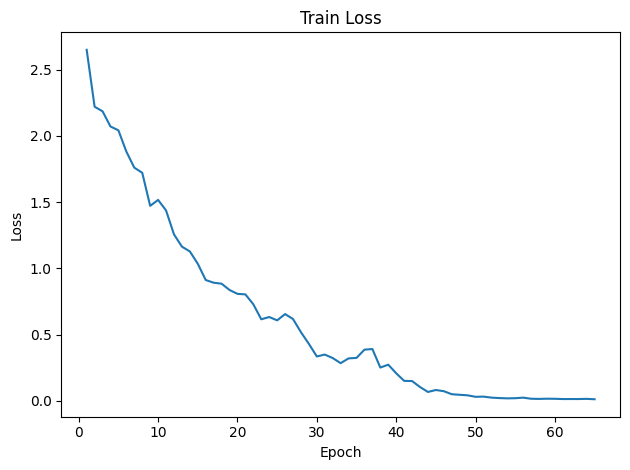

<Figure size 640x480 with 0 Axes>

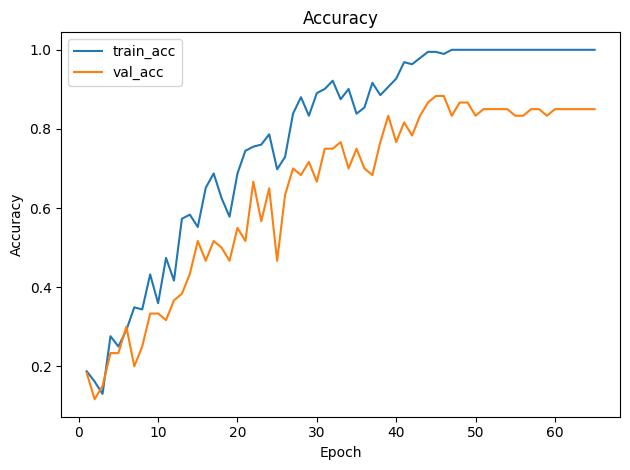

<Figure size 640x480 with 0 Axes>

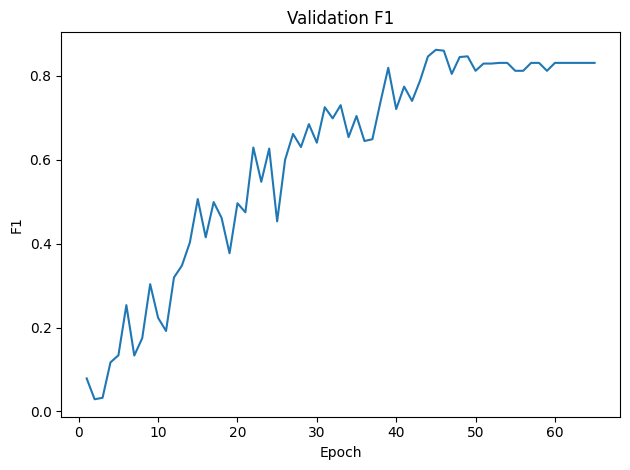

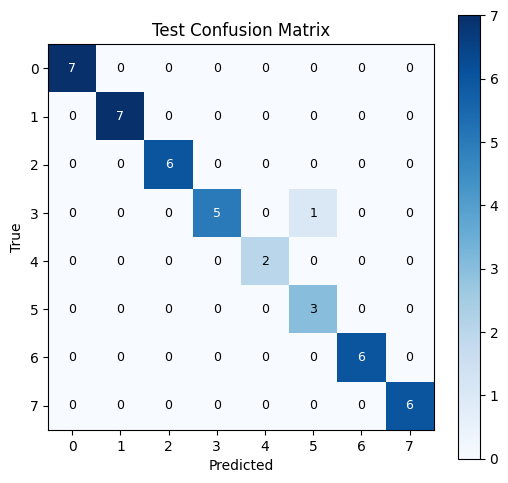

[Fold1] Best val acc=0.883 @ ep45 | Test acc=0.977, prec=0.969, rec=0.979, F1=0.971

Model 5 (Transformer) | Fold 2


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[Fold2] Ep001 tr_loss=2.4739 tr_acc=0.172 val_acc=0.121 val_f1=0.064 | best=0.121@1
[Fold2] Ep005 tr_loss=1.9932 tr_acc=0.193 val_acc=0.224 val_f1=0.119 | best=0.224@5
[Fold2] Ep010 tr_loss=1.4525 tr_acc=0.422 val_acc=0.276 val_f1=0.304 | best=0.414@9
[Fold2] Ep015 tr_loss=1.0722 tr_acc=0.599 val_acc=0.448 val_f1=0.407 | best=0.500@13
[Fold2] Ep020 tr_loss=0.7557 tr_acc=0.719 val_acc=0.483 val_f1=0.442 | best=0.569@19
[Fold2] Ep025 tr_loss=0.5142 tr_acc=0.833 val_acc=0.603 val_f1=0.569 | best=0.603@23
[Fold2] Ep030 tr_loss=0.4137 tr_acc=0.859 val_acc=0.569 val_f1=0.556 | best=0.638@28
[Fold2] Ep035 tr_loss=0.2956 tr_acc=0.901 val_acc=0.724 val_f1=0.694 | best=0.724@35
[Fold2] Ep040 tr_loss=0.1690 tr_acc=0.990 val_acc=0.724 val_f1=0.734 | best=0.793@38
[Fold2] Ep045 tr_loss=0.1008 tr_acc=0.984 val_acc=0.776 val_f1=0.767 | best=0.793@38
[Fold2] Ep050 tr_loss=0.0596 tr_acc=1.000 val_acc=0.793 val_f1=0.770 | best=0.810@46
[Fold2] Ep055 tr_loss=0.0323 tr_acc=1.000 val_acc=0.793 val_f1=0.777

<Figure size 640x480 with 0 Axes>

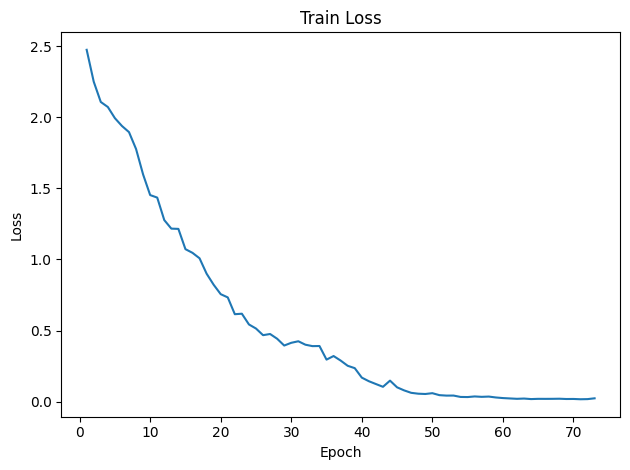

<Figure size 640x480 with 0 Axes>

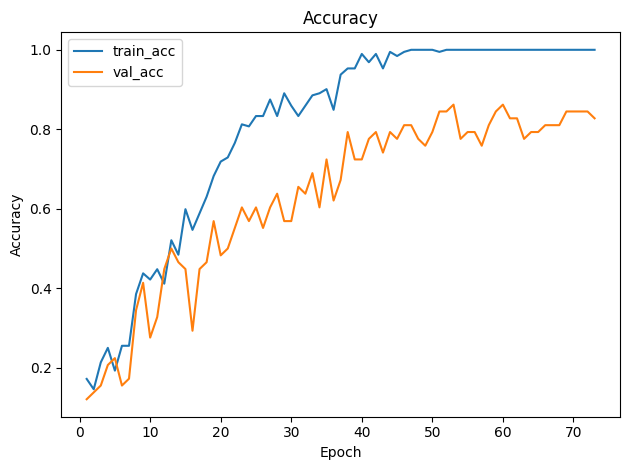

<Figure size 640x480 with 0 Axes>

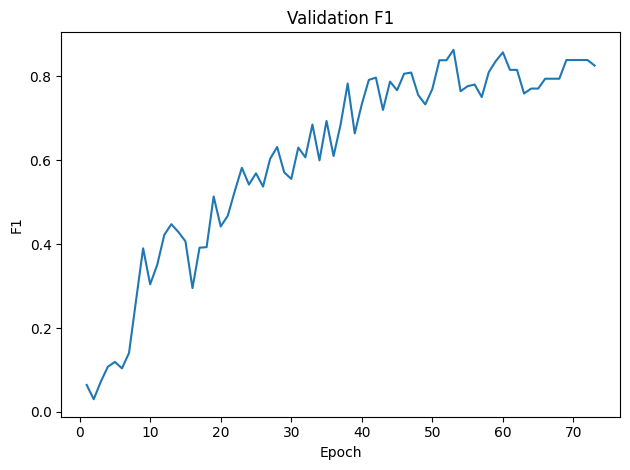

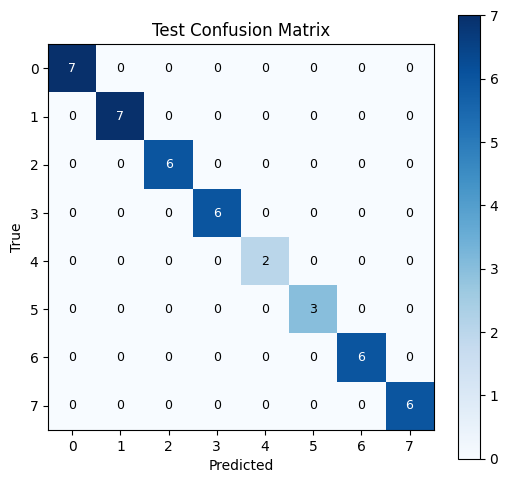

[Fold2] Best val acc=0.862 @ ep53 | Test acc=1.000, prec=1.000, rec=1.000, F1=1.000

Model 5 (Transformer) | Fold 3


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[Fold3] Ep001 tr_loss=2.6313 tr_acc=0.125 val_acc=0.140 val_f1=0.046 | best=0.140@1
[Fold3] Ep005 tr_loss=2.0295 tr_acc=0.188 val_acc=0.053 val_f1=0.020 | best=0.263@3
[Fold3] Ep010 tr_loss=1.7227 tr_acc=0.380 val_acc=0.211 val_f1=0.159 | best=0.263@3
[Fold3] Ep015 tr_loss=1.3106 tr_acc=0.526 val_acc=0.386 val_f1=0.298 | best=0.386@15
[Fold3] Ep020 tr_loss=0.8688 tr_acc=0.609 val_acc=0.456 val_f1=0.417 | best=0.456@18
[Fold3] Ep025 tr_loss=0.7513 tr_acc=0.771 val_acc=0.579 val_f1=0.562 | best=0.579@25
[Fold3] Ep030 tr_loss=0.5632 tr_acc=0.797 val_acc=0.649 val_f1=0.627 | best=0.649@28
[Fold3] Ep035 tr_loss=0.3750 tr_acc=0.885 val_acc=0.737 val_f1=0.725 | best=0.772@32
[Fold3] Ep040 tr_loss=0.2157 tr_acc=0.948 val_acc=0.667 val_f1=0.648 | best=0.772@32
[Fold3] Ep045 tr_loss=0.1366 tr_acc=0.995 val_acc=0.772 val_f1=0.782 | best=0.842@41
[Fold3] Ep050 tr_loss=0.0794 tr_acc=0.995 val_acc=0.772 val_f1=0.776 | best=0.842@41
[Fold3] Ep055 tr_loss=0.0604 tr_acc=1.000 val_acc=0.807 val_f1=0.814

<Figure size 640x480 with 0 Axes>

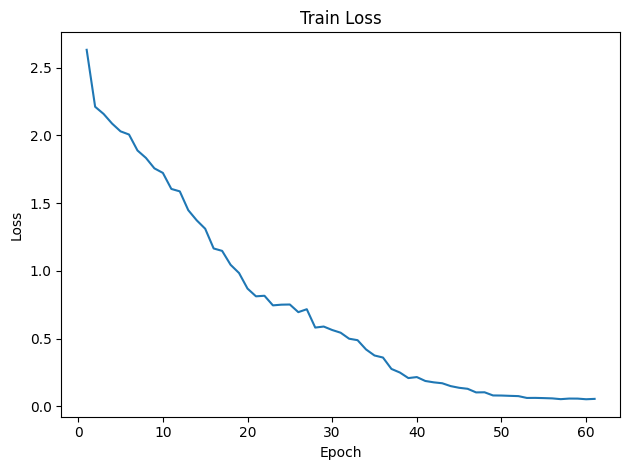

<Figure size 640x480 with 0 Axes>

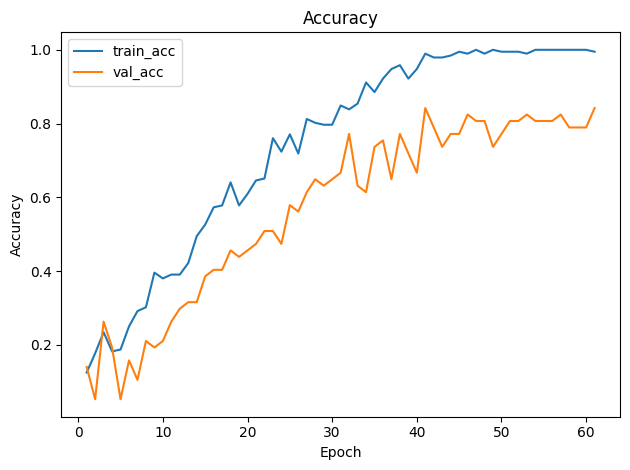

<Figure size 640x480 with 0 Axes>

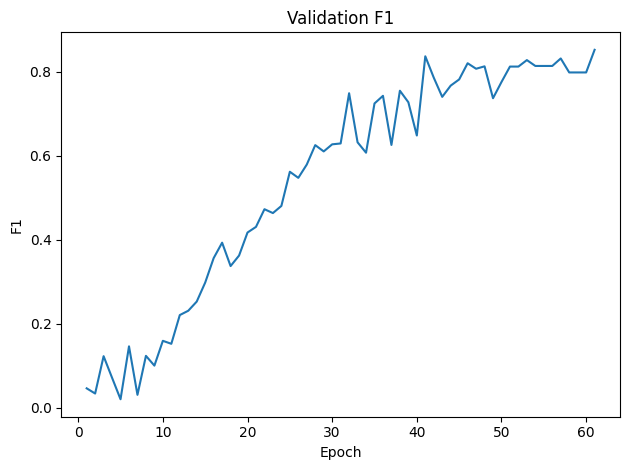

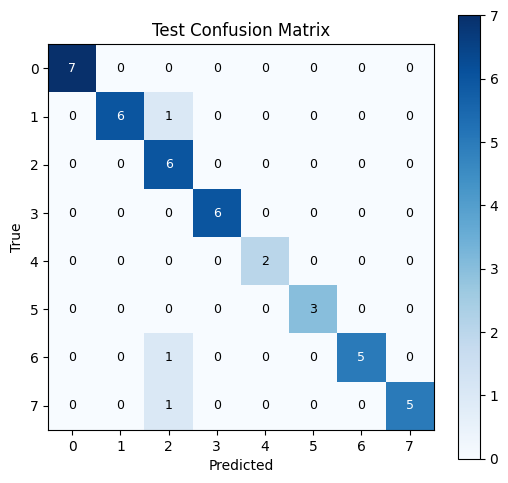

[Fold3] Best val acc=0.842 @ ep41 | Test acc=0.930, prec=0.958, rec=0.940, F1=0.943

Model 5 (Transformer) | Fold 4


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[Fold4] Ep001 tr_loss=2.5076 tr_acc=0.193 val_acc=0.074 val_f1=0.027 | best=0.074@1
[Fold4] Ep005 tr_loss=2.1365 tr_acc=0.130 val_acc=0.130 val_f1=0.029 | best=0.204@4
[Fold4] Ep010 tr_loss=2.0723 tr_acc=0.156 val_acc=0.130 val_f1=0.029 | best=0.204@4
[Fold4] Ep015 tr_loss=1.8401 tr_acc=0.271 val_acc=0.204 val_f1=0.094 | best=0.259@14
[Fold4] Ep020 tr_loss=1.3047 tr_acc=0.516 val_acc=0.389 val_f1=0.295 | best=0.389@20
[Fold4] Ep025 tr_loss=0.8891 tr_acc=0.651 val_acc=0.407 val_f1=0.361 | best=0.500@23
[Fold4] Ep030 tr_loss=0.7271 tr_acc=0.776 val_acc=0.444 val_f1=0.409 | best=0.630@28
[Fold4] Ep035 tr_loss=0.5709 tr_acc=0.818 val_acc=0.556 val_f1=0.540 | best=0.630@28
[Fold4] Ep040 tr_loss=0.4436 tr_acc=0.901 val_acc=0.648 val_f1=0.633 | best=0.667@36
[Fold4] Ep045 tr_loss=0.3280 tr_acc=0.917 val_acc=0.685 val_f1=0.675 | best=0.685@45
[Fold4] Ep050 tr_loss=0.2562 tr_acc=0.943 val_acc=0.704 val_f1=0.679 | best=0.704@50
[Fold4] Ep055 tr_loss=0.1973 tr_acc=0.948 val_acc=0.778 val_f1=0.752

<Figure size 640x480 with 0 Axes>

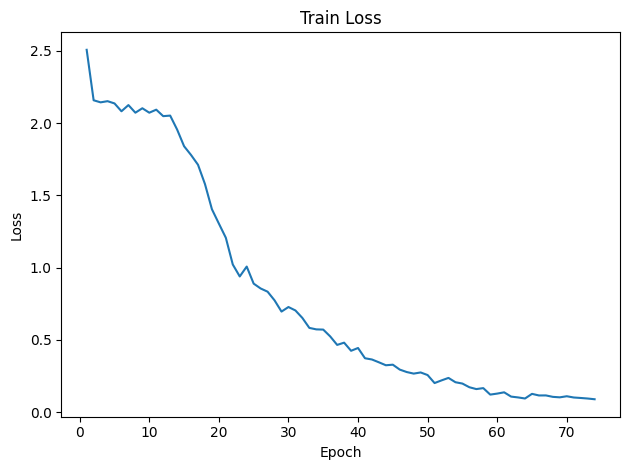

<Figure size 640x480 with 0 Axes>

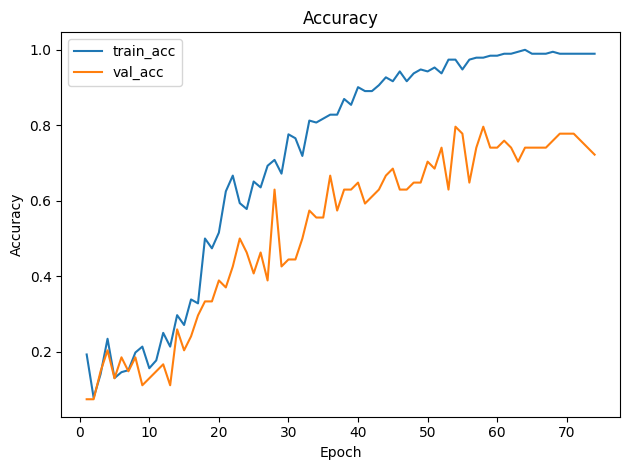

<Figure size 640x480 with 0 Axes>

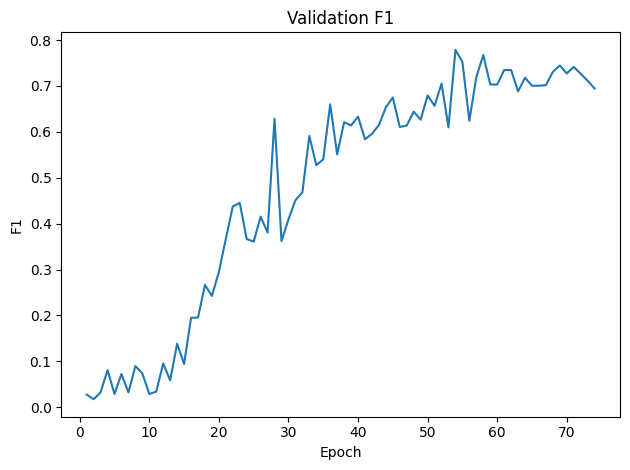

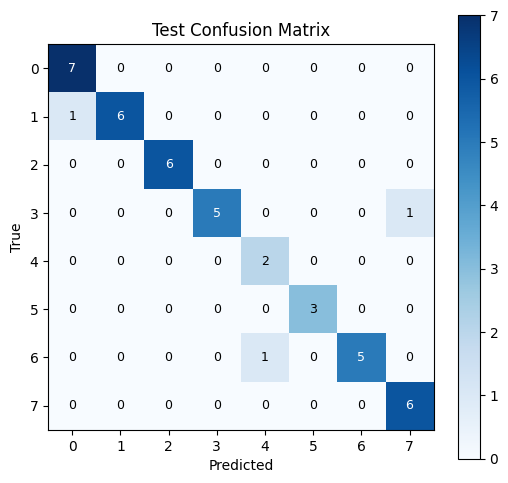

[Fold4] Best val acc=0.796 @ ep54 | Test acc=0.930, prec=0.925, rec=0.940, F1=0.925

Model 5 (Transformer) | Fold 5


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[Fold5] Ep001 tr_loss=2.4779 tr_acc=0.135 val_acc=0.151 val_f1=0.034 | best=0.151@1
[Fold5] Ep005 tr_loss=2.0815 tr_acc=0.167 val_acc=0.113 val_f1=0.030 | best=0.170@4
[Fold5] Ep010 tr_loss=1.8647 tr_acc=0.240 val_acc=0.151 val_f1=0.064 | best=0.189@8
[Fold5] Ep015 tr_loss=1.6875 tr_acc=0.370 val_acc=0.226 val_f1=0.183 | best=0.283@14
[Fold5] Ep020 tr_loss=1.1235 tr_acc=0.464 val_acc=0.434 val_f1=0.449 | best=0.434@20
[Fold5] Ep025 tr_loss=0.7757 tr_acc=0.750 val_acc=0.566 val_f1=0.498 | best=0.566@25
[Fold5] Ep030 tr_loss=0.6393 tr_acc=0.854 val_acc=0.585 val_f1=0.547 | best=0.585@30
[Fold5] Ep035 tr_loss=0.3985 tr_acc=0.859 val_acc=0.736 val_f1=0.716 | best=0.811@34
[Fold5] Ep040 tr_loss=0.3450 tr_acc=0.870 val_acc=0.717 val_f1=0.684 | best=0.811@34
[Fold5] Ep045 tr_loss=0.1563 tr_acc=0.974 val_acc=0.811 val_f1=0.795 | best=0.811@34
[Fold5] Ep050 tr_loss=0.0933 tr_acc=0.979 val_acc=0.792 val_f1=0.777 | best=0.811@34
[Fold5] Ep055 tr_loss=0.0840 tr_acc=0.995 val_acc=0.830 val_f1=0.818

<Figure size 640x480 with 0 Axes>

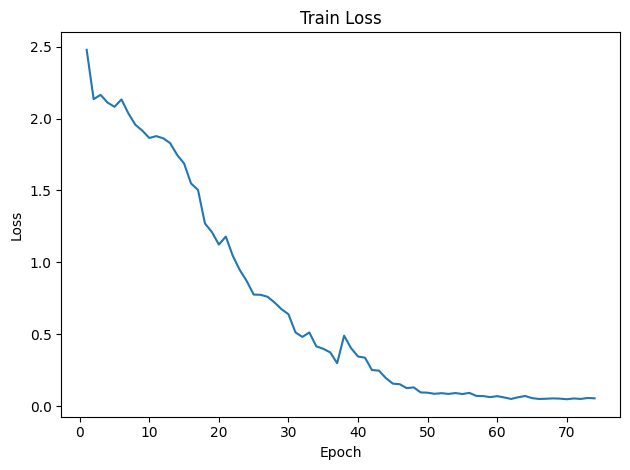

<Figure size 640x480 with 0 Axes>

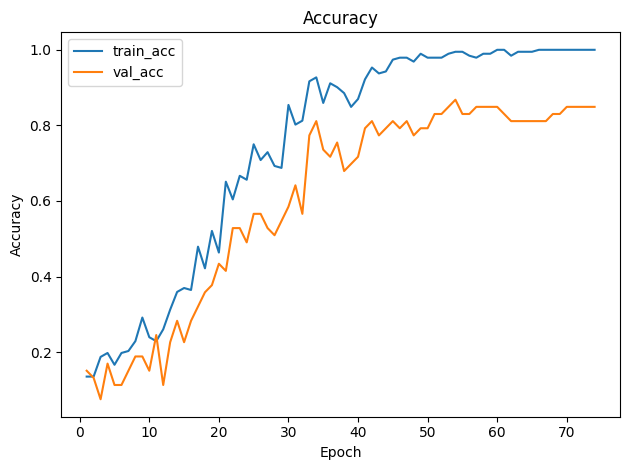

<Figure size 640x480 with 0 Axes>

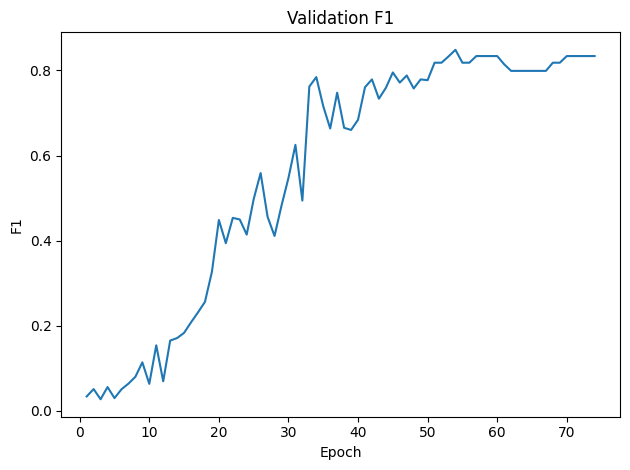

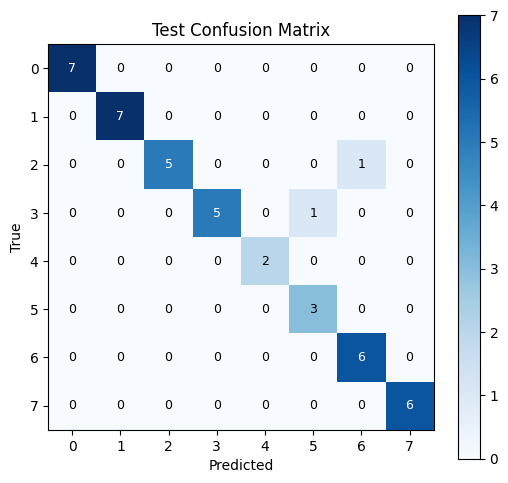

[Fold5] Best val acc=0.868 @ ep54 | Test acc=0.953, prec=0.951, rec=0.958, F1=0.950

Summary saved: /content/drive/MyDrive/ml_runs/sbu_models/Model_5_Original_Transformer/outputs/summary.csv
       Best Val Acc  Best Epoch  Test Acc  Test Precision (macro)  \
Fold1      0.883333        45.0  0.976744                0.968750   
Fold2      0.862069        53.0  1.000000                1.000000   
Fold3      0.842105        41.0  0.930233                0.958333   
Fold4      0.796296        54.0  0.930233                0.924851   
Fold5      0.867925        54.0  0.953488                0.950893   
Mean       0.850346        49.4  0.958140                0.960565   

       Test Recall (macro)  Test F1 (macro)  Test Precision (weighted)  \
Fold1             0.979167         0.970779                   0.982558   
Fold2             1.000000         1.000000                   1.000000   
Fold3             0.940476         0.942657                   0.953488   
Fold4             0.940476   

In [ ]:
# /content/drive/MyDrive/ml_runs/sbu_models/Model_5_Original_Transformer/train.py

import os, json, pickle, random
from pathlib import Path
from typing import Any, Dict, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATA_ROOT = Path("/content/drive/MyDrive/ml_runs/sbu_hybrid_colab/data/sbu")
WORK_ROOT = Path("/content/drive/MyDrive/ml_runs/sbu_models/Model_5_Original_Transformer/outputs")
WORK_ROOT.mkdir(parents=True, exist_ok=True)

EPOCHS       = 200
PATIENCE     = 20
BATCH_SIZE   = 64
LR           = 1e-3
WEIGHT_DECAY = 0.0
NUM_WORKERS  = 2
PIN_MEMORY   = torch.cuda.is_available()

D_MODEL         = 256
N_HEAD          = 8
NUM_LAYERS      = 4
DIM_FEEDFORWARD = 512
DROPOUT         = 0.25
POOL_MODE       = "mean"   # ["mean", "cls"]

with open(WORK_ROOT/"hyperparams.json","w") as f:
    json.dump({
        "epochs":EPOCHS,"patience":PATIENCE,"batch_size":BATCH_SIZE,
        "lr":LR,"weight_decay":WEIGHT_DECAY,"num_workers":NUM_WORKERS,
        "transformer":{
            "d_model":D_MODEL,"nhead":N_HEAD,"num_layers":NUM_LAYERS,
            "dim_feedforward":DIM_FEEDFORWARD,"dropout":DROPOUT,
            "pool_mode": POOL_MODE
        }
    }, f, indent=2)

def fold_paths(k:int)->Dict[str, Path]:
    d = DATA_ROOT / f"fold{k}"
    return {
        "train_x": d/"train_data.npy", "train_y": d/"train_label.pkl",
        "val_x":   d/"val_data.npy",   "val_y":   d/"val_label.pkl",
        "test_x":  d/"test_data.npy",  "test_y":  d/"test_label.pkl"
    }

def _first_int(x: Any):
    if isinstance(x, (int, np.integer)): return int(x)
    if isinstance(x, str):
        import re
        m = re.search(r"-?\d+", x)
        if m: return int(m.group(0))
        return None
    return None

def _to_int_list(seq: Any) -> List[int]:
    if isinstance(seq, np.ndarray):
        if seq.dtype.kind in "iu":
            return seq.astype(np.int64).tolist()
        seq = seq.tolist()
    if isinstance(seq, (list, tuple)):
        out = []
        for it in seq:
            v = _first_int(it)
            if v is None:
                raise ValueError(f"Label element not int-like: {repr(it)[:120]}")
            out.append(v)
        return out
    raise ValueError(f"Unsupported label container: {type(seq).__name__}")

def load_labels(y_path: Path, expected_N: int) -> np.ndarray:
    with open(y_path, "rb") as f:
        obj = pickle.load(f)

    if isinstance(obj, np.ndarray) and obj.ndim == 1 and obj.size == expected_N and obj.dtype.kind in "iu":
        y = obj.astype(np.int64)
    elif isinstance(obj, (list, tuple)) and len(obj) == expected_N and all(isinstance(e, (int, np.integer)) for e in obj):
        y = np.asarray(obj, dtype=np.int64)
    elif isinstance(obj, (list, tuple)) and len(obj) == 2:
        cand = obj[0]
        if isinstance(cand, (list, tuple, np.ndarray)):
            labels = _to_int_list(cand)
            if len(labels) != expected_N:
                raise ValueError(f"First element length {len(labels)} != N {expected_N} in {y_path}")
            y = np.asarray(labels, dtype=np.int64)
        else:
            raise ValueError(f"First element not list-like in {y_path}: {type(cand).__name__}")
    elif isinstance(obj, dict):
        for k in ["labels","y","targets"]:
            if k in obj:
                labels = _to_int_list(obj[k])
                if len(labels) != expected_N:
                    raise ValueError(f"dict['{k}'] length {len(labels)} != N {expected_N}")
                y = np.asarray(labels, dtype=np.int64)
                break
        else:
            raise ValueError(f"Unsupported dict label format keys={list(obj.keys())[:10]}")
    else:
        raise ValueError(f"Unsupported label.pkl type: {type(obj).__name__}")

    uniq = np.unique(y)
    if not np.array_equal(uniq, np.arange(int(uniq.max())+1)):
        mapping = {int(c):i for i,c in enumerate(sorted(uniq))}
        y = np.vectorize(lambda z: mapping[int(z)])(y).astype(np.int64)
    return y

class SBUFoldDataset(torch.utils.data.Dataset):
    def __init__(self, x_path: Path, y_path: Path):
        x = np.load(x_path)  # [N,C,T,V,M] or [N,C,T,V]
        if x.ndim == 4:  # [N,C,T,V] -> add M=1
            x = x[..., None]
        self.x = x
        N = self.x.shape[0]
        y = load_labels(y_path, expected_N=N)
        if len(y) != N:
            raise ValueError(f"N mismatch for {x_path.name}: X={N} y={len(y)}")
        self.y = y
    def __len__(self): return self.x.shape[0]
    def __getitem__(self, idx):
        return torch.from_numpy(self.x[idx]).float(), int(self.y[idx])

class LearnedPositionalEncoding(nn.Module):
    def __init__(self, max_len: int, d_model: int):
        super().__init__()
        self.pe = nn.Parameter(torch.zeros(1, max_len, d_model))
        nn.init.trunc_normal_(self.pe, std=0.02)
    def forward(self, x):  # x: [N,T,d]
        T = x.size(1)
        return x + self.pe[:, :T, :]

class TemporalTransformer(nn.Module):
    def __init__(self, in_ch:int, T:int, V:int, M:int, num_class:int,
                 d_model=D_MODEL, nhead=N_HEAD, num_layers=NUM_LAYERS,
                 dim_ff=DIM_FEEDFORWARD, dropout=DROPOUT, pool=POOL_MODE):
        super().__init__()
        self.in_ch = in_ch; self.T=T; self.V=V; self.M=M
        in_feat = in_ch * V * M
        self.proj = nn.Linear(in_feat, d_model)
        self.pos  = LearnedPositionalEncoding(max_len=T, d_model=d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_ff, dropout=dropout, batch_first=False
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm    = nn.LayerNorm(d_model)
        self.pool    = pool
        if pool == "cls":
            self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
            nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.fc      = nn.Linear(d_model, num_class)

    def forward(self, x):  # x: [N,C,T,V,M]
        N, C, T, V, M = x.shape
        assert T == self.T, f"Temporal length changed: got T={T}, expected {self.T}"
        x = x.permute(0, 2, 1, 3, 4).contiguous().view(N, T, C*V*M)  # [N,T,CVM]
        x = self.proj(x)
        x = self.pos(x)
        if self.pool == "cls":
            cls_tok = self.cls_token.expand(N, -1, -1)
            x = torch.cat([cls_tok, x], dim=1)
        x = x.transpose(0,1)           # [S,N,E]
        x = self.encoder(x)
        x = x.transpose(0,1)           # [N,S,E]
        x = self.norm(x)
        out = x[:,0,:] if self.pool=="cls" else x.mean(dim=1)
        return self.fc(out)

@torch.no_grad()
def eval_loader(model, loader):
    model.eval()
    all_t, all_p = [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        out = model(xb)
        pred = out.argmax(1)
        all_t.extend(yb.cpu().numpy().tolist())
        all_p.extend(pred.cpu().numpy().tolist())
    acc  = accuracy_score(all_t, all_p)
    prec = precision_score(all_t, all_p, average="macro", zero_division=0)
    rec  = recall_score(all_t, all_p, average="macro", zero_division=0)
    f1   = f1_score(all_t, all_p, average="macro", zero_division=0)
    cm   = confusion_matrix(all_t, all_p)
    rep  = classification_report(all_t, all_p, output_dict=True, zero_division=0)
    return acc, prec, rec, f1, cm, rep

def plot_curves(history, out_dir: Path):
    df = pd.DataFrame(history)
    out_dir.mkdir(parents=True, exist_ok=True)

    plt.figure()
    df[["epoch","train_loss"]].set_index("epoch").plot(legend=False)
    plt.title("Train Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.tight_layout(); plt.savefig(out_dir/"loss.png", dpi=150); plt.show()

    plt.figure()
    df[["epoch","train_acc","val_acc"]].set_index("epoch").plot()
    plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.tight_layout(); plt.savefig(out_dir/"val_acc.png", dpi=150); plt.show()

    plt.figure()
    df[["epoch","val_f1"]].set_index("epoch").plot(legend=False)
    plt.title("Validation F1"); plt.xlabel("Epoch"); plt.ylabel("F1")
    plt.tight_layout(); plt.savefig(out_dir/"val_f1.png", dpi=150); plt.show()

def plot_confusion(cm: np.ndarray, out_path: Path, title="Confusion Matrix"):
    plt.figure(figsize=(5.5,5))
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title); plt.colorbar()
    ticks = np.arange(cm.shape[0])
    plt.xticks(ticks, ticks); plt.yticks(ticks, ticks)
    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            plt.text(j, i, str(val), ha="center", va="center",
                     color="white" if val > thresh else "black", fontsize=9)
    plt.ylabel("True"); plt.xlabel("Predicted")
    plt.tight_layout(); plt.savefig(out_path, dpi=150); plt.show()

def train_fold(k:int, epochs=EPOCHS, patience=PATIENCE, batch_size=BATCH_SIZE, lr=LR):
    paths = fold_paths(k)
    out_dir = WORK_ROOT/f"fold{k}"; out_dir.mkdir(parents=True, exist_ok=True)

    tr_ds = SBUFoldDataset(paths["train_x"], paths["train_y"])
    va_ds = SBUFoldDataset(paths["val_x"], paths["val_y"])
    te_ds = SBUFoldDataset(paths["test_x"], paths["test_y"])

    tr_ld = DataLoader(tr_ds, batch_size=batch_size, shuffle=True,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=True)
    va_ld = DataLoader(va_ds, batch_size=batch_size, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    te_ld = DataLoader(te_ds, batch_size=batch_size, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    C = tr_ds.x.shape[1]
    T = tr_ds.x.shape[2]
    V = tr_ds.x.shape[3]
    M = tr_ds.x.shape[4]
    num_class = int(max(tr_ds.y.max(), va_ds.y.max(), te_ds.y.max()) + 1)

    with open(out_dir/"label_summary.json","w") as f:
        json.dump({
            "train_unique": sorted(list(map(int, np.unique(tr_ds.y)))),
            "val_unique":   sorted(list(map(int, np.unique(va_ds.y)))),
            "test_unique":  sorted(list(map(int, np.unique(te_ds.y)))),
            "num_class":    int(num_class)
        }, f, indent=2)

    model = TemporalTransformer(in_ch=C, T=T, V=V, M=M, num_class=num_class,
                                d_model=D_MODEL, nhead=N_HEAD, num_layers=NUM_LAYERS,
                                dim_ff=DIM_FEEDFORWARD, dropout=DROPOUT, pool=POOL_MODE).to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", patience=4, factor=0.5)

    best_val, best_ep, no_improve = -1.0, -1, 0
    history = []
    best_path = out_dir/"best.pt"

    for ep in range(1, epochs+1):
        model.train()
        n, loss_sum = 0, 0.0
        for xb, yb in tr_ld:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            out = model(xb)
            loss = F.cross_entropy(out, yb)
            loss.backward()
            opt.step()
            loss_sum += loss.item() * yb.size(0)
            n += yb.size(0)

        tr_loss = loss_sum / max(1,n)
        tr_acc, _, _, tr_f1, _, _ = eval_loader(model, tr_ld)
        va_acc, va_prec, va_rec, va_f1, va_cm, va_rep = eval_loader(model, va_ld)

        sched.step(va_acc)

        history.append({"epoch":ep, "train_loss":tr_loss,
                        "train_acc":tr_acc, "val_acc":va_acc, "val_f1":va_f1})

        if va_acc > best_val + 1e-8:
            best_val = va_acc
            best_ep = ep
            no_improve = 0
            torch.save({"model": model.state_dict()}, best_path)
            np.savetxt(out_dir/"cm_val_best.csv", va_cm.astype(int), fmt="%d", delimiter=",")
            pd.DataFrame(va_rep).to_csv(out_dir/"report_val_best.csv")
            with open(out_dir/"best.json","w") as f:
                json.dump({"best_epoch": int(best_ep), "best_val_acc": float(best_val)}, f, indent=2)
        else:
            no_improve += 1

        if ep == 1 or ep % 5 == 0:
            pd.DataFrame(history).to_csv(out_dir/"history.csv", index=False)
            print(f"[Fold{k}] Ep{ep:03d} tr_loss={tr_loss:.4f} tr_acc={tr_acc:.3f} "
                  f"val_acc={va_acc:.3f} val_f1={va_f1:.3f} | best={best_val:.3f}@{best_ep}")

        if no_improve >= patience:
            print(f"[Fold{k}] Early stopping at epoch {ep} (no val improvement for {patience} epochs)")
            break

    pd.DataFrame(history).to_csv(out_dir/"history.csv", index=False)
    plot_curves(history, out_dir)

    state = torch.load(best_path, map_location="cpu")
    model.load_state_dict(state["model"])
    te_acc, te_prec, te_rec, te_f1, te_cm, te_rep = eval_loader(model, te_ld)
    np.savetxt(out_dir/"cm_test.csv", te_cm.astype(int), fmt="%d", delimiter=",")
    pd.DataFrame(te_rep).to_csv(out_dir/"report_test.csv")
    with open(out_dir/"results.json","w") as f:
        json.dump({
            "best_val_acc": float(best_val), "best_epoch": int(best_ep),
            "test_acc": float(te_acc), "test_precision": float(te_prec),
            "test_recall": float(te_rec), "test_f1": float(te_f1)
        }, f, indent=2)

    plot_confusion(te_cm, out_dir/"cm_test.png", title="Test Confusion Matrix")

    print(f"[Fold{k}] Best val acc={best_val:.3f} @ ep{best_ep} | "
          f"Test acc={te_acc:.3f}, prec={te_prec:.3f}, rec={te_rec:.3f}, F1={te_f1:.3f}")
    return best_val, best_ep, te_acc, te_prec, te_rec, te_f1

def run_all():
    results = []
    for k in range(1,6):
        print(f"\nModel 5 (Transformer) | Fold {k}")
        results.append(train_fold(k))
    df = pd.DataFrame(results, columns=["Best Val Acc","Best Epoch","Test Acc","Test Precision","Test Recall","Test F1"])
    df.index = [f"Fold{i}" for i in range(1,6)]
    df.loc["Mean"] = df.mean(numeric_only=True).to_dict()
    df.to_csv(WORK_ROOT/"summary.csv", index=True)
    print("\nSummary saved:", WORK_ROOT/"summary.csv")
    print(df)

if __name__ == "__main__":
    run_all()


Model 6 (Multi-Stream Dilated TCN) | Fold 1
[Fold1] Ep001 tr_loss=2.0370 tr_acc=0.135 val_acc=0.133 val_f1=0.029 | best=0.133@1
[Fold1] Ep005 tr_loss=1.8634 tr_acc=0.260 val_acc=0.233 val_f1=0.137 | best=0.233@5
[Fold1] Ep010 tr_loss=1.6891 tr_acc=0.349 val_acc=0.283 val_f1=0.190 | best=0.283@10
[Fold1] Ep015 tr_loss=1.5873 tr_acc=0.427 val_acc=0.350 val_f1=0.319 | best=0.350@14
[Fold1] Ep020 tr_loss=1.4456 tr_acc=0.370 val_acc=0.267 val_f1=0.238 | best=0.350@14
[Fold1] Ep025 tr_loss=1.2694 tr_acc=0.479 val_acc=0.317 val_f1=0.316 | best=0.350@14
[Fold1] Ep030 tr_loss=1.1715 tr_acc=0.443 val_acc=0.233 val_f1=0.258 | best=0.350@14
[Fold1] Early stopping at epoch 34 (no val improvement for 20 epochs)


<Figure size 640x480 with 0 Axes>

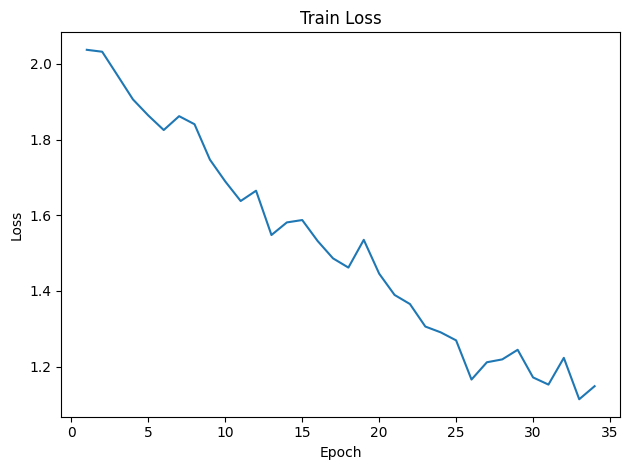

<Figure size 640x480 with 0 Axes>

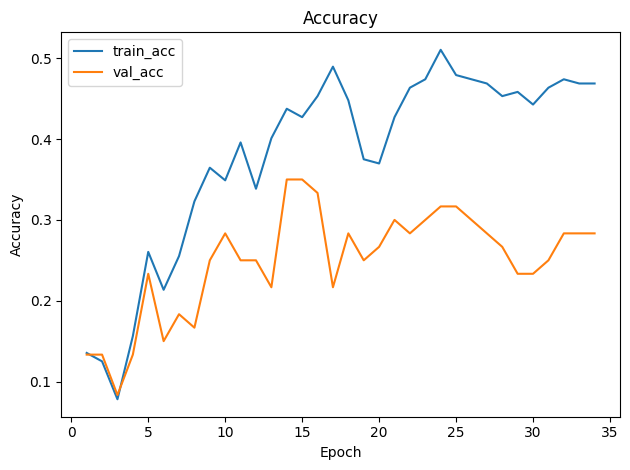

<Figure size 640x480 with 0 Axes>

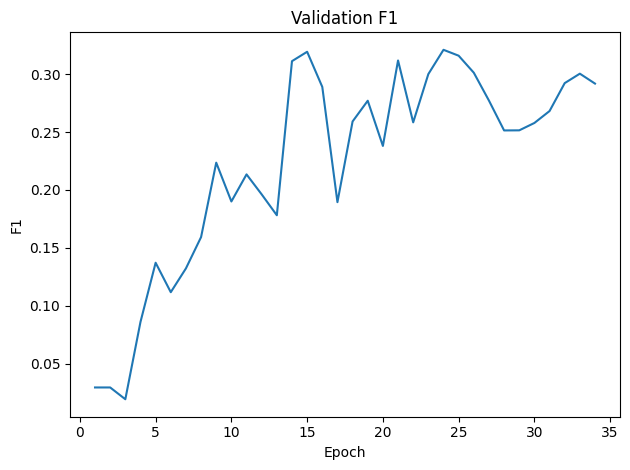


Test Confusion Matrix (counts):
[[2 1 2 0 0 0 2 0]
 [3 0 3 0 0 0 1 0]
 [1 0 1 2 0 0 1 1]
 [0 2 0 1 0 1 0 2]
 [0 0 1 0 0 0 0 1]
 [0 0 0 1 0 2 0 0]
 [0 1 2 0 0 0 3 0]
 [0 1 1 2 0 0 1 1]]


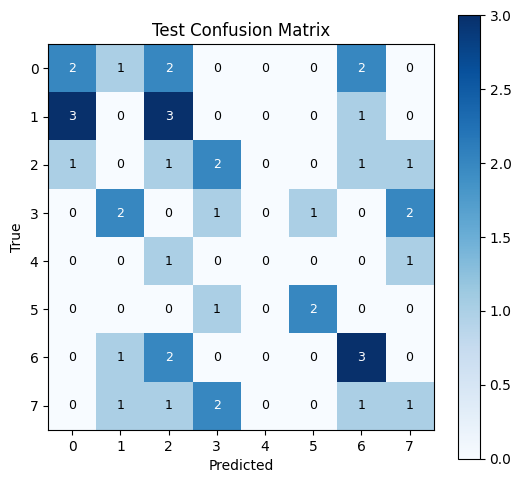

[Fold1] Best val acc=0.350 @ ep14 | Test acc=0.233, prec=0.230, rec=0.244, F1=0.235

Model 6 (Multi-Stream Dilated TCN) | Fold 2
[Fold2] Ep001 tr_loss=2.0909 tr_acc=0.151 val_acc=0.138 val_f1=0.030 | best=0.138@1
[Fold2] Ep005 tr_loss=1.9482 tr_acc=0.219 val_acc=0.207 val_f1=0.107 | best=0.207@5
[Fold2] Ep010 tr_loss=1.7317 tr_acc=0.318 val_acc=0.293 val_f1=0.200 | best=0.310@9
[Fold2] Ep015 tr_loss=1.5374 tr_acc=0.391 val_acc=0.379 val_f1=0.300 | best=0.379@14
[Fold2] Ep020 tr_loss=1.4639 tr_acc=0.448 val_acc=0.397 val_f1=0.352 | best=0.414@19
[Fold2] Ep025 tr_loss=1.2925 tr_acc=0.411 val_acc=0.379 val_f1=0.326 | best=0.466@23
[Fold2] Ep030 tr_loss=1.1152 tr_acc=0.375 val_acc=0.397 val_f1=0.319 | best=0.466@23
[Fold2] Ep035 tr_loss=0.9896 tr_acc=0.354 val_acc=0.379 val_f1=0.325 | best=0.483@33
[Fold2] Ep040 tr_loss=0.8458 tr_acc=0.484 val_acc=0.466 val_f1=0.398 | best=0.483@33
[Fold2] Ep045 tr_loss=0.6956 tr_acc=0.594 val_acc=0.534 val_f1=0.437 | best=0.552@44
[Fold2] Ep050 tr_loss=0.

<Figure size 640x480 with 0 Axes>

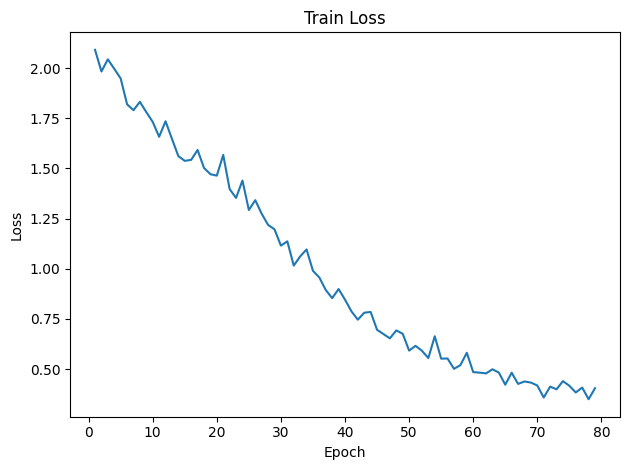

<Figure size 640x480 with 0 Axes>

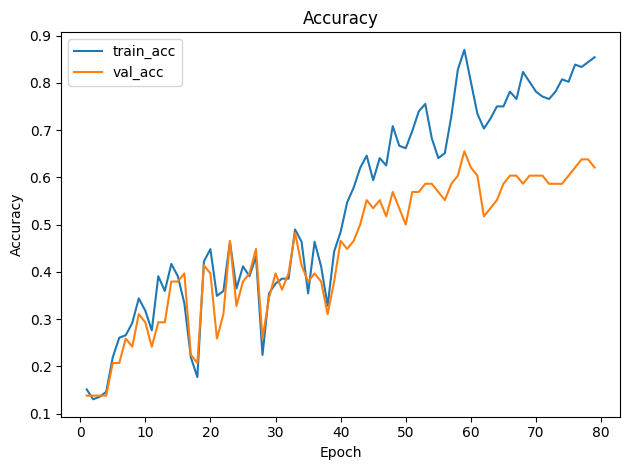

<Figure size 640x480 with 0 Axes>

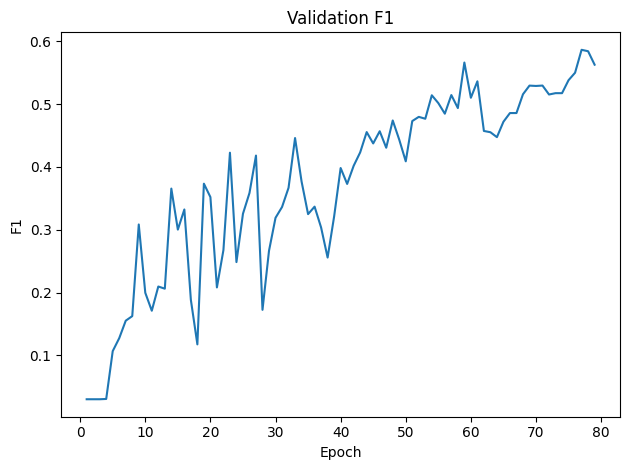


Test Confusion Matrix (counts):
[[7 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0]
 [0 0 0 6 0 0 0 0]
 [0 0 0 0 1 0 0 1]
 [0 0 0 2 0 1 0 0]
 [0 3 0 0 1 0 2 0]
 [0 1 0 0 0 0 0 5]]


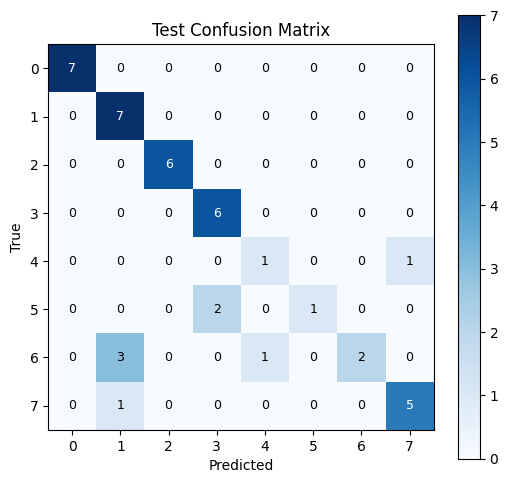

[Fold2] Best val acc=0.655 @ ep59 | Test acc=0.814, prec=0.840, rec=0.750, F1=0.746

Model 6 (Multi-Stream Dilated TCN) | Fold 3
[Fold3] Ep001 tr_loss=2.0269 tr_acc=0.146 val_acc=0.140 val_f1=0.031 | best=0.140@1
[Fold3] Ep005 tr_loss=1.8647 tr_acc=0.208 val_acc=0.175 val_f1=0.091 | best=0.175@4
[Fold3] Ep010 tr_loss=1.6850 tr_acc=0.354 val_acc=0.211 val_f1=0.145 | best=0.281@8
[Fold3] Ep015 tr_loss=1.4978 tr_acc=0.432 val_acc=0.316 val_f1=0.283 | best=0.333@12
[Fold3] Ep020 tr_loss=1.3726 tr_acc=0.453 val_acc=0.281 val_f1=0.225 | best=0.351@17
[Fold3] Ep025 tr_loss=1.2992 tr_acc=0.422 val_acc=0.263 val_f1=0.219 | best=0.351@17
[Fold3] Ep030 tr_loss=1.0718 tr_acc=0.422 val_acc=0.316 val_f1=0.279 | best=0.351@17
[Fold3] Ep035 tr_loss=1.0658 tr_acc=0.490 val_acc=0.281 val_f1=0.271 | best=0.351@17
[Fold3] Early stopping at epoch 37 (no val improvement for 20 epochs)


<Figure size 640x480 with 0 Axes>

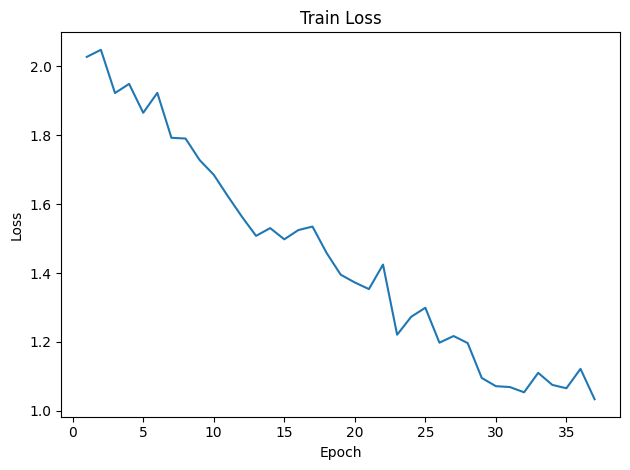

<Figure size 640x480 with 0 Axes>

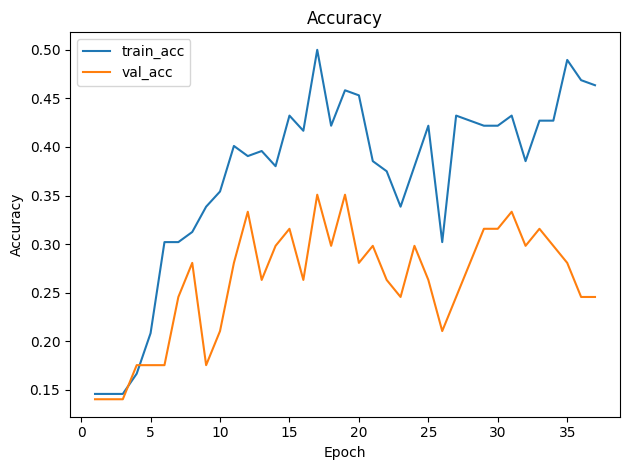

<Figure size 640x480 with 0 Axes>

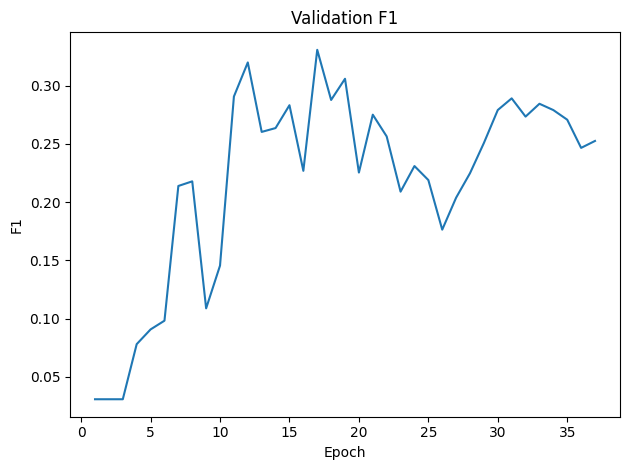


Test Confusion Matrix (counts):
[[3 1 0 1 0 0 2 0]
 [1 5 0 1 0 0 0 0]
 [1 0 0 3 1 0 0 1]
 [0 0 0 5 0 1 0 0]
 [0 0 0 1 0 0 0 1]
 [0 0 0 0 0 3 0 0]
 [1 2 0 0 0 0 2 1]
 [0 0 0 1 0 2 0 3]]


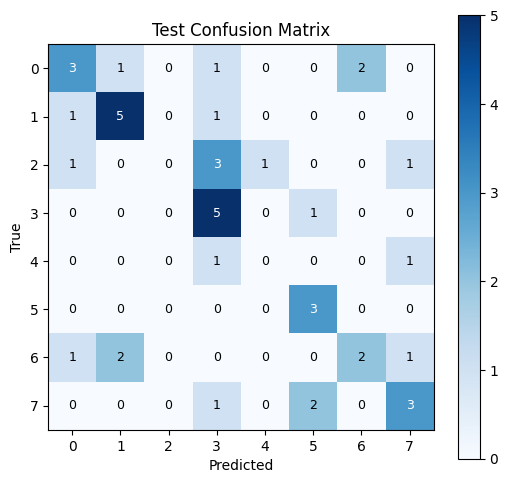

[Fold3] Best val acc=0.351 @ ep17 | Test acc=0.488, prec=0.380, rec=0.476, F1=0.406

Model 6 (Multi-Stream Dilated TCN) | Fold 4
[Fold4] Ep001 tr_loss=2.0723 tr_acc=0.141 val_acc=0.148 val_f1=0.032 | best=0.148@1
[Fold4] Ep005 tr_loss=1.9371 tr_acc=0.219 val_acc=0.259 val_f1=0.162 | best=0.259@5
[Fold4] Ep010 tr_loss=1.7688 tr_acc=0.312 val_acc=0.296 val_f1=0.236 | best=0.296@10
[Fold4] Ep015 tr_loss=1.5911 tr_acc=0.375 val_acc=0.389 val_f1=0.334 | best=0.481@13
[Fold4] Ep020 tr_loss=1.5033 tr_acc=0.292 val_acc=0.241 val_f1=0.203 | best=0.481@13
[Fold4] Ep025 tr_loss=1.4076 tr_acc=0.307 val_acc=0.259 val_f1=0.222 | best=0.481@13
[Fold4] Ep030 tr_loss=1.3428 tr_acc=0.427 val_acc=0.370 val_f1=0.335 | best=0.481@13
[Fold4] Early stopping at epoch 33 (no val improvement for 20 epochs)


<Figure size 640x480 with 0 Axes>

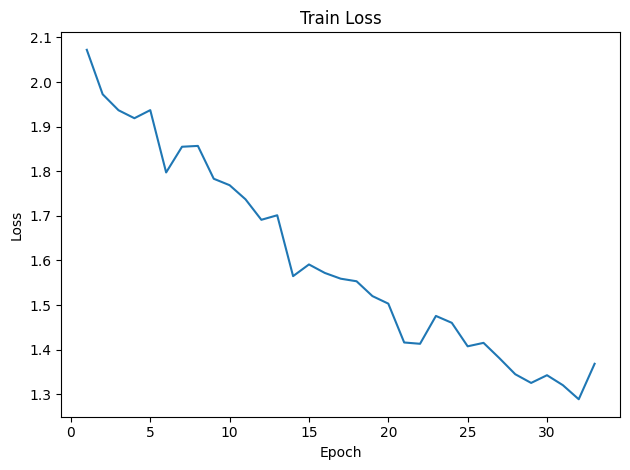

<Figure size 640x480 with 0 Axes>

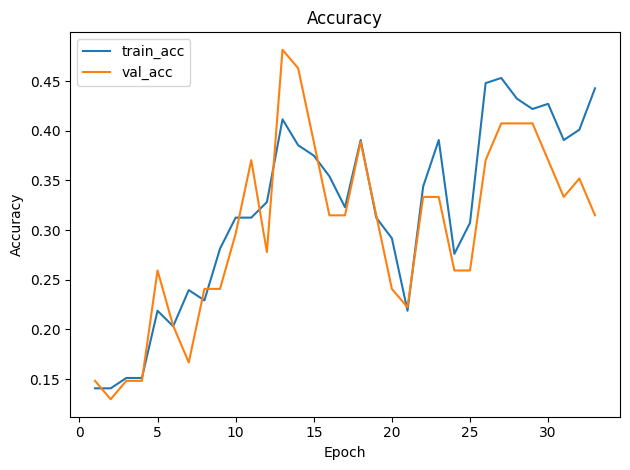

<Figure size 640x480 with 0 Axes>

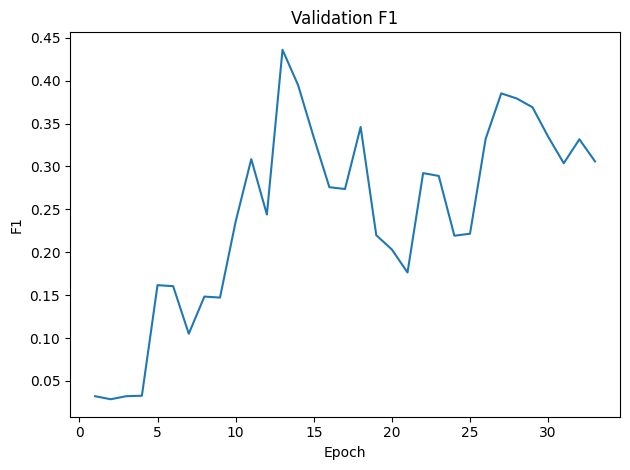


Test Confusion Matrix (counts):
[[3 0 1 0 0 0 3 0]
 [2 3 1 0 0 0 1 0]
 [1 1 0 2 0 0 1 1]
 [0 3 0 0 0 1 0 2]
 [0 0 0 1 0 0 0 1]
 [0 0 0 0 0 3 0 0]
 [1 4 0 0 0 0 1 0]
 [0 1 1 2 1 0 0 1]]


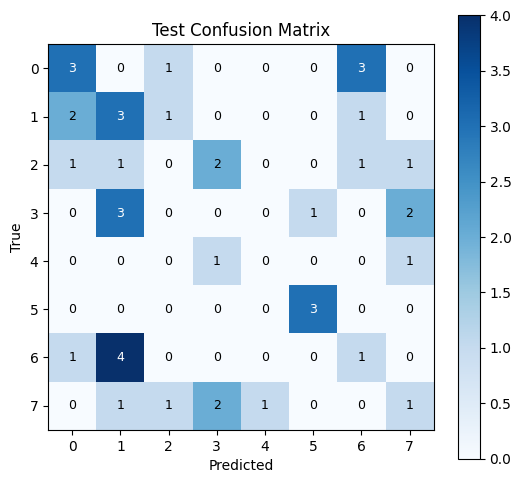

[Fold4] Best val acc=0.481 @ ep13 | Test acc=0.256, prec=0.224, rec=0.274, F1=0.244

Model 6 (Multi-Stream Dilated TCN) | Fold 5
[Fold5] Ep001 tr_loss=2.0888 tr_acc=0.146 val_acc=0.151 val_f1=0.033 | best=0.151@1
[Fold5] Ep005 tr_loss=1.8874 tr_acc=0.219 val_acc=0.208 val_f1=0.151 | best=0.208@5
[Fold5] Ep010 tr_loss=1.8110 tr_acc=0.281 val_acc=0.245 val_f1=0.179 | best=0.264@8
[Fold5] Ep015 tr_loss=1.6578 tr_acc=0.245 val_acc=0.208 val_f1=0.188 | best=0.264@8
[Fold5] Ep020 tr_loss=1.6213 tr_acc=0.188 val_acc=0.208 val_f1=0.153 | best=0.377@18
[Fold5] Ep025 tr_loss=1.4260 tr_acc=0.354 val_acc=0.321 val_f1=0.269 | best=0.377@18
[Fold5] Ep030 tr_loss=1.3349 tr_acc=0.354 val_acc=0.283 val_f1=0.197 | best=0.377@18
[Fold5] Ep035 tr_loss=1.3620 tr_acc=0.312 val_acc=0.340 val_f1=0.276 | best=0.377@18
[Fold5] Early stopping at epoch 38 (no val improvement for 20 epochs)


<Figure size 640x480 with 0 Axes>

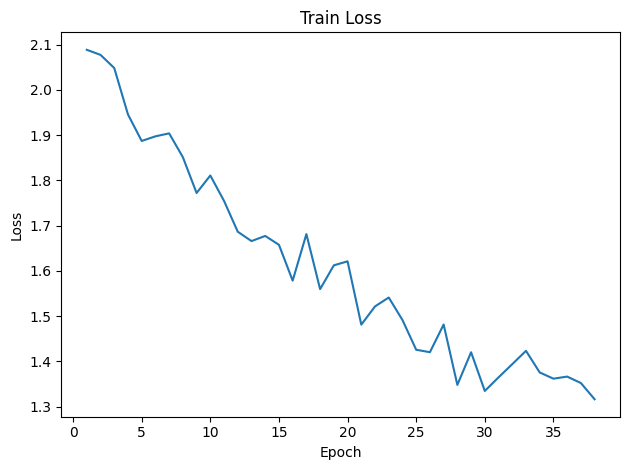

<Figure size 640x480 with 0 Axes>

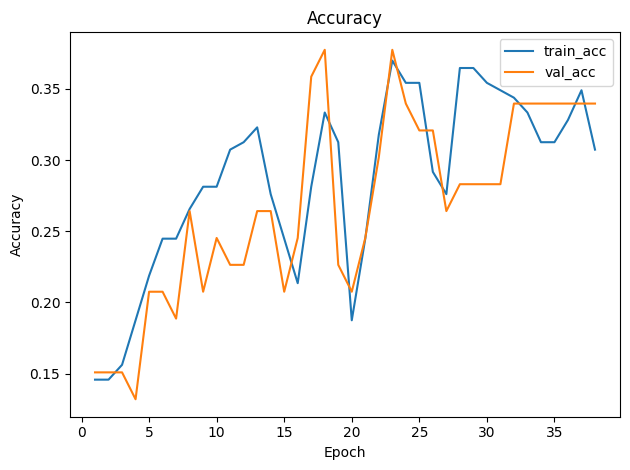

<Figure size 640x480 with 0 Axes>

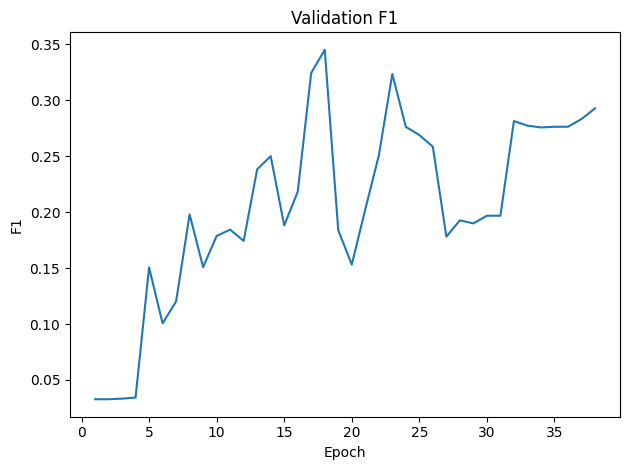


Test Confusion Matrix (counts):
[[2 3 0 0 0 0 1 1]
 [1 5 0 1 0 0 0 0]
 [1 0 1 4 0 0 0 0]
 [0 0 1 3 0 2 0 0]
 [0 0 0 2 0 0 0 0]
 [0 0 0 0 0 3 0 0]
 [0 2 3 0 0 0 0 1]
 [0 0 1 4 0 0 0 1]]


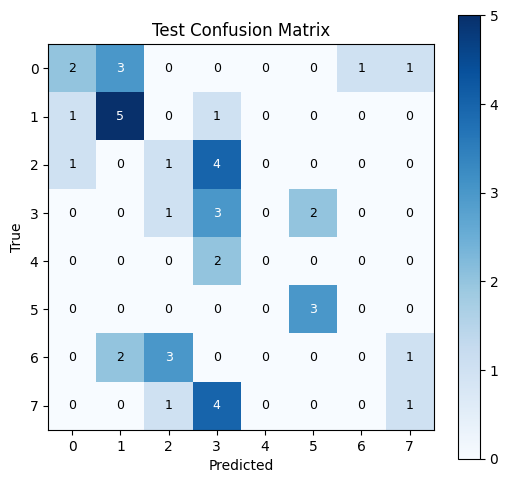

[Fold5] Best val acc=0.377 @ ep18 | Test acc=0.349, prec=0.289, rec=0.354, F1=0.299

Summary saved: /content/drive/MyDrive/ml_runs/sbu_models/Model_6_MultiStream_DilatedTCN/outputs/summary.csv
       Best Val Acc  Best Epoch  Test Acc  Test Precision (macro)  \
Fold1      0.350000        14.0  0.232558                0.230208   
Fold2      0.655172        59.0  0.813953                0.839962   
Fold3      0.350877        17.0  0.488372                0.380208   
Fold4      0.481481        13.0  0.255814                0.224405   
Fold5      0.377358        18.0  0.348837                0.289286   
Mean       0.442978        24.2  0.427907                0.392814   

       Test Recall (macro)  Test F1 (macro)  Test Precision (weighted)  \
Fold1             0.244048         0.234552                   0.218217   
Fold2             0.750000         0.746032                   0.859408   
Fold3             0.476190         0.406303                   0.415698   
Fold4             0.273810 

In [6]:
# /content/drive/MyDrive/ml_runs/sbu_models/Model_6_MultiStream_DilatedTCN/train.py

import os, json, pickle, random
from pathlib import Path
from typing import Any, Dict, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)


# Reproducibility and device

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # cuDNN settings chosen for speed; not fully deterministic
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Paths and training knobs

DATA_ROOT = Path("/content/drive/MyDrive/ml_runs/sbu_hybrid_colab/data/sbu")
WORK_ROOT = Path("/content/drive/MyDrive/ml_runs/sbu_models/Model_6_MultiStream_DilatedTCN/outputs")
WORK_ROOT.mkdir(parents=True, exist_ok=True)

EPOCHS       = 200
PATIENCE     = 20
BATCH_SIZE   = 64
LR           = 1e-3
WEIGHT_DECAY = 0.0
NUM_WORKERS  = 2
PIN_MEMORY   = torch.cuda.is_available()

# Model sizing kept aligned with earlier variants
TCN_HIDDEN        = [128, 256, 256]
TCN_KERNEL        = 3
TCN_DILATIONS     = [1, 2, 4, 8]
DROPOUT           = 0.25
FUSE_SE_REDUCTION = 4

# Persist key hyperparameters for traceability
with open(WORK_ROOT/"hyperparams.json","w") as f:
    json.dump({
        "epochs":EPOCHS,"patience":PATIENCE,"batch_size":BATCH_SIZE,
        "lr":LR,"weight_decay":WEIGHT_DECAY,"num_workers":NUM_WORKERS,
        "tcn":{
            "hidden":TCN_HIDDEN,"kernel":TCN_KERNEL,
            "dilations":TCN_DILATIONS,"dropout":DROPOUT
        },
        "fuse":{"se_reduction":FUSE_SE_REDUCTION}
    }, f, indent=2)

def fold_paths(k:int)->Dict[str, Path]:
    d = DATA_ROOT / f"fold{k}"
    return {
        "train_x": d/"train_data.npy", "train_y": d/"train_label.pkl",
        "val_x":   d/"val_data.npy",   "val_y":   d/"val_label.pkl",
        "test_x":  d/"test_data.npy",  "test_y":  d/"test_label.pkl"
    }


# Label helpers
-
def _first_int(x: Any):
    if isinstance(x, (int, np.integer)): return int(x)
    if isinstance(x, str):
        import re
        m = re.search(r"-?\d+", x)
        if m: return int(m.group(0))
        return None
    return None

def _to_int_list(seq: Any) -> List[int]:
    if isinstance(seq, np.ndarray):
        if seq.dtype.kind in "iu":
            return seq.astype(np.int64).tolist()
        seq = seq.tolist()
    if isinstance(seq, (list, tuple)):
        out = []
        for it in seq:
            v = _first_int(it)
            if v is None:
                raise ValueError(f"Label element not int-like: {repr(it)[:120]}")
            out.append(v)
        return out
    raise ValueError(f"Unsupported label container: {type(seq).__name__}")

def load_labels(y_path: Path, expected_N: int) -> np.ndarray:
    with open(y_path, "rb") as f:
        obj = pickle.load(f)


    if isinstance(obj, np.ndarray) and obj.ndim == 1 and obj.size == expected_N and obj.dtype.kind in "iu":
        y = obj.astype(np.int64)
    elif isinstance(obj, (list, tuple)) and len(obj) == expected_N and all(isinstance(e, (int, np.integer)) for e in obj):
        y = np.asarray(obj, dtype=np.int64)
    elif isinstance(obj, (list, tuple)) and len(obj) == 2:
        cand = obj[0]
        if isinstance(cand, (list, tuple, np.ndarray)):
            labels = _to_int_list(cand)
            if len(labels) != expected_N:
                raise ValueError(f"First element length {len(labels)} != N {expected_N} in {y_path}")
            y = np.asarray(labels, dtype=np.int64)
        else:
            raise ValueError(f"First element not list-like in {y_path}: {type(cand).__name__}")
    elif isinstance(obj, dict):
        for k in ["labels","y","targets"]:
            if k in obj:
                labels = _to_int_list(obj[k])
                if len(labels) != expected_N:
                    raise ValueError(f"dict['{k}'] length {len(labels)} != N {expected_N}")
                y = np.asarray(labels, dtype=np.int64)
                break
        else:
            raise ValueError(f"Unsupported dict label format keys={list(obj.keys())[:10]}")
    else:
        raise ValueError(f"Unsupported label.pkl type: {type(obj).__name__}")

    # Remap to a compact 0..C-1 if needed
    uniq = np.unique(y)
    if not np.array_equal(uniq, np.arange(int(uniq.max())+1)):
        mapping = {int(c):i for i,c in enumerate(sorted(uniq))}
        y = np.vectorize(lambda z: mapping[int(z)])(y).astype(np.int64)
    return y


# Dataset

class SBUFoldDataset(torch.utils.data.Dataset):
    def __init__(self, x_path: Path, y_path: Path):
        x = np.load(x_path)
        if x.ndim == 4:
            x = x[..., None]
        self.x = x
        N = self.x.shape[0]
        y = load_labels(y_path, expected_N=N)
        if len(y) != N:
            raise ValueError(f"N mismatch for {x_path.name}: X={N} y={len(y)}")
        self.y = y
    def __len__(self): return self.x.shape[0]
    def __getitem__(self, idx):
        return torch.from_numpy(self.x[idx]).float(), int(self.y[idx])


# Graph utilities (ST-GCN style)

def _normalize_adjacency(A: torch.Tensor) -> torch.Tensor:
    # A: [K, V, V] -> D^{-1/2} A D^{-1/2} per partition
    K, V, _ = A.shape
    An = []
    for k in range(K):
        a = A[k]
        deg = a.sum(dim=1)
        deg[deg == 0] = 1.0
        d_inv_sqrt = torch.pow(deg, -0.5)
        d_mat = torch.diag(d_inv_sqrt)
        an = d_mat @ a @ d_mat
        An.append(an)
    return torch.stack(An, dim=0)

def _sbu_edges_or_chain(V: int):

    if V == 15:
        edges = [
            (0,1),(1,2),(2,3),      # right arm
            (0,4),(4,5),(5,6),      # left arm
            (0,7),(7,8),(8,9),      # spine to head
            (7,10),(10,11),(11,12), # right leg
            (7,13),(13,14)          # left leg
        ]
    else:
        edges = [(i, i+1) for i in range(V-1)]
    return edges

def build_partitions(V: int) -> torch.Tensor:
    # Three partitions: self, inward, outward
    self_links = [(i, i) for i in range(V)]
    edges = _sbu_edges_or_chain(V)
    inward  = edges
    outward = [(j,i) for (i,j) in edges]

    A = torch.zeros(3, V, V, dtype=torch.float32)
    for i,j in self_links: A[0, i, j] = 1.0
    for i,j in inward:    A[1, i, j] = 1.0
    for i,j in outward:   A[2, i, j] = 1.0
    return _normalize_adjacency(A)


# ST-GCN components

class SpatialGraphConv(nn.Module):
    # Sum over partitions, then 1x1 to mix channels
    def __init__(self, in_ch, out_ch, K=3, bias=False):
        super().__init__()
        self.K = K
        self.theta = nn.Conv2d(in_ch*K, out_ch, kernel_size=1, bias=bias)

    def forward(self, x, A):
        # x: [N,C,T,V], A: [K,V,V]
        N, C, T, V = x.shape
        K = A.shape[0]
        assert K == self.K, f"Partition mismatch: model K={self.K}, A K={K}"
        xs = []
        for k in range(K):
            xk = torch.einsum('nctv,vw->nctw', x, A[k])  # graph message passing
            xs.append(xk)
        x_cat = torch.cat(xs, dim=1)        # [N, C*K, T, V]
        out = self.theta(x_cat)             # [N, out_ch, T, V]
        return out

class TemporalDilatedConv(nn.Module):
    # 1×k temporal conv with dilation, BN, ReLu
    def __init__(self, ch, k=3, d=1, p_drop=0.25):
        super().__init__()
        pad = d * (k - 1) // 2
        self.conv = nn.Conv2d(ch, ch, kernel_size=(k,1), padding=(pad,0), dilation=(d,1))
        self.bn   = nn.BatchNorm2d(ch)
        self.drop = nn.Dropout2d(p_drop) if p_drop>0 else nn.Identity()
    def forward(self, x):
        y = self.conv(x)
        y = F.relu(self.bn(y), inplace=True)
        y = self.drop(y)
        return y

class STGCN_Block(nn.Module):
    # Spatial step then temporal step, with residual to stabilize training
    def __init__(self, in_ch, out_ch, k_t=3, dilation=1, p_drop=0.25, K=3):
        super().__init__()
        self.sgcn = SpatialGraphConv(in_ch, out_ch, K=K, bias=False)
        self.tcn  = TemporalDilatedConv(out_ch, k=k_t, d=dilation, p_drop=p_drop)
        self.res  = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        self.bn   = nn.BatchNorm2d(out_ch)

    def forward(self, x, A):
        y = self.sgcn(x, A)
        y = self.tcn(y)
        y = y + self.res(x)
        return F.relu(self.bn(y), inplace=True)

class StreamSTGCN_Dilated(nn.Module):
    # Per-stream encoder; channel widths and dilations mirror TCN settings
    def __init__(self, in_ch:int, V:int, hidden:List[int], k_t:int, dilations:List[int], p_drop:float):
        super().__init__()
        self.V = V
        self.A = nn.Parameter(build_partitions(V), requires_grad=False)  # [3,V,V]
        layers = []
        ch_in = in_ch
        for ch_out in hidden:
            for d in dilations:
                layers.append(STGCN_Block(ch_in, ch_out, k_t=k_t, dilation=d, p_drop=p_drop, K=self.A.shape[0]))
                ch_in = ch_out
        self.net = nn.ModuleList(layers)
        self.out_dim = ch_in

    def forward(self, x):  # x: [N,C,T,V]
        for blk in self.net:
            x = blk(x, self.A)

        x = x.mean(dim=2).mean(dim=2)
        return x

class SEGate(nn.Module):

    def __init__(self, in_dim, reduction=4):
        super().__init__()
        rd = max(1, in_dim // reduction)
        self.fc1 = nn.Linear(in_dim, rd)
        self.fc2 = nn.Linear(rd, in_dim)
    def forward(self, x):
        s = x.mean(dim=0, keepdim=True)
        w = torch.sigmoid(self.fc2(F.relu(self.fc1(s))))
        return x * w

class MultiStreamDilatedTCN(nn.Module):
    # ST-GCN backbone per stream; features fused then classified
    def __init__(self, in_ch:int, T:int, V:int, M:int, num_class:int,
                 hidden=TCN_HIDDEN, kernel=TCN_KERNEL, dilations=TCN_DILATIONS,
                 dropout=DROPOUT, se_reduction=FUSE_SE_REDUCTION):
        super().__init__()
        self.in_ch=in_ch; self.T=T; self.V=V; self.M=M

        # Shared encoder across streams
        self.encoder = StreamSTGCN_Dilated(
            in_ch=in_ch, V=V, hidden=hidden, k_t=kernel, dilations=dilations, p_drop=dropout
        )

        fused_dim = self.encoder.out_dim * M
        self.se = SEGate(fused_dim, reduction=se_reduction) if M>1 else nn.Identity()
        self.bn = nn.BatchNorm1d(fused_dim)
        self.head = nn.Sequential(
            nn.Linear(fused_dim, fused_dim//2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(fused_dim//2, num_class)
        )

    def forward(self, x):  # [N, C, T, V, M]
        N, C, T, V, M = x.shape
        assert (C,T,V,M) == (self.in_ch,self.T,self.V,self.M), f"Shape mismatch: got {x.shape}"
        feats = []
        for m in range(M):
            xm = x[..., m]             # [N,C,T,V]
            em = self.encoder(xm)      # [N, D]
            feats.append(em)
        z = torch.cat(feats, dim=1)     # [N, D*M]
        if isinstance(self.se, SEGate):
            z = self.se(z)
        z = self.bn(z)
        return self.head(z)


# Evaluation and plotting

@torch.no_grad()
def eval_loader(model, loader):
    model.eval()
    all_t, all_p = [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        out = model(xb)
        pred = out.argmax(1)
        all_t.extend(yb.cpu().numpy().tolist())
        all_p.extend(pred.cpu().numpy().tolist())
    acc   = accuracy_score(all_t, all_p)
    prec  = precision_score(all_t, all_p, average="macro",    zero_division=0)
    rec   = recall_score(all_t, all_p, average="macro",       zero_division=0)
    f1    = f1_score(all_t, all_p, average="macro",           zero_division=0)
    precw = precision_score(all_t, all_p, average="weighted", zero_division=0)
    recw  = recall_score(all_t, all_p, average="weighted",    zero_division=0)
    f1w   = f1_score(all_t, all_p, average="weighted",        zero_division=0)
    cm    = confusion_matrix(all_t, all_p)
    rep   = classification_report(all_t, all_p, output_dict=True, zero_division=0)
    return {
        "acc":acc, "prec":prec, "rec":rec, "f1":f1,
        "prec_w":precw, "rec_w":recw, "f1_w":f1w,
        "cm":cm, "rep":rep
    }

def plot_curves(history, out_dir: Path):
    df = pd.DataFrame(history)
    out_dir.mkdir(parents=True, exist_ok=True)

    # Train loss
    plt.figure()
    df[["epoch","train_loss"]].set_index("epoch").plot(legend=False)
    plt.title("Train Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.tight_layout(); plt.savefig(out_dir/"loss.png", dpi=150); plt.show()

    # Accuracy (train vs val)
    plt.figure()
    df[["epoch","train_acc","val_acc"]].set_index("epoch").plot()
    plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.tight_layout(); plt.savefig(out_dir/"val_acc.png", dpi=150); plt.show()

    # Validation F1
    plt.figure()
    df[["epoch","val_f1"]].set_index("epoch").plot(legend=False)
    plt.title("Validation F1"); plt.xlabel("Epoch"); plt.ylabel("F1")
    plt.tight_layout(); plt.savefig(out_dir/"val_f1.png", dpi=150); plt.show()

def plot_confusion(cm: np.ndarray, out_path: Path, title="Confusion Matrix"):
    plt.figure(figsize=(5.5,5))
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title); plt.colorbar()
    ticks = np.arange(cm.shape[0])
    plt.xticks(ticks, ticks); plt.yticks(ticks, ticks)
    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            plt.text(j, i, str(val), ha="center", va="center",
                     color="white" if val > thresh else "black", fontsize=9)
    plt.ylabel("True"); plt.xlabel("Predicted")
    plt.tight_layout(); plt.savefig(out_path, dpi=150); plt.show()


# One-fold train/validate/test

def train_fold(k:int, epochs=EPOCHS, patience=PATIENCE, batch_size=BATCH_SIZE, lr=LR):
    paths = fold_paths(k)
    out_dir = WORK_ROOT/f"fold{k}"; out_dir.mkdir(parents=True, exist_ok=True)

    # Data
    tr_ds = SBUFoldDataset(paths["train_x"], paths["train_y"])
    va_ds = SBUFoldDataset(paths["val_x"], paths["val_y"])
    te_ds = SBUFoldDataset(paths["test_x"], paths["test_y"])

    tr_ld = DataLoader(tr_ds, batch_size=batch_size, shuffle=True,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=True)
    va_ld = DataLoader(va_ds, batch_size=batch_size, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    te_ld = DataLoader(te_ds, batch_size=batch_size, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    # Shapes and classes
    C = tr_ds.x.shape[1]
    T = tr_ds.x.shape[2]
    V = tr_ds.x.shape[3]
    M = tr_ds.x.shape[4]
    num_class = int(max(tr_ds.y.max(), va_ds.y.max(), te_ds.y.max()) + 1)

    # Store label stats for quick checks
    with open(out_dir/"label_summary.json","w") as f:
        json.dump({
            "train_unique": sorted(list(map(int, np.unique(tr_ds.y)))),
            "val_unique":   sorted(list(map(int, np.unique(va_ds.y)))),
            "test_unique":  sorted(list(map(int, np.unique(te_ds.y)))),
            "num_class":    int(num_class),
            "streams":      int(M)
        }, f, indent=2)

    # Model + optimizer + scheduler
    model = MultiStreamDilatedTCN(in_ch=C, T=T, V=V, M=M, num_class=num_class,
                                  hidden=TCN_HIDDEN, kernel=TCN_KERNEL,
                                  dilations=TCN_DILATIONS, dropout=DROPOUT,
                                  se_reduction=FUSE_SE_REDUCTION).to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", patience=4, factor=0.5)

    best_val, best_ep, no_improve = -1.0, -1, 0
    history = []
    best_path = out_dir/"best.pt"

    # Training loop
    for ep in range(1, epochs+1):
        model.train()
        n, loss_sum = 0, 0.0
        for xb, yb in tr_ld:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            out = model(xb)
            loss = F.cross_entropy(out, yb)
            loss.backward()
            opt.step()
            loss_sum += loss.item() * yb.size(0)
            n += yb.size(0)

        tr_loss = loss_sum / max(1,n)
        tr_eval = eval_loader(model, tr_ld)
        va_eval = eval_loader(model, va_ld)

        # Plateau scheduler on validation accuracy
        sched.step(va_eval["acc"])

        history.append({"epoch":ep, "train_loss":tr_loss,
                        "train_acc":tr_eval["acc"], "val_acc":va_eval["acc"], "val_f1":va_eval["f1"]})

        # Track best validation accuracy
        if va_eval["acc"] > best_val + 1e-8:
            best_val = va_eval["acc"]
            best_ep = ep
            no_improve = 0
            torch.save({"model": model.state_dict()}, best_path)
            np.savetxt(out_dir/"cm_val_best.csv", va_eval["cm"].astype(int), fmt="%d", delimiter=",")
            pd.DataFrame(va_eval["rep"]).to_csv(out_dir/"report_val_best.csv")
            with open(out_dir/"best.json","w") as f:
                json.dump({"best_epoch": int(best_ep), "best_val_acc": float(best_val)}, f, indent=2)
        else:
            no_improve += 1

        # Periodic progress log + history snapshot
        if ep == 1 or ep % 5 == 0:
            pd.DataFrame(history).to_csv(out_dir/"history.csv", index=False)
            print(f"[Fold{k}] Ep{ep:03d} tr_loss={tr_loss:.4f} tr_acc={tr_eval['acc']:.3f} "
                  f"val_acc={va_eval['acc']:.3f} val_f1={va_eval['f1']:.3f} | best={best_val:.3f}@{best_ep}")

        # Early stop on patience
        if no_improve >= patience:
            print(f"[Fold{k}] Early stopping at epoch {ep} (no val improvement for {patience} epochs)")
            break

    # Final history dump + curves
    pd.DataFrame(history).to_csv(out_dir/"history.csv", index=False)
    plot_curves(history, out_dir)

    # Load best weights and evaluate on test set
    state = torch.load(best_path, map_location="cpu")
    model.load_state_dict(state["model"])

    te = eval_loader(model, te_ld)
    np.savetxt(out_dir/"cm_test.csv", te["cm"].astype(int), fmt="%d", delimiter=",")
    pd.DataFrame(te["rep"]).to_csv(out_dir/"report_test.csv")
    with open(out_dir/"results.json","w") as f:
        json.dump({
            "best_val_acc": float(best_val), "best_epoch": int(best_ep),
            "test_acc": float(te["acc"]),
            "test_precision_macro": float(te["prec"]),
            "test_recall_macro": float(te["rec"]),
            "test_f1_macro": float(te["f1"]),
            "test_precision_weighted": float(te["prec_w"]),
            "test_recall_weighted": float(te["rec_w"]),
            "test_f1_weighted": float(te["f1_w"]),
            "streams_used": int(M)
        }, f, indent=2)

    # Quick console summary and plot
    print("\nTest Confusion Matrix (counts):")
    print(te["cm"])
    plot_confusion(te["cm"], out_dir/"cm_test.png", title="Test Confusion Matrix")

    print(f"[Fold{k}] Best val acc={best_val:.3f} @ ep{best_ep} | "
          f"Test acc={te['acc']:.3f}, prec={te['prec']:.3f}, rec={te['rec']:.3f}, F1={te['f1']:.3f}")

    return {
        "best_val_acc": best_val,
        "best_epoch": best_ep,
        "test_acc": te["acc"],
        "test_precision_macro": te["prec"],
        "test_recall_macro": te["rec"],
        "test_f1_macro": te["f1"],
        "test_precision_weighted": te["prec_w"],
        "test_recall_weighted": te["rec_w"],
        "test_f1_weighted": te["f1_w"]
    }


# Run all folds and summarize

def run_all():
    rows = []
    for k in range(1,6):
        print(f"\nModel 6 (Multi-Stream Dilated TCN) | Fold {k}")
        r = train_fold(k)
        rows.append([
            r["best_val_acc"], r["best_epoch"], r["test_acc"],
            r["test_precision_macro"], r["test_recall_macro"], r["test_f1_macro"],
            r["test_precision_weighted"], r["test_recall_weighted"], r["test_f1_weighted"]
        ])
    cols = [
        "Best Val Acc","Best Epoch","Test Acc",
        "Test Precision (macro)","Test Recall (macro)","Test F1 (macro)",
        "Test Precision (weighted)","Test Recall (weighted)","Test F1 (weighted)"
    ]
    df = pd.DataFrame(rows, columns=cols, index=[f"Fold{i}" for i in range(1,6)])
    df.loc["Mean"] = df.mean(numeric_only=True).to_dict()
    df.to_csv(WORK_ROOT/"summary.csv", index=True)
    print("\nSummary saved:", WORK_ROOT/"summary.csv")
    print(df)

if __name__ == "__main__":
    run_all()


In [8]:
# /content/drive/MyDrive/ml_runs/sbu_models/Model_7_MultiStream_SE/train.py

import os, json, pickle, random
from pathlib import Path
from typing import Any, Dict, List
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)


# seeds / device

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True
set_seed(42)

DEVICE = "cuda"
PIN_MEMORY = True


# paths

DATA_ROOT = Path("/content/drive/MyDrive/ml_runs/sbu_hybrid_colab/data/sbu")
WORK_ROOT = Path("/content/drive/MyDrive/ml_runs/sbu_models/Model_7_MultiStream_SE/outputs")
WORK_ROOT.mkdir(parents=True, exist_ok=True)

# hyperparams
-
EPOCHS       = 200
PATIENCE     = 20
BATCH_SIZE   = 64
LR           = 1e-3
WEIGHT_DECAY = 0.0
NUM_WORKERS  = 2


STREAM_DIMS       = [64, 128, 256]
TEMP_KERNEL       = 9
DROPOUT           = 0.25
FUSE_SE_REDUCTION = 4

with open(WORK_ROOT/"hyperparams.json","w") as f:
    json.dump({
        "epochs":EPOCHS,"patience":PATIENCE,"batch_size":BATCH_SIZE,
        "lr":LR,"weight_decay":WEIGHT_DECAY,"num_workers":NUM_WORKERS,
        "stream":{"dims":STREAM_DIMS,"temp_kernel":TEMP_KERNEL,"dropout":DROPOUT},
        "fuse":{"se_reduction":FUSE_SE_REDUCTION}
    }, f, indent=2)


# data utils

def fold_paths(k:int)->Dict[str, Path]:
    d = DATA_ROOT / f"fold{k}"
    return {
        "train_x": d/"train_data.npy", "train_y": d/"train_label.pkl",
        "val_x":   d/"val_data.npy",   "val_y":   d/"val_label.pkl",
        "test_x":  d/"test_data.npy",  "test_y":  d/"test_label.pkl"
    }

def _first_int(x: Any):
    if isinstance(x, (int, np.integer)): return int(x)
    if isinstance(x, str):
        import re
        m = re.search(r"-?\d+", x)
        if m: return int(m.group(0))
        return None
    return None

def _to_int_list(seq: Any) -> List[int]:
    if isinstance(seq, np.ndarray):
        if seq.dtype.kind in "iu":
            return seq.astype(np.int64).tolist()
        seq = seq.tolist()
    if isinstance(seq, (list, tuple)):
        out = []
        for it in seq:
            v = _first_int(it)
            if v is None:
                raise ValueError(f"Label element not int-like: {repr(it)[:120]}")
            out.append(v)
        return out
    raise ValueError(f"Unsupported label container: {type(seq).__name__}")

def load_labels(y_path: Path, expected_N: int) -> np.ndarray:
    with open(y_path, "rb") as f:
        obj = pickle.load(f)
    if isinstance(obj, np.ndarray) and obj.ndim == 1 and obj.size == expected_N and obj.dtype.kind in "iu":
        y = obj.astype(np.int64)
    elif isinstance(obj, (list, tuple)) and len(obj) == expected_N and all(isinstance(e, (int, np.integer)) for e in obj):
        y = np.asarray(obj, dtype=np.int64)
    elif isinstance(obj, (list, tuple)) and len(obj) == 2:
        cand = obj[0]
        if isinstance(cand, (list, tuple, np.ndarray)):
            labels = _to_int_list(cand)
            if len(labels) != expected_N:
                raise ValueError(f"First element length {len(labels)} != N {expected_N} in {y_path}")
            y = np.asarray(labels, dtype=np.int64)
        else:
            raise ValueError(f"First element not list-like in {y_path}: {type(cand).__name__}")
    elif isinstance(obj, dict):
        for k in ["labels","y","targets"]:
            if k in obj:
                labels = _to_int_list(obj[k])
                if len(labels) != expected_N:
                    raise ValueError(f"dict['{k}'] length {len(labels)} != N {expected_N}")
                y = np.asarray(labels, dtype=np.int64)
                break
        else:
            raise ValueError(f"Unsupported dict label format keys={list(obj.keys())[:10]}")
    else:
        raise ValueError(f"Unsupported label.pkl type: {type(obj).__name__}")
    uniq = np.unique(y)
    if not np.array_equal(uniq, np.arange(int(uniq.max())+1)):
        mapping = {int(c):i for i,c in enumerate(sorted(uniq))}
        y = np.vectorize(lambda z: mapping[int(z)])(y).astype(np.int64)
    return y

class SBUFoldDataset(torch.utils.data.Dataset):
    def __init__(self, x_path: Path, y_path: Path):
        x = np.load(x_path)
        if x.ndim == 4:
            x = x[..., None]
        self.x = x
        N = self.x.shape[0]
        y = load_labels(y_path, expected_N=N)
        if len(y) != N:
            raise ValueError(f"N mismatch for {x_path.name}: X={N} y={len(y)}")
        self.y = y
    def __len__(self): return self.x.shape[0]
    def __getitem__(self, idx):
        return torch.from_numpy(self.x[idx]).float(), int(self.y[idx])


# ST-GCN backbone

def _normalize_adjacency(A: torch.Tensor) -> torch.Tensor:
    # A: [K, V, V]
    K, V, _ = A.shape
    outs = []
    for k in range(K):
        a = A[k]
        deg = a.sum(dim=1)
        deg[deg == 0] = 1.0
        d_is = torch.pow(deg, -0.5)
        D = torch.diag(d_is)
        outs.append(D @ a @ D)
    return torch.stack(outs, dim=0)

def _sbu_edges_or_chain(V: int):
    if V == 15:
        edges = [
            (0,1),(1,2),(2,3),
            (0,4),(4,5),(5,6),
            (0,7),(7,8),(8,9),
            (7,10),(10,11),(11,12),
            (7,13),(13,14)
        ]
    else:
        edges = [(i, i+1) for i in range(V-1)]
    return edges

def build_partitions(V: int) -> torch.Tensor:
    # Partitions: self, inward, outward
    self_links = [(i,i) for i in range(V)]
    edges = _sbu_edges_or_chain(V)
    inward  = edges
    outward = [(j,i) for (i,j) in edges]

    A = torch.zeros(3, V, V, dtype=torch.float32)
    for i,j in self_links: A[0, i, j] = 1.0
    for i,j in inward:    A[1, i, j] = 1.0
    for i,j in outward:   A[2, i, j] = 1.0
    return _normalize_adjacency(A)  # [3,V,V]

class SpatialGraphConv(nn.Module):

    def __init__(self, in_ch, out_ch, K=3, bias=False):
        super().__init__()
        self.K = K
        self.theta = nn.Conv2d(in_ch*K, out_ch, kernel_size=1, bias=bias)
    def forward(self, x, A):  # x:[N,C,T,V], A:[K,V,V]
        parts = [torch.einsum('nctv,vw->nctw', x, A[k]) for k in range(self.K)]
        x_cat = torch.cat(parts, dim=1)     # [N, C*K, T, V]
        return self.theta(x_cat)            # [N, out_ch, T, V]

class TemporalConv(nn.Module):
    def __init__(self, ch, k=9, p_drop=0.25):
        super().__init__()
        pad = (k - 1) // 2
        self.conv = nn.Conv2d(ch, ch, kernel_size=(k,1), padding=(pad,0))
        self.bn   = nn.BatchNorm2d(ch)
        self.drop = nn.Dropout2d(p_drop) if p_drop>0 else nn.Identity()
    def forward(self, x):
        y = self.conv(x)
        y = F.relu(self.bn(y), inplace=True)
        return self.drop(y)

class STGCN_Block(nn.Module):
    def __init__(self, in_ch, out_ch, k_t=9, p_drop=0.25, K=3):
        super().__init__()
        self.sgcn = SpatialGraphConv(in_ch, out_ch, K=K, bias=False)
        self.tcn  = TemporalConv(out_ch, k=k_t, p_drop=p_drop)
        self.res  = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        self.bn   = nn.BatchNorm2d(out_ch)
    def forward(self, x, A):
        y = self.sgcn(x, A)
        y = self.tcn(y)
        y = y + self.res(x)
        return F.relu(self.bn(y), inplace=True)

class StreamSTGCN(nn.Module):
    def __init__(self, in_ch:int, V:int, stage_dims:List[int], k_t:int, p_drop:float):
        super().__init__()
        self.V = V
        self.A = nn.Parameter(build_partitions(V), requires_grad=False)  # [3,V,V]
        layers = []
        ch_in = in_ch
        for ch_out in stage_dims:
            layers.append(STGCN_Block(ch_in, ch_out, k_t=k_t, p_drop=p_drop, K=self.A.shape[0]))
            ch_in = ch_out
        self.net = nn.ModuleList(layers)
        self.out_dim = ch_in
    def forward(self, x):  # x: [N,C,T,V]
        for blk in self.net:
            x = blk(x, self.A)
        # Global average over time and joints
        x = x.mean(dim=2).mean(dim=2)  # [N, out_dim]
        return x


# SE fusion head
class SEGate(nn.Module):
    def __init__(self, in_dim, reduction=4):
        super().__init__()
        rd = max(1, in_dim // reduction)
        self.fc1 = nn.Linear(in_dim, rd)
        self.fc2 = nn.Linear(rd, in_dim)
    def forward(self, x):
        s = x.mean(dim=0, keepdim=True)
        w = torch.sigmoid(self.fc2(F.relu(self.fc1(s))))
        return x * w

class MultiStreamSE(nn.Module):
    def __init__(self, in_ch:int, T:int, V:int, M:int, num_class:int,
                 dims:List[int]=STREAM_DIMS, k:int=TEMP_KERNEL, dropout:float=DROPOUT,
                 se_reduction:int=FUSE_SE_REDUCTION):
        super().__init__()
        self.in_ch=in_ch; self.T=T; self.V=V; self.M=M
        self.encoder = StreamSTGCN(in_ch=in_ch, V=V, stage_dims=dims, k_t=k, p_drop=dropout)
        fused_dim = self.encoder.out_dim * M
        self.se = SEGate(fused_dim, reduction=se_reduction) if M>1 else nn.Identity()
        self.bn = nn.BatchNorm1d(fused_dim)
        self.head = nn.Sequential(
            nn.Linear(fused_dim, fused_dim//2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(fused_dim//2, num_class)
        )
    def forward(self, x):  # [N,C,T,V,M]
        N, C, T, V, M = x.shape
        assert (C,T,V,M) == (self.in_ch,self.T,self.V,self.M), f"Shape mismatch: got {x.shape}"
        feats = []
        for m in range(M):
            feats.append(self.encoder(x[..., m]))  # [N, D]
        z = torch.cat(feats, dim=1)                # [N, D*M]
        if isinstance(self.se, SEGate):
            z = self.se(z)
        z = self.bn(z)
        return self.head(z)


# eval

@torch.no_grad()
def eval_loader(model, loader):
    model.eval()
    all_t, all_p = [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        out = model(xb)
        pred = out.argmax(1)
        all_t.extend(yb.cpu().numpy().tolist())
        all_p.extend(pred.cpu().numpy().tolist())
    acc   = accuracy_score(all_t, all_p)
    prec  = precision_score(all_t, all_p, average="macro",    zero_division=0)
    rec   = recall_score(all_t, all_p, average="macro",       zero_division=0)
    f1    = f1_score(all_t, all_p, average="macro",           zero_division=0)
    precw = precision_score(all_t, all_p, average="weighted", zero_division=0)
    recw  = recall_score(all_t, all_p, average="weighted",    zero_division=0)
    f1w   = f1_score(all_t, all_p, average="weighted",        zero_division=0)
    cm    = confusion_matrix(all_t, all_p)
    rep   = classification_report(all_t, all_p, output_dict=True, zero_division=0)
    return {
        "acc":acc, "prec":prec, "rec":rec, "f1":f1,
        "prec_w":precw, "rec_w":recw, "f1_w":f1w,
        "cm":cm, "rep":rep
    }


# train one fold

def train_fold(k:int, epochs=EPOCHS, patience=PATIENCE, batch_size=BATCH_SIZE, lr=LR):
    paths = fold_paths(k)
    out_dir = WORK_ROOT/f"fold{k}"; out_dir.mkdir(parents=True, exist_ok=True)

    tr_ds = SBUFoldDataset(paths["train_x"], paths["train_y"])
    va_ds = SBUFoldDataset(paths["val_x"], paths["val_y"])
    te_ds = SBUFoldDataset(paths["test_x"], paths["test_y"])

    tr_ld = DataLoader(tr_ds, batch_size=batch_size, shuffle=True,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=True)
    va_ld = DataLoader(va_ds, batch_size=batch_size, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    te_ld = DataLoader(te_ds, batch_size=batch_size, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    C = tr_ds.x.shape[1]
    T = tr_ds.x.shape[2]
    V = tr_ds.x.shape[3]
    M = tr_ds.x.shape[4]
    num_class = int(max(tr_ds.y.max(), va_ds.y.max(), te_ds.y.max()) + 1)

    with open(out_dir/"label_summary.json","w") as f:
        json.dump({
            "train_unique": sorted(list(map(int, np.unique(tr_ds.y)))),
            "val_unique":   sorted(list(map(int, np.unique(va_ds.y)))),
            "test_unique":  sorted(list(map(int, np.unique(te_ds.y)))),
            "num_class":    int(num_class),
            "streams":      int(M)
        }, f, indent=2)

    model = MultiStreamSE(in_ch=C, T=T, V=V, M=M, num_class=num_class,
                          dims=STREAM_DIMS, k=TEMP_KERNEL,
                          dropout=DROPOUT, se_reduction=FUSE_SE_REDUCTION).to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", patience=4, factor=0.5)

    best_val, best_ep, no_improve = -1.0, -1, 0
    history = []
    best_path = out_dir/"best.pt"

    for ep in range(1, epochs+1):
        model.train()
        n, loss_sum = 0, 0.0
        for xb, yb in tr_ld:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            out = model(xb)
            loss = F.cross_entropy(out, yb)
            loss.backward()
            opt.step()
            loss_sum += loss.item() * yb.size(0)
            n += yb.size(0)

        tr_loss = loss_sum / max(1,n)
        tr_eval = eval_loader(model, tr_ld)
        va_eval = eval_loader(model, va_ld)

        sched.step(va_eval["acc"])

        history.append({"epoch":ep, "train_loss":tr_loss,
                        "train_acc":tr_eval["acc"], "val_acc":va_eval["acc"], "val_f1":va_eval["f1"]})

        if va_eval["acc"] > best_val + 1e-8:
            best_val = va_eval["acc"]
            best_ep = ep
            no_improve = 0
            torch.save({"model": model.state_dict()}, best_path)
            np.savetxt(out_dir/"cm_val_best.csv", va_eval["cm"].astype(int), fmt="%d", delimiter=",")
            pd.DataFrame(va_eval["rep"]).to_csv(out_dir/"report_val_best.csv")
            with open(out_dir/"best.json","w") as f:
                json.dump({"best_epoch": int(best_ep), "best_val_acc": float(best_val)}, f, indent=2)
        else:
            no_improve += 1

        if ep == 1 or ep % 5 == 0:
            pd.DataFrame(history).to_csv(out_dir/"history.csv", index=False)
            print(f"[Fold{k}] Ep{ep:03d} tr_loss={tr_loss:.4f} tr_acc={tr_eval['acc']:.3f} "
                  f"val_acc={va_eval['acc']:.3f} val_f1={va_eval['f1']:.3f} | best={best_val:.3f}@{best_ep}")

        if no_improve >= patience:
            print(f"[Fold{k}] Early stopping at epoch {ep} (no val improvement for {patience} epochs)")
            break

    pd.DataFrame(history).to_csv(out_dir/"history.csv", index=False)

    state = torch.load(best_path, map_location="cpu")
    model.load_state_dict(state["model"])

    te = eval_loader(model, te_ld)
    np.savetxt(out_dir/"cm_test.csv", te["cm"].astype(int), fmt="%d", delimiter=",")
    pd.DataFrame(te["rep"]).to_csv(out_dir/"report_test.csv")
    with open(out_dir/"results.json","w") as f:
        json.dump({
            "best_val_acc": float(best_val), "best_epoch": int(best_ep),
            "test_acc": float(te["acc"]),
            "test_precision_macro": float(te["prec"]),
            "test_recall_macro": float(te["rec"]),
            "test_f1_macro": float(te["f1"]),
            "test_precision_weighted": float(te["prec_w"]),
            "test_recall_weighted": float(te["rec_w"]),
            "test_f1_weighted": float(te["f1_w"])
        }, f, indent=2)

    print(f"[Fold{k}] Best val acc={best_val:.3f} @ ep{best_ep} | "
          f"Test acc={te['acc']:.3f}, prec={te['prec']:.3f}, rec={te['rec']:.3f}, F1={te['f1']:.3f}")

    return {
        "best_val_acc": best_val,
        "best_epoch": best_ep,
        "test_acc": te["acc"],
        "test_precision_macro": te["prec"],
        "test_recall_macro": te["rec"],
        "test_f1_macro": te["f1"],
        "test_precision_weighted": te["prec_w"],
        "test_recall_weighted": te["rec_w"],
        "test_f1_weighted": te["f1_w"]
    }


# run all folds
def run_all():
    rows = []
    for k in range(1,6):
        print(f"\nModel 7 (Multi-Stream ST-GCN + SE) | Fold {k}")
        r = train_fold(k)
        rows.append([
            r["best_val_acc"], r["best_epoch"], r["test_acc"],
            r["test_precision_macro"], r["test_recall_macro"], r["test_f1_macro"],
            r["test_precision_weighted"], r["test_recall_weighted"], r["test_f1_weighted"]
        ])
    cols = [
        "Best Val Acc","Best Epoch","Test Acc",
        "Test Precision (macro)","Test Recall (macro)","Test F1 (macro)",
        "Test Precision (weighted)","Test Recall (weighted)","Test F1 (weighted)"
    ]
    df = pd.DataFrame(rows, columns=cols, index=[f"Fold{i}" for i in range(1,6)])
    df.loc["Mean"] = df.mean(numeric_only=True).to_dict()
    df.to_csv(WORK_ROOT/"summary.csv", index=True)
    print("\nSummary saved:", WORK_ROOT/"summary.csv")
    print(df)

if __name__ == "__main__":
    run_all()


Model 7 (Multi-Stream ST-GCN + SE) | Fold 1
[Fold1] Ep001 tr_loss=2.0639 tr_acc=0.141 val_acc=0.133 val_f1=0.029 | best=0.133@1
[Fold1] Ep005 tr_loss=1.6488 tr_acc=0.411 val_acc=0.317 val_f1=0.292 | best=0.317@5
[Fold1] Ep010 tr_loss=1.4956 tr_acc=0.438 val_acc=0.333 val_f1=0.291 | best=0.383@8
[Fold1] Ep015 tr_loss=1.3042 tr_acc=0.536 val_acc=0.367 val_f1=0.377 | best=0.383@8
[Fold1] Ep020 tr_loss=1.2862 tr_acc=0.484 val_acc=0.333 val_f1=0.366 | best=0.383@8
[Fold1] Ep025 tr_loss=1.2547 tr_acc=0.458 val_acc=0.350 val_f1=0.377 | best=0.383@8
[Fold1] Early stopping at epoch 28 (no val improvement for 20 epochs)
[Fold1] Best val acc=0.383 @ ep8 | Test acc=0.326, prec=0.382, rec=0.336, F1=0.313

Model 7 (Multi-Stream ST-GCN + SE) | Fold 2
[Fold2] Ep001 tr_loss=2.0356 tr_acc=0.083 val_acc=0.069 val_f1=0.016 | best=0.069@1
[Fold2] Ep005 tr_loss=1.7283 tr_acc=0.333 val_acc=0.207 val_f1=0.207 | best=0.259@4
[Fold2] Ep010 tr_loss=1.5152 tr_acc=0.510 val_acc=0.397 val_f1=0.369 | best=0.397@10


In [9]:
# /content/drive/MyDrive/ml_runs/sbu_models/Model_8_MultiStream_Transformer/train.py
import os, json, pickle, random
from pathlib import Path
from typing import Any, Dict, List
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True
set_seed(42)

DEVICE = "cuda"
PIN_MEMORY = True

DATA_ROOT = Path("/content/drive/MyDrive/ml_runs/sbu_hybrid_colab/data/sbu")
WORK_ROOT = Path("/content/drive/MyDrive/ml_runs/sbu_models/Model_8_MultiStream_Transformer/outputs")
WORK_ROOT.mkdir(parents=True, exist_ok=True)

EPOCHS       = 200
PATIENCE     = 20
BATCH_SIZE   = 64
LR           = 1e-3
WEIGHT_DECAY = 0.0
NUM_WORKERS  = 2

D_MODEL           = 128
NHEAD             = 8
NUM_LAYERS        = 2
FFN_DIM           = 256
DROPOUT           = 0.25
FUSE_SE_REDUCTION = 4

with open(WORK_ROOT/"hyperparams.json","w") as f:
    json.dump({
        "epochs":EPOCHS,"patience":PATIENCE,"batch_size":BATCH_SIZE,
        "lr":LR,"weight_decay":WEIGHT_DECAY,"num_workers":NUM_WORKERS,
        "transformer":{"d_model":D_MODEL,"nhead":NHEAD,"layers":NUM_LAYERS,"ffn":FFN_DIM,"dropout":DROPOUT},
        "fuse":{"se_reduction":FUSE_SE_REDUCTION}
    }, f, indent=2)

def fold_paths(k:int)->Dict[str, Path]:
    d = DATA_ROOT / f"fold{k}"
    return {
        "train_x": d/"train_data.npy", "train_y": d/"train_label.pkl",
        "val_x":   d/"val_data.npy",   "val_y":   d/"val_label.pkl",
        "test_x":  d/"test_data.npy",  "test_y":  d/"test_label.pkl"
    }

def _first_int(x: Any):
    if isinstance(x, (int, np.integer)): return int(x)
    if isinstance(x, str):
        import re
        m = re.search(r"-?\d+", x)
        if m: return int(m.group(0))
        return None
    return None

def _to_int_list(seq: Any) -> List[int]:
    if isinstance(seq, np.ndarray):
        if seq.dtype.kind in "iu":
            return seq.astype(np.int64).tolist()
        seq = seq.tolist()
    if isinstance(seq, (list, tuple)):
        out = []
        for it in seq:
            v = _first_int(it)
            if v is None:
                raise ValueError(f"Label element not int-like: {repr(it)[:120]}")
            out.append(v)
        return out
    raise ValueError(f"Unsupported label container: {type(seq).__name__}")

def load_labels(y_path: Path, expected_N: int) -> np.ndarray:
    with open(y_path, "rb") as f:
        obj = pickle.load(f)
    if isinstance(obj, np.ndarray) and obj.ndim == 1 and obj.size == expected_N and obj.dtype.kind in "iu":
        y = obj.astype(np.int64)
    elif isinstance(obj, (list, tuple)) and len(obj) == expected_N and all(isinstance(e, (int, np.integer)) for e in obj):
        y = np.asarray(obj, dtype=np.int64)
    elif isinstance(obj, (list, tuple)) and len(obj) == 2:
        cand = obj[0]
        if isinstance(cand, (list, tuple, np.ndarray)):
            labels = _to_int_list(cand)
            if len(labels) != expected_N:
                raise ValueError(f"First element length {len(labels)} != N {expected_N} in {y_path}")
            y = np.asarray(labels, dtype=np.int64)
        else:
            raise ValueError(f"First element not list-like in {y_path}: {type(cand).__name__}")
    elif isinstance(obj, dict):
        for k in ["labels","y","targets"]:
            if k in obj:
                labels = _to_int_list(obj[k])
                if len(labels) != expected_N:
                    raise ValueError(f"dict['{k}'] length {len(labels)} != N {expected_N}")
                y = np.asarray(labels, dtype=np.int64)
                break
        else:
            raise ValueError(f"Unsupported dict label format keys={list(obj.keys())[:10]}")
    else:
        raise ValueError(f"Unsupported label.pkl type: {type(obj).__name__}")
    uniq = np.unique(y)
    if not np.array_equal(uniq, np.arange(int(uniq.max())+1)):
        mapping = {int(c):i for i,c in enumerate(sorted(uniq))}
        y = np.vectorize(lambda z: mapping[int(z)])(y).astype(np.int64)
    return y

class SBUFoldDataset(torch.utils.data.Dataset):
    def __init__(self, x_path: Path, y_path: Path):
        x = np.load(x_path)
        if x.ndim == 4:
            x = x[..., None]
        self.x = x
        N = self.x.shape[0]
        y = load_labels(y_path, expected_N=N)
        if len(y) != N:
            raise ValueError(f"N mismatch for {x_path.name}: X={N} y={len(y)}")
        self.y = y
    def __len__(self): return self.x.shape[0]
    def __getitem__(self, idx):
        return torch.from_numpy(self.x[idx]).float(), int(self.y[idx])

def sinusoidal_positional_encoding(T: int, d_model: int, device, dtype):
    pe = torch.zeros(T, d_model, device=device, dtype=dtype)
    position = torch.arange(0, T, device=device, dtype=dtype).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2, device=device, dtype=dtype) *
                         (-np.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

class StreamEncoderTransformer(nn.Module):
    def __init__(self, in_ch:int, V:int, d_model:int, nhead:int, num_layers:int,
                 dim_ff:int, dropout:float):
        super().__init__()
        self.in_dim = in_ch * V
        self.proj = nn.Linear(self.in_dim, d_model)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_ff, dropout=dropout,
            batch_first=False, activation="relu", norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
    def forward(self, x):
        if x.dim() == 5:
            x = x.squeeze(-1)
        N, C, T, V = x.shape
        xt = x.permute(0, 2, 1, 3).contiguous().view(N, T, C*V)
        xt = self.proj(xt)
        E = xt.size(-1)
        pe = sinusoidal_positional_encoding(T, E, device=xt.device, dtype=xt.dtype)
        xt = xt + pe.unsqueeze(0)
        xt = xt.permute(1, 0, 2)
        xt = self.encoder(xt)
        xt = xt.permute(1, 0, 2)
        z = self.norm(xt.mean(dim=1))
        return z

class SEGate(nn.Module):
    def __init__(self, in_dim, reduction=4):
        super().__init__()
        rd = max(1, in_dim // reduction)
        self.fc1 = nn.Linear(in_dim, rd)
        self.fc2 = nn.Linear(rd, in_dim)
    def forward(self, x):
        s = x.mean(dim=0, keepdim=True)
        w = torch.sigmoid(self.fc2(F.relu(self.fc1(s))))
        return x * w

class MultiStreamTransformer(nn.Module):
    def __init__(self, in_ch:int, T:int, V:int, M:int, num_class:int,
                 d_model:int=D_MODEL, nhead:int=NHEAD, num_layers:int=NUM_LAYERS,
                 dim_ff:int=FFN_DIM, dropout:float=DROPOUT, se_reduction:int=FUSE_SE_REDUCTION):
        super().__init__()
        self.in_ch=in_ch; self.T=T; self.V=V; self.M=M
        self.encoder = StreamEncoderTransformer(
            in_ch=in_ch, V=V, d_model=d_model, nhead=nhead,
            num_layers=num_layers, dim_ff=dim_ff, dropout=dropout
        )
        fused_dim = d_model * M
        self.se = SEGate(fused_dim, reduction=se_reduction) if M>1 else nn.Identity()
        self.bn = nn.BatchNorm1d(fused_dim)
        self.head = nn.Sequential(
            nn.Linear(fused_dim, fused_dim//2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(fused_dim//2, num_class)
        )
    def forward(self, x):
        if x.dim()==4:
            x = x[..., None]
        N, C, T, V, M = x.shape
        feats = []
        for m in range(M):
            em = self.encoder(x[..., m])
            feats.append(em)
        z = torch.cat(feats, dim=1)
        if isinstance(self.se, SEGate):
            z = self.se(z)
        z = self.bn(z)
        return self.head(z)

@torch.no_grad()
def eval_loader(model, loader):
    model.eval()
    all_t, all_p = [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        out = model(xb)
        pred = out.argmax(1)
        all_t.extend(yb.cpu().numpy().tolist())
        all_p.extend(pred.cpu().numpy().tolist())
    acc   = accuracy_score(all_t, all_p)
    prec  = precision_score(all_t, all_p, average="macro",    zero_division=0)
    rec   = recall_score(all_t, all_p, average="macro",       zero_division=0)
    f1    = f1_score(all_t, all_p, average="macro",           zero_division=0)
    precw = precision_score(all_t, all_p, average="weighted", zero_division=0)
    recw  = recall_score(all_t, all_p, average="weighted",    zero_division=0)
    f1w   = f1_score(all_t, all_p, average="weighted",        zero_division=0)
    cm    = confusion_matrix(all_t, all_p)
    rep   = classification_report(all_t, all_p, output_dict=True, zero_division=0)
    return {
        "acc":acc, "prec":prec, "rec":rec, "f1":f1,
        "prec_w":precw, "rec_w":recw, "f1_w":f1w,
        "cm":cm, "rep":rep
    }

def train_fold(k:int, epochs=EPOCHS, patience=PATIENCE, batch_size=BATCH_SIZE, lr=LR):
    paths = fold_paths(k)
    out_dir = WORK_ROOT/f"fold{k}"; out_dir.mkdir(parents=True, exist_ok=True)

    tr_ds = SBUFoldDataset(paths["train_x"], paths["train_y"])
    va_ds = SBUFoldDataset(paths["val_x"], paths["val_y"])
    te_ds = SBUFoldDataset(paths["test_x"], paths["test_y"])

    tr_ld = DataLoader(tr_ds, batch_size=batch_size, shuffle=True,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=True)
    va_ld = DataLoader(va_ds, batch_size=batch_size, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    te_ld = DataLoader(te_ds, batch_size=batch_size, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    C = tr_ds.x.shape[1]
    T = tr_ds.x.shape[2]
    V = tr_ds.x.shape[3]
    M = tr_ds.x.shape[4]
    num_class = int(max(tr_ds.y.max(), va_ds.y.max(), te_ds.y.max()) + 1)

    with open(out_dir/"label_summary.json","w") as f:
        json.dump({
            "train_unique": sorted(list(map(int, np.unique(tr_ds.y)))),
            "val_unique":   sorted(list(map(int, np.unique(va_ds.y)))),
            "test_unique":  sorted(list(map(int, np.unique(te_ds.y)))),
            "num_class":    int(num_class),
            "streams":      int(M)
        }, f, indent=2)

    model = MultiStreamTransformer(
        in_ch=C, T=T, V=V, M=M, num_class=num_class,
        d_model=D_MODEL, nhead=NHEAD, num_layers=NUM_LAYERS,
        dim_ff=FFN_DIM, dropout=DROPOUT, se_reduction=FUSE_SE_REDUCTION
    ).to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", patience=4, factor=0.5)

    best_val, best_ep, no_improve = -1.0, -1, 0
    history = []
    best_path = out_dir/"best.pt"

    for ep in range(1, epochs+1):
        model.train()
        n, loss_sum = 0, 0.0
        for xb, yb in tr_ld:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            out = model(xb)
            loss = F.cross_entropy(out, yb)
            loss.backward(); opt.step()
            loss_sum += loss.item() * yb.size(0); n += yb.size(0)

        tr_loss = loss_sum / max(1,n)
        tr_eval = eval_loader(model, tr_ld)
        va_eval = eval_loader(model, va_ld)

        sched.step(va_eval["acc"])

        history.append({
            "epoch": ep,
            "train_loss": tr_loss,
            "train_acc": tr_eval["acc"],
            "val_acc": va_eval["acc"],
            "val_f1":  va_eval["f1"]
        })

        if va_eval["acc"] > best_val + 1e-8:
            best_val = va_eval["acc"]; best_ep = ep; no_improve = 0
            torch.save({"model": model.state_dict()}, best_path)
            np.savetxt(out_dir/"cm_val_best.csv", va_eval["cm"].astype(int), fmt="%d", delimiter=",")
            pd.DataFrame(va_eval["rep"]).to_csv(out_dir/"report_val_best.csv")
            with open(out_dir/"best.json","w") as f:
                json.dump({"best_epoch": int(best_ep), "best_val_acc": float(best_val)}, f, indent=2)
        else:
            no_improve += 1

        if ep == 1 or ep % 5 == 0:
            pd.DataFrame(history).to_csv(out_dir/"history.csv", index=False)
            print(f"[Fold{k}] Ep{ep:03d} tr_loss={tr_loss:.4f} tr_acc={tr_eval['acc']:.3f} "
                  f"val_acc={va_eval['acc']:.3f} val_f1={va_eval['f1']:.3f} best={best_val:.3f}@{best_ep}")

        if no_improve >= patience:
            print(f"[Fold{k}] Early stopping at epoch {ep} (no val improvement for {patience} epochs)")
            break

    pd.DataFrame(history).to_csv(out_dir/"history.csv", index=False)

    state = torch.load(best_path, map_location="cpu")
    model.load_state_dict(state["model"])

    te = eval_loader(model, te_ld)
    np.savetxt(out_dir/"cm_test.csv", te["cm"].astype(int), fmt="%d", delimiter=",")
    pd.DataFrame(te["rep"]).to_csv(out_dir/"report_test.csv")
    with open(out_dir/"results.json","w") as f:
        json.dump({
            "best_val_acc": float(best_val), "best_epoch": int(best_ep),
            "test_acc": float(te["acc"]),
            "test_precision_macro": float(te["prec"]),
            "test_recall_macro": float(te["rec"]),
            "test_f1_macro": float(te["f1"]),
            "test_precision_weighted": float(te["prec_w"]),
            "test_recall_weighted": float(te["rec_w"]),
            "test_f1_weighted": float(te["f1_w"])
        }, f, indent=2)

    print(f"[Fold{k}] best_val={best_val:.3f}@{best_ep} | "
          f"test_acc={te['acc']:.3f} prec={te['prec']:.3f} rec={te['rec']:.3f} f1={te['f1']:.3f}")

    return {
        "best_val_acc": best_val,
        "best_epoch": best_ep,
        "test_acc": te["acc"],
        "test_precision_macro": te["prec"],
        "test_recall_macro": te["rec"],
        "test_f1_macro": te["f1"],
        "test_precision_weighted": te["prec_w"],
        "test_recall_weighted": te["rec_w"],
        "test_f1_weighted": te["f1_w"]
    }

def run_all():
    rows = []
    for k in range(1,6):
        print(f"\nModel 8 | Fold {k}")
        r = train_fold(k)
        rows.append([
            r["best_val_acc"], r["best_epoch"], r["test_acc"],
            r["test_precision_macro"], r["test_recall_macro"], r["test_f1_macro"],
            r["test_precision_weighted"], r["test_recall_weighted"], r["test_f1_weighted"]
        ])
    cols = [
        "Best Val Acc","Best Epoch","Test Acc",
        "Test Precision (macro)","Test Recall (macro)","Test F1 (macro)",
        "Test Precision (weighted)","Test Recall (weighted)","Test F1 (weighted)"
    ]
    df = pd.DataFrame(rows, columns=cols, index=[f"Fold{i}" for i in range(1,6)])
    df.loc["Mean"] = df.mean(numeric_only=True).to_dict()
    df.to_csv(WORK_ROOT/"summary.csv", index=True)
    print("\nSummary saved:", WORK_ROOT/"summary.csv")
    print(df)

if __name__ == "__main__":
    run_all()


Model 8 | Fold 1


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold1] Ep001 tr_loss=2.0941 tr_acc=0.115 val_acc=0.117 val_f1=0.046 best=0.117@1
[Fold1] Ep005 tr_loss=1.5511 tr_acc=0.562 val_acc=0.383 val_f1=0.308 best=0.383@5
[Fold1] Ep010 tr_loss=0.8588 tr_acc=0.807 val_acc=0.583 val_f1=0.514 best=0.583@10
[Fold1] Ep015 tr_loss=0.4564 tr_acc=0.891 val_acc=0.750 val_f1=0.693 best=0.767@13
[Fold1] Ep020 tr_loss=0.2256 tr_acc=0.932 val_acc=0.750 val_f1=0.706 best=0.833@18
[Fold1] Ep025 tr_loss=0.1388 tr_acc=0.990 val_acc=0.833 val_f1=0.810 best=0.833@18
[Fold1] Ep030 tr_loss=0.1034 tr_acc=0.995 val_acc=0.850 val_f1=0.828 best=0.850@26
[Fold1] Ep035 tr_loss=0.0704 tr_acc=1.000 val_acc=0.850 val_f1=0.826 best=0.850@26
[Fold1] Ep040 tr_loss=0.0922 tr_acc=1.000 val_acc=0.850 val_f1=0.826 best=0.867@36
[Fold1] Ep045 tr_loss=0.0612 tr_acc=1.000 val_acc=0.833 val_f1=0.814 best=0.867@36
[Fold1] Ep050 tr_loss=0.0593 tr_acc=1.000 val_acc=0.833 val_f1=0.810 best=0.867@36
[Fold1] Ep055 tr_loss=0.0615 tr_acc=1.000 val_acc=0.833 val_f1=0.810 best=0.867@36
[Fold1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold2] Ep001 tr_loss=2.0746 tr_acc=0.198 val_acc=0.172 val_f1=0.085 best=0.172@1
[Fold2] Ep005 tr_loss=1.6026 tr_acc=0.479 val_acc=0.483 val_f1=0.392 best=0.483@5
[Fold2] Ep010 tr_loss=0.9599 tr_acc=0.812 val_acc=0.724 val_f1=0.628 best=0.724@10
[Fold2] Ep015 tr_loss=0.5148 tr_acc=0.906 val_acc=0.759 val_f1=0.680 best=0.759@15
[Fold2] Ep020 tr_loss=0.2473 tr_acc=0.911 val_acc=0.759 val_f1=0.705 best=0.810@19
[Fold2] Ep025 tr_loss=0.1833 tr_acc=0.891 val_acc=0.759 val_f1=0.746 best=0.828@24
[Fold2] Ep030 tr_loss=0.1080 tr_acc=0.995 val_acc=0.845 val_f1=0.829 best=0.845@30
[Fold2] Ep035 tr_loss=0.0665 tr_acc=1.000 val_acc=0.862 val_f1=0.839 best=0.931@34
[Fold2] Ep040 tr_loss=0.0488 tr_acc=1.000 val_acc=0.879 val_f1=0.806 best=0.931@34
[Fold2] Ep045 tr_loss=0.0356 tr_acc=1.000 val_acc=0.897 val_f1=0.891 best=0.931@34
[Fold2] Ep050 tr_loss=0.0383 tr_acc=1.000 val_acc=0.879 val_f1=0.851 best=0.931@34
[Fold2] Early stopping at epoch 54 (no val improvement for 20 epochs)
[Fold2] best_val=0.

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold3] Ep001 tr_loss=2.0886 tr_acc=0.104 val_acc=0.088 val_f1=0.036 best=0.088@1
[Fold3] Ep005 tr_loss=1.5850 tr_acc=0.448 val_acc=0.298 val_f1=0.284 best=0.298@5
[Fold3] Ep010 tr_loss=0.9595 tr_acc=0.719 val_acc=0.579 val_f1=0.512 best=0.579@10
[Fold3] Ep015 tr_loss=0.5483 tr_acc=0.818 val_acc=0.649 val_f1=0.585 best=0.719@13
[Fold3] Ep020 tr_loss=0.3018 tr_acc=0.953 val_acc=0.737 val_f1=0.710 best=0.825@17
[Fold3] Ep025 tr_loss=0.2051 tr_acc=0.958 val_acc=0.825 val_f1=0.819 best=0.825@17
[Fold3] Ep030 tr_loss=0.1521 tr_acc=0.990 val_acc=0.877 val_f1=0.851 best=0.895@29
[Fold3] Ep035 tr_loss=0.1083 tr_acc=0.995 val_acc=0.842 val_f1=0.822 best=0.895@29
[Fold3] Ep040 tr_loss=0.0674 tr_acc=1.000 val_acc=0.877 val_f1=0.860 best=0.895@29
[Fold3] Ep045 tr_loss=0.0607 tr_acc=1.000 val_acc=0.895 val_f1=0.886 best=0.895@29
[Fold3] Ep050 tr_loss=0.0841 tr_acc=1.000 val_acc=0.912 val_f1=0.905 best=0.912@49
[Fold3] Ep055 tr_loss=0.0725 tr_acc=1.000 val_acc=0.895 val_f1=0.876 best=0.912@49
[Fold3

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold4] Ep001 tr_loss=2.1166 tr_acc=0.208 val_acc=0.167 val_f1=0.101 best=0.167@1
[Fold4] Ep005 tr_loss=1.6861 tr_acc=0.505 val_acc=0.315 val_f1=0.267 best=0.315@5
[Fold4] Ep010 tr_loss=0.9738 tr_acc=0.740 val_acc=0.630 val_f1=0.487 best=0.630@10
[Fold4] Ep015 tr_loss=0.6084 tr_acc=0.865 val_acc=0.778 val_f1=0.700 best=0.778@15
[Fold4] Ep020 tr_loss=0.3881 tr_acc=0.911 val_acc=0.741 val_f1=0.714 best=0.796@18
[Fold4] Ep025 tr_loss=0.2160 tr_acc=0.979 val_acc=0.833 val_f1=0.813 best=0.833@25
[Fold4] Ep030 tr_loss=0.1618 tr_acc=0.990 val_acc=0.815 val_f1=0.768 best=0.870@28
[Fold4] Ep035 tr_loss=0.1160 tr_acc=0.995 val_acc=0.833 val_f1=0.811 best=0.870@28
[Fold4] Ep040 tr_loss=0.1004 tr_acc=1.000 val_acc=0.889 val_f1=0.882 best=0.889@40
[Fold4] Ep045 tr_loss=0.0829 tr_acc=1.000 val_acc=0.833 val_f1=0.816 best=0.889@40
[Fold4] Ep050 tr_loss=0.0777 tr_acc=1.000 val_acc=0.889 val_f1=0.882 best=0.889@40
[Fold4] Ep055 tr_loss=0.0881 tr_acc=1.000 val_acc=0.889 val_f1=0.882 best=0.889@40
[Fold4

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Fold5] Ep001 tr_loss=2.0835 tr_acc=0.161 val_acc=0.132 val_f1=0.052 best=0.132@1
[Fold5] Ep005 tr_loss=1.6148 tr_acc=0.526 val_acc=0.415 val_f1=0.395 best=0.415@5
[Fold5] Ep010 tr_loss=0.9588 tr_acc=0.812 val_acc=0.792 val_f1=0.715 best=0.792@10
[Fold5] Ep015 tr_loss=0.5834 tr_acc=0.875 val_acc=0.774 val_f1=0.747 best=0.811@14
[Fold5] Ep020 tr_loss=0.3442 tr_acc=0.948 val_acc=0.811 val_f1=0.797 best=0.811@14
[Fold5] Ep025 tr_loss=0.2180 tr_acc=0.974 val_acc=0.830 val_f1=0.797 best=0.849@24
[Fold5] Ep030 tr_loss=0.1636 tr_acc=0.990 val_acc=0.830 val_f1=0.822 best=0.849@24
[Fold5] Ep035 tr_loss=0.1111 tr_acc=1.000 val_acc=0.849 val_f1=0.842 best=0.849@24
[Fold5] Ep040 tr_loss=0.1135 tr_acc=0.995 val_acc=0.830 val_f1=0.823 best=0.849@24
[Fold5] Early stopping at epoch 44 (no val improvement for 20 epochs)
[Fold5] best_val=0.849@24 | test_acc=0.953 prec=0.969 rec=0.958 f1=0.957

Summary saved: /content/drive/MyDrive/ml_runs/sbu_models/Model_8_MultiStream_Transformer/outputs/summary.csv
  

In [11]:
import os, json, pickle, random
from pathlib import Path
from typing import Any, Dict, Tuple, List
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True
set_seed(42)

DEVICE = torch.device("cuda")
DATA_ROOT = Path("/content/drive/MyDrive/ml_runs/sbu_hybrid_colab/data/sbu")
WORK_ROOT = Path("/content/drive/MyDrive/ml_runs/sbu_models/Model_9_Full_Hybrid/outputs")
WORK_ROOT.mkdir(parents=True, exist_ok=True)

EPOCHS       = 200
PATIENCE     = 20
BATCH_SIZE   = 64
LR           = 1e-3
WEIGHT_DECAY = 0.0
NUM_WORKERS  = 2
PIN_MEMORY   = True

TR_D_MODEL   = 128
TR_NHEAD     = 8
TR_LAYERS    = 2
TR_FFN       = 256
TR_DROPOUT   = 0.25

TCN_HID      = 128
TCN_BLOCKS   = 3
TCN_KERNEL   = 3
TCN_DROPOUT  = 0.25

SE_REDUCTION = 4
HEAD_DROPOUT = 0.25
GCN_KERNEL_T = 3

with open(WORK_ROOT/"hyperparams.json","w") as f:
    json.dump({
        "epochs":EPOCHS,"patience":PATIENCE,"batch_size":BATCH_SIZE,
        "lr":LR,"weight_decay":WEIGHT_DECAY,"num_workers":NUM_WORKERS,
        "transformer":{"d_model":TR_D_MODEL,"nhead":TR_NHEAD,"layers":TR_LAYERS,"ffn":TR_FFN,"dropout":TR_DROPOUT},
        "tcn":{"hidden":TCN_HID,"blocks":TCN_BLOCKS,"kernel":TCN_KERNEL,"dropout":TCN_DROPOUT},
        "fusion":{"se_reduction":SE_REDUCTION,"head_dropout":HEAD_DROPOUT},
        "gcn":{"k_t":GCN_KERNEL_T,"dilations":[1,2,4]}
    }, f, indent=2)

def fold_paths(k:int)->Dict[str, Path]:
    d = DATA_ROOT / f"fold{k}"
    return {"train_x": d/"train_data.npy","train_y": d/"train_label.pkl",
            "val_x": d/"val_data.npy","val_y": d/"val_label.pkl",
            "test_x": d/"test_data.npy","test_y": d/"test_label.pkl"}

def _extract_int_from_any(x: Any):
    if isinstance(x, (int, np.integer)): return int(x)
    if isinstance(x, (list, tuple)) and len(x)>0 and isinstance(x[0], (int, np.integer)): return int(x[0])
    if isinstance(x, dict):
        for k in ("label","y","class","cls","target"):
            if k in x and isinstance(x[k], (int, np.integer)): return int(x[k])
    return None

def load_labels(y_path: Path) -> np.ndarray:
    with open(y_path, "rb") as f:
        y = pickle.load(f)
    if isinstance(y, (list, tuple)) and len(y) == 2 and isinstance(y[0], (list, tuple)):
        z = []
        for it in y[0]:
            got = _extract_int_from_any(it)
            if got is None:
                if isinstance(it, (int, np.integer)): got = int(it)
                else: raise ValueError(f"Cannot parse label element in {y_path}")
            z.append(got)
        return np.array(z, dtype=np.int64)
    if isinstance(y, (list, tuple)) and len(y) > 2:
        z = []
        for it in y:
            got = _extract_int_from_any(it)
            if got is None:
                if isinstance(it, (int, np.integer)): got = int(it)
                else: raise ValueError(f"Cannot parse label element in {y_path}")
            z.append(got)
        return np.array(z, dtype=np.int64)
    if isinstance(y, np.ndarray):
        if y.ndim == 2 and y.shape[1] == 1: y = y[:,0]
        return y.astype(np.int64)
    raise ValueError(f"Unsupported label container in {y_path}: {type(y)}")

def maybe_remap_to_contiguous(*ys: np.ndarray) -> Tuple[List[np.ndarray], Dict[int,int]]:
    all_vals = np.unique(np.concatenate([np.unique(y) for y in ys]))
    mapping = {int(v): i for i, v in enumerate(all_vals)}
    remapped = [np.array([mapping[int(t)] for t in y], dtype=np.int64) for y in ys]
    return remapped, mapping

class SBUFoldDataset(torch.utils.data.Dataset):
    def __init__(self, x_path: Path, y_path: Path):
        x = np.load(x_path)
        if x.ndim == 4: x = x[..., None]
        self.x = x
        self.y = load_labels(y_path)
        assert self.x.shape[0] == len(self.y)
    def __len__(self): return self.x.shape[0]
    def __getitem__(self, idx):
        return torch.from_numpy(self.x[idx]).float(), int(self.y[idx])

def sinusoidal_positional_encoding(T: int, d_model: int, device, dtype):
    pe = torch.zeros(T, d_model, device=device, dtype=dtype)
    position = torch.arange(0, T, device=device, dtype=dtype).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2, device=device, dtype=dtype)*(-np.log(10000.0)/d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

class StreamEncoderTransformer(nn.Module):
    def __init__(self, in_ch:int, V:int, d_model:int, nhead:int, num_layers:int, dim_ff:int, dropout:float):
        super().__init__()
        self.in_dim = in_ch * V
        self.proj = nn.Linear(self.in_dim, d_model)
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_ff,
                                               dropout=dropout, batch_first=False, activation="relu", norm_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
    def forward(self, x):
        if x.dim() == 5: x = x.squeeze(-1)
        N, C, T, V = x.shape
        xt = x.permute(0, 2, 1, 3).contiguous().view(N, T, C*V)
        xt = self.proj(xt)
        E = xt.size(-1)
        pe = sinusoidal_positional_encoding(T, E, device=xt.device, dtype=xt.dtype)
        xt = xt + pe.unsqueeze(0)
        xt = self.encoder(xt.permute(1,0,2)).permute(1,0,2)
        z = self.norm(xt.mean(dim=1))
        return z

def _normalize_adjacency(A: torch.Tensor) -> torch.Tensor:
    K, V, _ = A.shape
    out = []
    for k in range(K):
        a = A[k]
        deg = a.sum(dim=1)
        deg[deg == 0] = 1.0
        d_inv_sqrt = torch.pow(deg, -0.5)
        d = torch.diag(d_inv_sqrt)
        out.append(d @ a @ d)
    return torch.stack(out, dim=0)

def _sbu_edges_or_chain(V: int):
    if V == 15:
        e = [(0,1),(1,2),(2,3),(0,4),(4,5),(5,6),(0,7),(7,8),(8,9),(7,10),(10,11),(11,12),(7,13),(13,14)]
    else:
        e = [(i,i+1) for i in range(V-1)]
    return e

def build_partitions(V: int) -> torch.Tensor:
    self_links = [(i,i) for i in range(V)]
    edges = _sbu_edges_or_chain(V)
    inward = edges
    outward = [(j,i) for (i,j) in edges]
    A = torch.zeros(3, V, V, dtype=torch.float32)
    for i,j in self_links: A[0,i,j] = 1.0
    for i,j in inward:    A[1,i,j] = 1.0
    for i,j in outward:   A[2,i,j] = 1.0
    return _normalize_adjacency(A)

class SpatialGraphConv(nn.Module):
    def __init__(self, in_ch, out_ch, K=3, bias=False):
        super().__init__()
        self.K = K
        self.theta = nn.Conv2d(in_ch*K, out_ch, kernel_size=1, bias=bias)
    def forward(self, x, A):
        N, C, T, V = x.shape
        xs = []
        for k in range(A.shape[0]):
            xk = torch.einsum('nctv,vw->nctw', x, A[k])
            xs.append(xk)
        x_cat = torch.cat(xs, dim=1)
        return self.theta(x_cat)

class TemporalDilatedConv2d(nn.Module):
    def __init__(self, ch, k=3, d=1, p_drop=0.25):
        super().__init__()
        pad = d * (k - 1) // 2
        self.conv = nn.Conv2d(ch, ch, kernel_size=(k,1), padding=(pad,0), dilation=(d,1))
        self.bn   = nn.BatchNorm2d(ch)
        self.drop = nn.Dropout2d(p_drop) if p_drop>0 else nn.Identity()
    def forward(self, x):
        y = self.conv(x)
        y = F.relu(self.bn(y), inplace=True)
        return self.drop(y)

class STGCN_Block(nn.Module):
    def __init__(self, in_ch, out_ch, k_t=3, dilation=1, p_drop=0.25, K=3):
        super().__init__()
        self.sgcn = SpatialGraphConv(in_ch, out_ch, K=K, bias=False)
        self.tcn  = TemporalDilatedConv2d(out_ch, k=k_t, d=dilation, p_drop=p_drop)
        self.res  = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        self.bn   = nn.BatchNorm2d(out_ch)
    def forward(self, x, A):
        y = self.sgcn(x, A)
        y = self.tcn(y)
        y = y + self.res(x)
        return F.relu(self.bn(y), inplace=True)

class StreamSTGCN_Dilated(nn.Module):
    def __init__(self, in_ch:int, V:int, hidden:List[int], k_t:int, dilations:List[int], p_drop:float):
        super().__init__()
        self.V = V
        self.A = nn.Parameter(build_partitions(V), requires_grad=False)
        layers = []
        ch_in = in_ch
        for ch_out in hidden:
            for d in dilations:
                layers.append(STGCN_Block(ch_in, ch_out, k_t=k_t, dilation=d, p_drop=p_drop, K=self.A.shape[0]))
                ch_in = ch_out
        self.net = nn.ModuleList(layers)
        self.out_dim = ch_in
    def forward(self, x):
        for blk in self.net:
            x = blk(x, self.A)
        x = x.mean(dim=2).mean(dim=2)
        return x

class DilatedTemporalConv(nn.Module):
    def __init__(self, in_ch:int, V:int, hidden:int=TCN_HID, blocks:int=TCN_BLOCKS, k:int=TCN_KERNEL, dropout:float=TCN_DROPOUT):
        super().__init__()
        self.in_dim = in_ch * V
        layers = []
        cur = self.in_dim
        dilation = 1
        for _ in range(blocks):
            layers += [
                nn.Conv1d(cur, hidden, kernel_size=k, padding=dilation*(k//2), dilation=dilation),
                nn.BatchNorm1d(hidden),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout),
            ]
            cur = hidden
            dilation *= 2
        self.net = nn.Sequential(*layers)
        self.out_norm = nn.LayerNorm(hidden)
    def forward(self, x):
        if x.dim() == 5: x = x.squeeze(-1)
        N, C, T, V = x.shape
        xt = x.permute(0, 2, 1, 3).contiguous().view(N, T, C*V)
        xt = xt.permute(0, 2, 1)
        yt = self.net(xt)
        y = yt.mean(dim=-1)
        y = self.out_norm(y)
        return y

class SEGate(nn.Module):
    def __init__(self, in_dim, reduction=4):
        super().__init__()
        rd = max(1, in_dim // reduction)
        self.fc1 = nn.Linear(in_dim, rd)
        self.fc2 = nn.Linear(rd, in_dim)
    def forward(self, x):
        s = x.mean(dim=0, keepdim=True)
        w = torch.sigmoid(self.fc2(F.relu(self.fc1(s))))
        return x * w

class StreamFullHybridEncoder(nn.Module):
    def __init__(self, in_ch:int, V:int, gcn_hidden:List[int], gcn_k_t:int, gcn_dils:List[int], gcn_drop:float,
                 tr_d:int, tr_head:int, tr_layers:int, tr_ffn:int, tr_drop:float,
                 tcn_hid:int, tcn_blocks:int, tcn_kernel:int, tcn_drop:float,
                 out_dim:int):
        super().__init__()
        self.gcn = StreamSTGCN_Dilated(in_ch, V, gcn_hidden, gcn_k_t, gcn_dils, gcn_drop)
        self.tr  = StreamEncoderTransformer(in_ch, V, tr_d, tr_head, tr_layers, tr_ffn, tr_drop)
        self.tcn = DilatedTemporalConv(in_ch, V, tcn_hid, tcn_blocks, tcn_kernel, tcn_drop)
        fuse_in = self.gcn.out_dim + tr_d + tcn_hid
        self.mix = nn.Sequential(nn.Linear(fuse_in, out_dim), nn.ReLU(inplace=True))
    def forward(self, x):
        z1 = self.gcn(x)
        z2 = self.tr(x)
        z3 = self.tcn(x)
        z  = torch.cat([z1,z2,z3], dim=1)
        return self.mix(z)

class MultiStreamFullHybrid(nn.Module):
    def __init__(self, in_ch:int, T:int, V:int, M:int, num_class:int, per_stream_dim:int=128):
        super().__init__()
        self.in_ch=in_ch; self.T=T; self.V=V; self.M=M
        gcn_hidden = [TCN_HID, TCN_HID]
        gcn_dils = [1,2,4]
        self.encoder = StreamFullHybridEncoder(
            in_ch=in_ch, V=V,
            gcn_hidden=gcn_hidden, gcn_k_t=GCN_KERNEL_T, gcn_dils=gcn_dils, gcn_drop=TR_DROPOUT,
            tr_d=TR_D_MODEL, tr_head=TR_NHEAD, tr_layers=TR_LAYERS, tr_ffn=TR_FFN, tr_drop=TR_DROPOUT,
            tcn_hid=TCN_HID, tcn_blocks=TCN_BLOCKS, tcn_kernel=TCN_KERNEL, tcn_drop=TCN_DROPOUT,
            out_dim=per_stream_dim
        )
        fused_dim = per_stream_dim * M
        self.se = SEGate(fused_dim, reduction=SE_REDUCTION) if M>1 else nn.Identity()
        self.bn = nn.BatchNorm1d(fused_dim)
        self.head = nn.Sequential(
            nn.Linear(fused_dim, fused_dim//2),
            nn.ReLU(inplace=True),
            nn.Dropout(HEAD_DROPOUT),
            nn.Linear(fused_dim//2, num_class)
        )
    def forward(self, x):
        if x.dim()==4: x = x[..., None]
        N,C,T,V,M = x.shape
        feats = []
        for m in range(M):
            em = self.encoder(x[..., m])
            feats.append(em)
        z = torch.cat(feats, dim=1)
        if isinstance(self.se, SEGate): z = self.se(z)
        z = self.bn(z)
        return self.head(z)

@torch.no_grad()
def eval_loader(model, loader):
    model.eval()
    all_t, all_p = [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        out = model(xb)
        pred = out.argmax(1)
        all_t.extend(yb.cpu().numpy().tolist())
        all_p.extend(pred.cpu().numpy().tolist())
    acc  = accuracy_score(all_t, all_p)
    prec = precision_score(all_t, all_p, average="macro",    zero_division=0)
    rec  = recall_score(all_t, all_p, average="macro",       zero_division=0)
    f1   = f1_score(all_t, all_p, average="macro",           zero_division=0)
    cm   = confusion_matrix(all_t, all_p)
    rep  = classification_report(all_t, all_p, output_dict=True, zero_division=0)
    prec_w = rep.get("weighted avg", {}).get("precision", float("nan"))
    rec_w  = rep.get("weighted avg", {}).get("recall",    float("nan"))
    f1_w   = rep.get("weighted avg", {}).get("f1-score",  float("nan"))
    return {"acc":acc,"prec":prec,"rec":rec,"f1":f1,"prec_w":prec_w,"rec_w":rec_w,"f1_w":f1_w,"cm":cm,"rep":rep}

def train_fold(k:int, epochs=EPOCHS, patience=PATIENCE, batch_size=BATCH_SIZE, lr=LR):
    paths = fold_paths(k)
    out_dir = WORK_ROOT/f"fold{k}"
    out_dir.mkdir(parents=True, exist_ok=True)

    tr_ds = SBUFoldDataset(paths["train_x"], paths["train_y"])
    va_ds = SBUFoldDataset(paths["val_x"], paths["val_y"])
    te_ds = SBUFoldDataset(paths["test_x"], paths["test_y"])

    (tr_y, va_y, te_y), mapping = maybe_remap_to_contiguous(tr_ds.y, va_ds.y, te_ds.y)
    tr_ds.y, va_ds.y, te_ds.y = tr_y, va_y, te_y
    with open(out_dir/"label_summary.json","w") as f:
        json.dump({"mapping": {int(k0):int(v0) for k0,v0 in mapping.items()}}, f, indent=2)

    tr_ld = DataLoader(tr_ds, batch_size=batch_size, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=True)
    va_ld = DataLoader(va_ds, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    te_ld = DataLoader(te_ds, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    N, C, T, V, M = tr_ds.x.shape
    num_class = int(max(tr_ds.y.max(), va_ds.y.max(), te_ds.y.max()) + 1)

    model = MultiStreamFullHybrid(in_ch=C, T=T, V=V, M=M, num_class=num_class, per_stream_dim=128).to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", patience=4, factor=0.5)

    best_val, best_ep, no_improve = -1.0, -1, 0
    history = []
    best_path = out_dir/"best.pt"

    for ep in range(1, epochs+1):
        model.train()
        n, loss_sum = 0, 0.0
        for xb, yb in tr_ld:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            out = model(xb)
            loss = F.cross_entropy(out, yb)
            loss.backward()
            opt.step()
            loss_sum += float(loss) * yb.size(0)
            n += yb.size(0)

        tr_loss = loss_sum / max(1,n)
        tr_eval = eval_loader(model, tr_ld)
        va_eval = eval_loader(model, va_ld)

        sched.step(va_eval["acc"])
        curr_lr = opt.param_groups[0]["lr"]

        history.append({"epoch": ep,"train_loss": tr_loss,"train_acc": tr_eval["acc"],"val_acc": va_eval["acc"],"val_f1": va_eval["f1"],"lr": curr_lr})

        if va_eval["acc"] > best_val + 1e-8:
            best_val = va_eval["acc"]; best_ep = ep; no_improve = 0
            torch.save({"model": model.state_dict()}, best_path)
            np.savetxt(out_dir/"cm_val_best.csv", va_eval["cm"].astype(int), fmt="%d", delimiter=",")
            pd.DataFrame(va_eval["rep"]).to_csv(out_dir/"report_val_best.csv")
            with open(out_dir/"best.json","w") as f:
                json.dump({"best_epoch": int(best_ep), "best_val_acc": float(best_val)}, f, indent=2)
        else:
            no_improve += 1

        if ep == 1 or ep % 5 == 0:
            pd.DataFrame(history).to_csv(out_dir/"history.csv", index=False)

        if no_improve >= patience:
            break

    pd.DataFrame(history).to_csv(out_dir/"history.csv", index=False)

    state = torch.load(best_path, map_location="cpu")
    model.load_state_dict(state["model"])

    te_eval = eval_loader(model, te_ld)
    np.savetxt(out_dir/"cm_test.csv", te_eval["cm"].astype(int), fmt="%d", delimiter=",")
    pd.DataFrame(te_eval["rep"]).to_csv(out_dir/"report_test.csv")
    with open(out_dir/"results.json","w") as f:
        json.dump({
            "best_val_acc": float(best_val), "best_epoch": int(best_ep),
            "test_acc": float(te_eval["acc"]),
            "test_precision_macro": float(te_eval["prec"]),
            "test_recall_macro": float(te_eval["rec"]),
            "test_f1_macro": float(te_eval["f1"]),
            "test_precision_weighted": float(te_eval["prec_w"]),
            "test_recall_weighted": float(te_eval["rec_w"]),
            "test_f1_weighted": float(te_eval["f1_w"])
        }, f, indent=2)

    return {
        "best_val_acc": best_val,
        "best_epoch": best_ep,
        "test_acc": te_eval["acc"],
        "test_precision_macro": te_eval["prec"],
        "test_recall_macro": te_eval["rec"],
        "test_f1_macro": te_eval["f1"],
        "test_precision_weighted": te_eval["prec_w"],
        "test_recall_weighted": te_eval["rec_w"],
        "test_f1_weighted": te_eval["f1_w"]
    }

def run_all():
    rows = []
    for k in range(1,6):
        rows.append(train_fold(k))
    cols = ["Best Val Acc","Best Epoch","Test Acc","Test Precision (macro)","Test Recall (macro)","Test F1 (macro)","Test Precision (weighted)","Test Recall (weighted)","Test F1 (weighted)"]
    df = pd.DataFrame([[r["best_val_acc"], r["best_epoch"], r["test_acc"], r["test_precision_macro"], r["test_recall_macro"], r["test_f1_macro"], r["test_precision_weighted"], r["test_recall_weighted"], r["test_f1_weighted"]] for r in rows], columns=cols, index=[f"Fold{i}" for i in range(1,6)])
    df.loc["Mean"] = df.mean(numeric_only=True).to_dict()
    df.to_csv(WORK_ROOT/"summary.csv", index=True)
    print("Summary saved:", WORK_ROOT/"summary.csv")
    print(df)

if __name__ == "__main__":
    run_all()

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_

Summary saved: /content/drive/MyDrive/ml_runs/sbu_models/Model_9_Full_Hybrid/outputs/summary.csv
       Best Val Acc  Best Epoch  Test Acc  Test Precision (macro)  \
Fold1      0.816667        26.0  0.976744                0.968750   
Fold2      0.896552        30.0  1.000000                1.000000   
Fold3      0.771930        22.0  0.953488                0.964286   
Fold4      0.888889        28.0  1.000000                1.000000   
Fold5      0.905660        45.0  0.976744                0.982143   
Mean       0.855939        30.2  0.981395                0.983036   

       Test Recall (macro)  Test F1 (macro)  Test Precision (weighted)  \
Fold1             0.979167         0.970779                   0.982558   
Fold2             1.000000         1.000000                   1.000000   
Fold3             0.964286         0.964286                   0.953488   
Fold4             1.000000         1.000000                   1.000000   
Fold5             0.979167         0.979021      

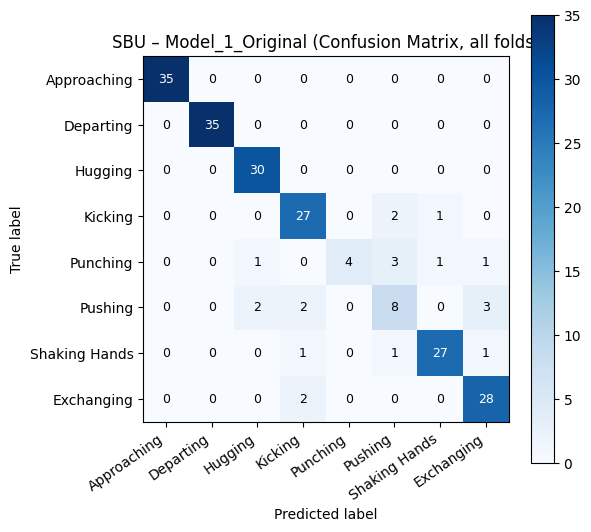

Model_1_Original: /content/drive/MyDrive/ml_runs/_reports/sbu_cm/aggregated/Model_1_Original/cm_test_all_folds.png


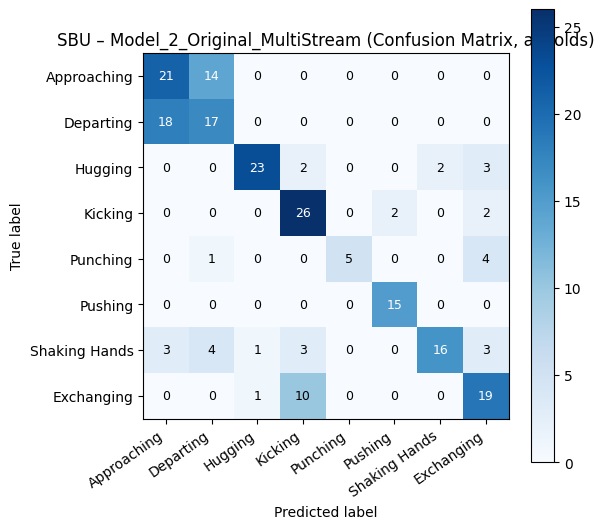

Model_2_Original_MultiStream: /content/drive/MyDrive/ml_runs/_reports/sbu_cm/aggregated/Model_2_Original_MultiStream/cm_test_all_folds.png


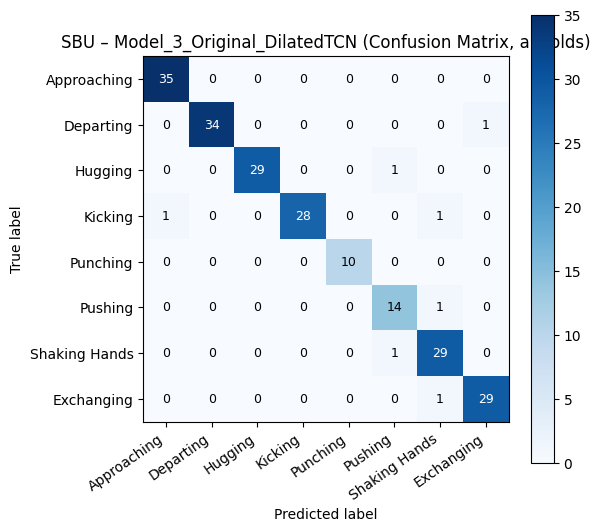

Model_3_Original_DilatedTCN: /content/drive/MyDrive/ml_runs/_reports/sbu_cm/aggregated/Model_3_Original_DilatedTCN/cm_test_all_folds.png


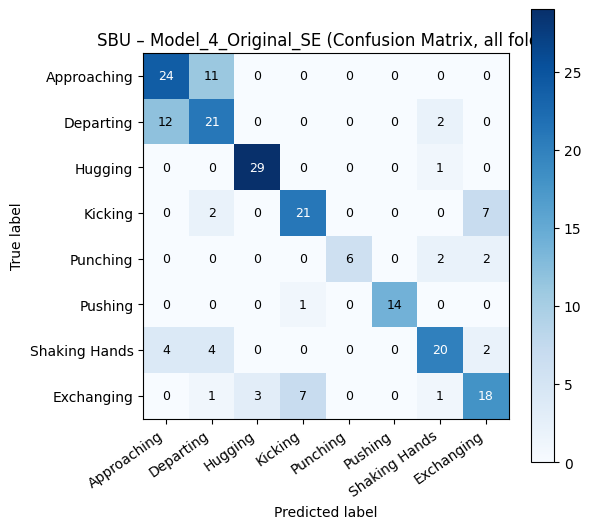

Model_4_Original_SE: /content/drive/MyDrive/ml_runs/_reports/sbu_cm/aggregated/Model_4_Original_SE/cm_test_all_folds.png


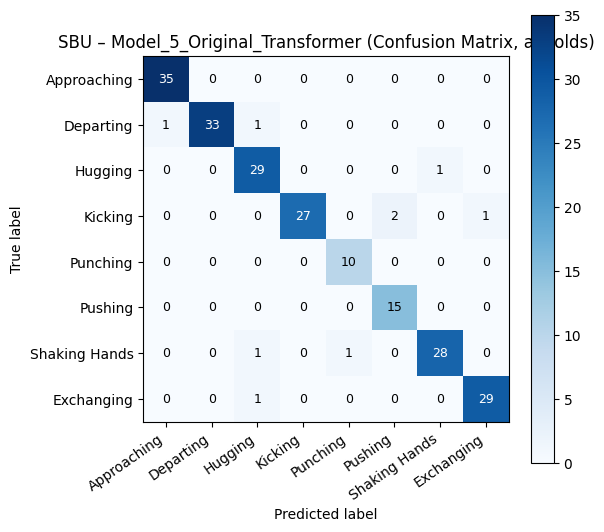

Model_5_Original_Transformer: /content/drive/MyDrive/ml_runs/_reports/sbu_cm/aggregated/Model_5_Original_Transformer/cm_test_all_folds.png


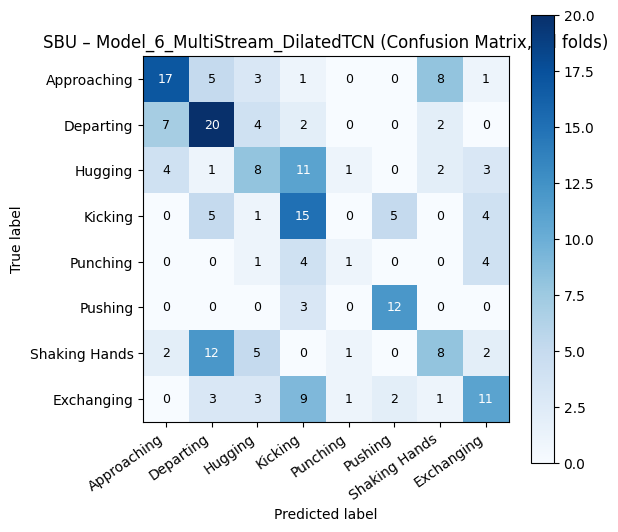

Model_6_MultiStream_DilatedTCN: /content/drive/MyDrive/ml_runs/_reports/sbu_cm/aggregated/Model_6_MultiStream_DilatedTCN/cm_test_all_folds.png


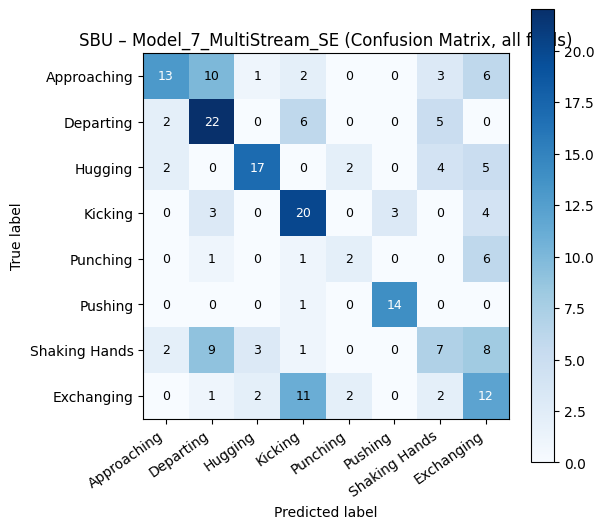

Model_7_MultiStream_SE: /content/drive/MyDrive/ml_runs/_reports/sbu_cm/aggregated/Model_7_MultiStream_SE/cm_test_all_folds.png


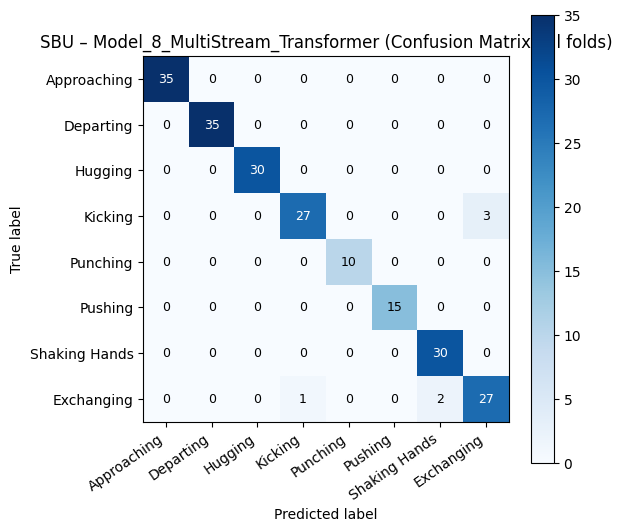

Model_8_MultiStream_Transformer: /content/drive/MyDrive/ml_runs/_reports/sbu_cm/aggregated/Model_8_MultiStream_Transformer/cm_test_all_folds.png


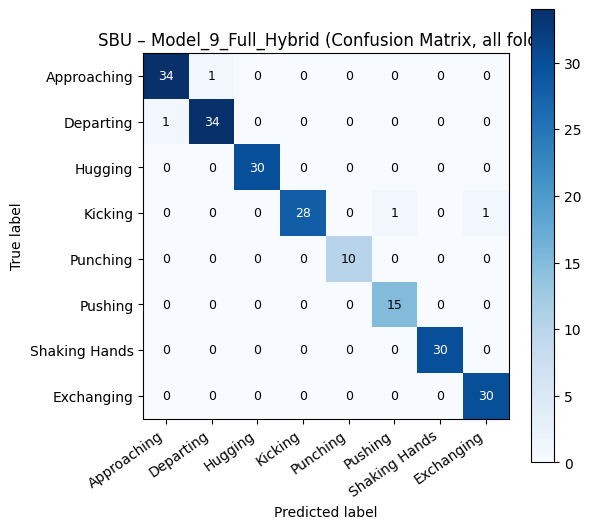

Model_9_Full_Hybrid: /content/drive/MyDrive/ml_runs/_reports/sbu_cm/aggregated/Model_9_Full_Hybrid/cm_test_all_folds.png


In [12]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# base paths
MODELS_BASE = Path("/content/drive/MyDrive/ml_runs/sbu_models")
SAVE_BASE   = Path("/content/drive/MyDrive/ml_runs/_reports/sbu_cm/aggregated")
SAVE_BASE.mkdir(parents=True, exist_ok=True)

# models (folder names under sbu_models)
MODELS = [
    "Model_1_Original",
    "Model_2_Original_MultiStream",
    "Model_3_Original_DilatedTCN",
    "Model_4_Original_SE",
    "Model_5_Original_Transformer",
    "Model_6_MultiStream_DilatedTCN",
    "Model_7_MultiStream_SE",
    "Model_8_MultiStream_Transformer",
    "Model_9_Full_Hybrid",
]

# fixed SBU class names in label-id order 0..7
SBU_CLASSES = [
    "Approaching", "Departing", "Hugging", "Kicking",
    "Punching", "Pushing", "Shaking Hands", "Exchanging"
]

def load_cm(path: Path) -> np.ndarray:
    return np.loadtxt(path, delimiter=",").astype(int)

for model in MODELS:
    out_dir = MODELS_BASE / model / "outputs"
    fold_dirs = sorted([p for p in out_dir.iterdir() if p.is_dir() and p.name.lower().startswith("fold")])

    cm_sum = None
    for d in fold_dirs:
        fp = d / "cm_test.csv"
        if fp.exists():
            cm = load_cm(fp)
            cm_sum = cm if cm_sum is None else (cm_sum + cm)

    if cm_sum is None:
        print(f"[skip] no cm_test.csv found for {model}")
        continue

    # sanity: if shape isn't 8x8, still plot with numeric ticks
    n = cm_sum.shape[0]
    if n == 8:
        tick_labels = SBU_CLASSES
    else:
        tick_labels = [str(i) for i in range(n)]

    # figure
    plt.figure(figsize=(6.2, 5.6))
    plt.imshow(cm_sum, interpolation="nearest", cmap="Blues")
    plt.colorbar()
    ticks = np.arange(n)
    plt.xticks(ticks, tick_labels, rotation=35, ha="right")
    plt.yticks(ticks, tick_labels)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"SBU – {model} (Confusion Matrix, all folds)")

    # numbers
    vmax = cm_sum.max() if cm_sum.size else 0
    thresh = vmax / 2.0 if vmax > 0 else 0.5
    for i in range(n):
        for j in range(n):
            v = int(cm_sum[i, j])
            plt.text(j, i, str(v),
                     ha="center", va="center",
                     color="white" if v > thresh else "black", fontsize=9)

    save_dir = SAVE_BASE / model
    save_dir.mkdir(parents=True, exist_ok=True)
    save_path = save_dir / "cm_test_all_folds.png"
    plt.tight_layout()
    plt.savefig(save_path, dpi=200)
    plt.show()

    print(f"{model}: {save_path}")

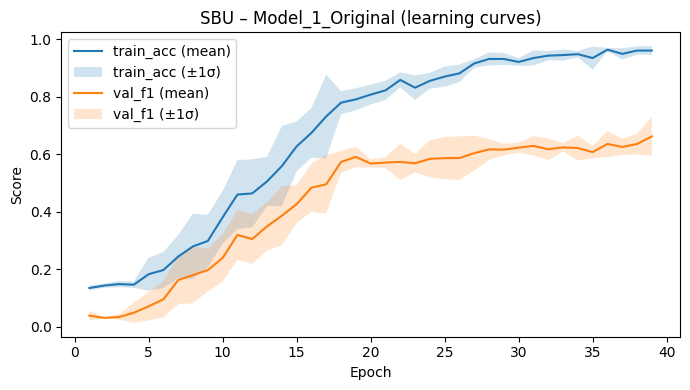

Saved: /content/drive/MyDrive/ml_runs/_reports/sbu_curves/Model_1_Original/learning_curves_mean_std.png


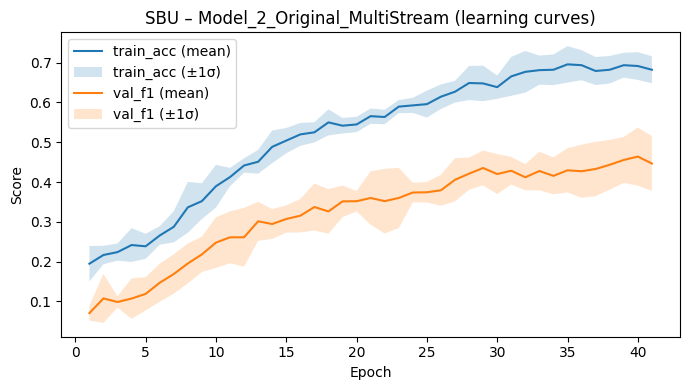

Saved: /content/drive/MyDrive/ml_runs/_reports/sbu_curves/Model_2_Original_MultiStream/learning_curves_mean_std.png


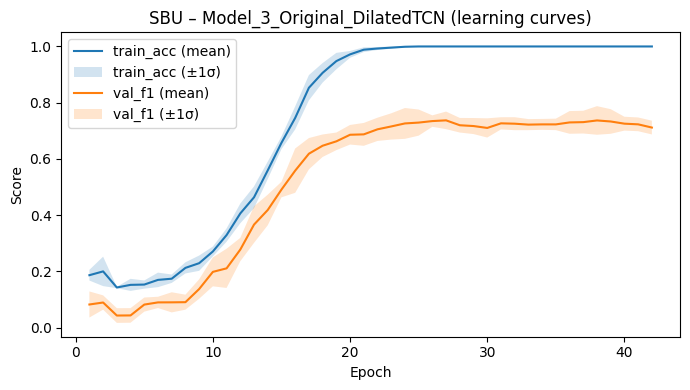

Saved: /content/drive/MyDrive/ml_runs/_reports/sbu_curves/Model_3_Original_DilatedTCN/learning_curves_mean_std.png


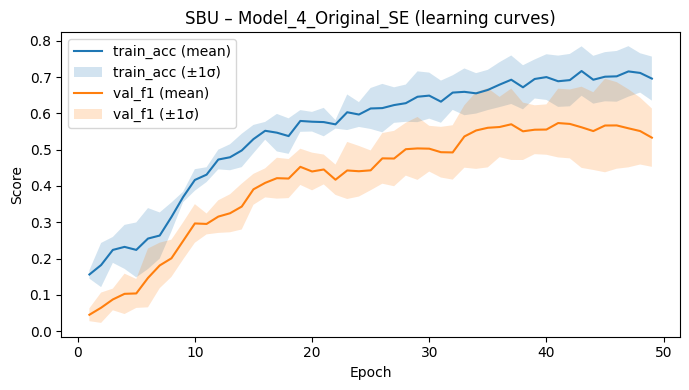

Saved: /content/drive/MyDrive/ml_runs/_reports/sbu_curves/Model_4_Original_SE/learning_curves_mean_std.png


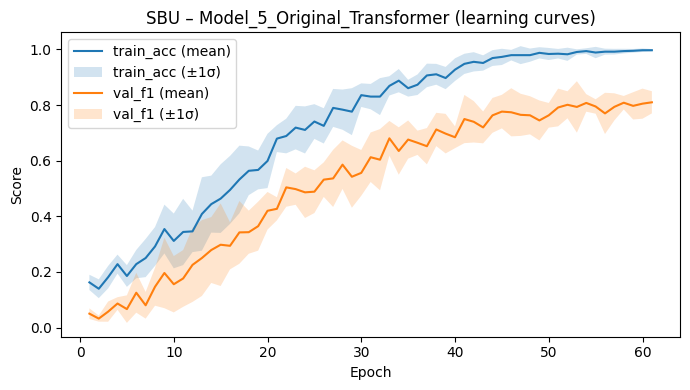

Saved: /content/drive/MyDrive/ml_runs/_reports/sbu_curves/Model_5_Original_Transformer/learning_curves_mean_std.png


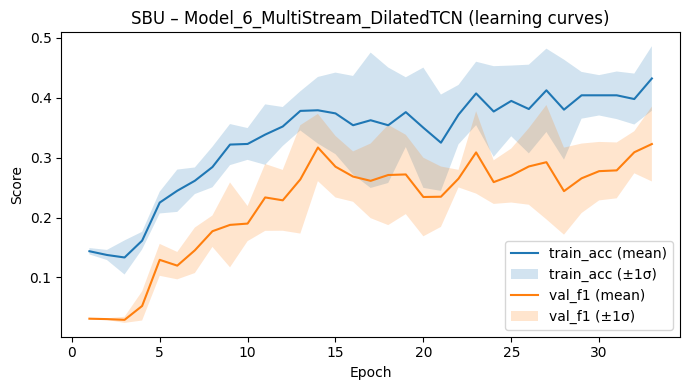

Saved: /content/drive/MyDrive/ml_runs/_reports/sbu_curves/Model_6_MultiStream_DilatedTCN/learning_curves_mean_std.png


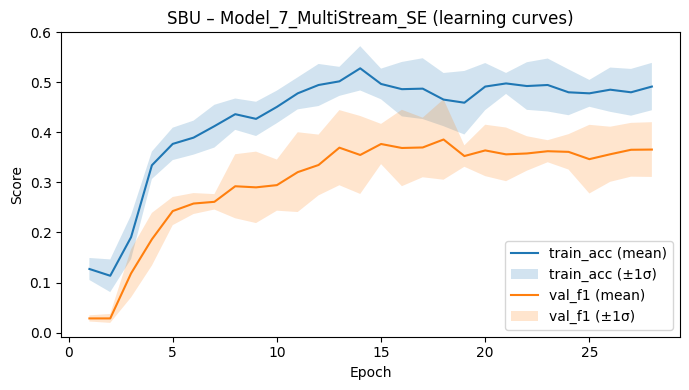

Saved: /content/drive/MyDrive/ml_runs/_reports/sbu_curves/Model_7_MultiStream_SE/learning_curves_mean_std.png


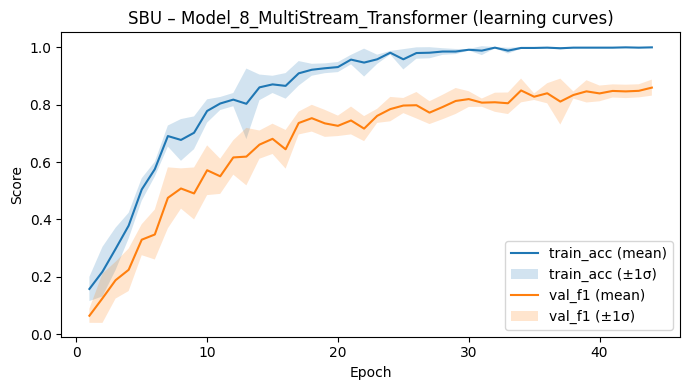

Saved: /content/drive/MyDrive/ml_runs/_reports/sbu_curves/Model_8_MultiStream_Transformer/learning_curves_mean_std.png


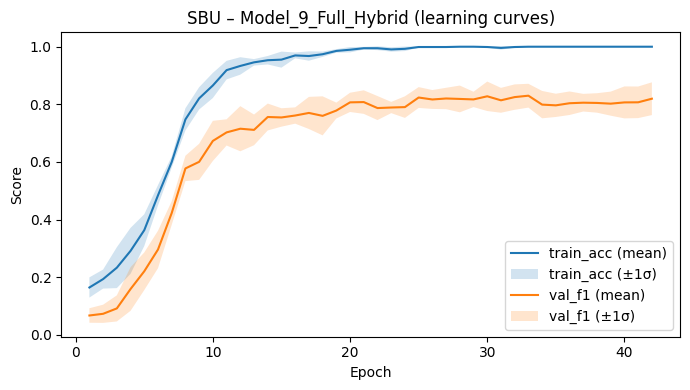

Saved: /content/drive/MyDrive/ml_runs/_reports/sbu_curves/Model_9_Full_Hybrid/learning_curves_mean_std.png


In [13]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

models = {
    "Model_1_Original": "/content/drive/MyDrive/ml_runs/sbu_models/Model_1_Original/outputs",
    "Model_2_Original_MultiStream": "/content/drive/MyDrive/ml_runs/sbu_models/Model_2_Original_MultiStream/outputs",
    "Model_3_Original_DilatedTCN": "/content/drive/MyDrive/ml_runs/sbu_models/Model_3_Original_DilatedTCN/outputs",
    "Model_4_Original_SE": "/content/drive/MyDrive/ml_runs/sbu_models/Model_4_Original_SE/outputs",
    "Model_5_Original_Transformer": "/content/drive/MyDrive/ml_runs/sbu_models/Model_5_Original_Transformer/outputs",
    "Model_6_MultiStream_DilatedTCN": "/content/drive/MyDrive/ml_runs/sbu_models/Model_6_MultiStream_DilatedTCN/outputs",
    "Model_7_MultiStream_SE": "/content/drive/MyDrive/ml_runs/sbu_models/Model_7_MultiStream_SE/outputs",
    "Model_8_MultiStream_Transformer": "/content/drive/MyDrive/ml_runs/sbu_models/Model_8_MultiStream_Transformer/outputs",
    "Model_9_Full_Hybrid": "/content/drive/MyDrive/ml_runs/sbu_models/Model_9_Full_Hybrid/outputs",
}
out_root = Path("/content/drive/MyDrive/ml_runs/_reports/sbu_curves")
out_root.mkdir(parents=True, exist_ok=True)

def load_histories(root):
    dfs = []
    for k in range(1,6):
        p = Path(root)/f"fold{k}"/"history.csv"
        if p.exists():
            df = pd.read_csv(p)
            keep = [c for c in ["epoch","train_acc","val_f1"] if c in df.columns]
            if set(["epoch","train_acc","val_f1"]).issubset(keep):
                dfs.append(df[keep].copy())
    return dfs

def aggregate_mean_std(dfs):
    base = dfs[0][["epoch"]].copy()
    for i, d in enumerate(dfs):
        base = base.merge(d, on="epoch", suffixes=("",""))
        base.rename(columns={"train_acc":f"tr_{i}", "val_f1":f"vf_{i}"}, inplace=True)
    tr_cols = [c for c in base.columns if c.startswith("tr_")]
    vf_cols = [c for c in base.columns if c.startswith("vf_")]
    agg = pd.DataFrame({
        "epoch": base["epoch"],
        "train_acc_mean": base[tr_cols].mean(axis=1),
        "train_acc_std":  base[tr_cols].std(axis=1, ddof=0),
        "val_f1_mean":    base[vf_cols].mean(axis=1),
        "val_f1_std":     base[vf_cols].std(axis=1, ddof=0),
    })
    return agg

for name, root in models.items():
    dfs = load_histories(root)
    if len(dfs) < 2:
        print(f"Skipped {name} (insufficient histories)")
        continue
    min_last = min(d["epoch"].max() for d in dfs)
    dfs = [d[d["epoch"]<=min_last].reset_index(drop=True) for d in dfs]
    agg = aggregate_mean_std(dfs)
    save_dir = out_root/name
    save_dir.mkdir(parents=True, exist_ok=True)
    plt.figure(figsize=(7,4))
    e = agg["epoch"].values
    ta, tas = agg["train_acc_mean"].values, agg["train_acc_std"].values
    vf, vfs = agg["val_f1_mean"].values, agg["val_f1_std"].values
    plt.plot(e, ta, label="train_acc (mean)")
    plt.fill_between(e, ta-tas, ta+tas, alpha=0.2, label="train_acc (±1σ)")
    plt.plot(e, vf, label="val_f1 (mean)")
    plt.fill_between(e, vf-vfs, vf+vfs, alpha=0.2, label="val_f1 (±1σ)")
    plt.xlabel("Epoch"); plt.ylabel("Score"); plt.title(f"SBU – {name} (learning curves)")
    plt.legend()
    plt.tight_layout()
    fp = save_dir/"learning_curves_mean_std.png"
    plt.savefig(fp, dpi=150)
    plt.show()
    print(f"Saved: {fp}")

In [14]:
import os, json
from pathlib import Path
import numpy as np
import pandas as pd

DRIVE_ROOT = Path("/content/drive/MyDrive/ml_runs")
REPORT_DIR = DRIVE_ROOT / "_reports" / "sbu_metrics"
REPORT_DIR.mkdir(parents=True, exist_ok=True)

MODELS = {
    "Model_1_Original": "sbu_models/Model_1_Original/outputs",
    "Model_2_Original_MultiStream": "sbu_models/Model_2_Original_MultiStream/outputs",
    "Model_3_Original_DilatedTCN": "sbu_models/Model_3_Original_DilatedTCN/outputs",
    "Model_4_Original_SE": "sbu_models/Model_4_Original_SE/outputs",
    "Model_5_Original_Transformer": "sbu_models/Model_5_Original_Transformer/outputs",
    "Model_6_MultiStream_DilatedTCN": "sbu_models/Model_6_MultiStream_DilatedTCN/outputs",
    "Model_7_MultiStream_SE": "sbu_models/Model_7_MultiStream_SE/outputs",
    "Model_8_MultiStream_Transformer": "sbu_models/Model_8_MultiStream_Transformer/outputs",
    "Model_9_Full_Hybrid": "sbu_models/Model_9_Full_Hybrid/outputs",
}

KEY_ALIASES = {
    "acc": ["test_acc", "accuracy"],
    "prec_macro": ["test_precision_macro", "test_precision"],
    "rec_macro": ["test_recall_macro", "test_recall"],
    "f1_macro": ["test_f1_macro", "test_f1"],
    "prec_weighted": ["test_precision_weighted"],
    "rec_weighted": ["test_recall_weighted"],
    "f1_weighted": ["test_f1_weighted"]
}

def read_json(p):
    if not p.exists(): return {}
    with open(p, "r") as f:
        try: return json.load(f)
        except: return {}

def extract_metric(d, aliases):
    for k in aliases:
        if k in d: return float(d[k])
    return np.nan

def aggregate_model(model_name, out_dir):
    vals = {k: [] for k in KEY_ALIASES}
    found = False
    for kfold in range(1, 6):
        rjson = out_dir / f"fold{kfold}" / "results.json"
        d = read_json(rjson)
        if d:
            found = True
            for std_key, aliases in KEY_ALIASES.items():
                v = extract_metric(d, aliases)
                vals[std_key].append(v)
    if not found:
        scsv = out_dir / "summary.csv"
        if scsv.exists():
            df = pd.read_csv(scsv)
            if "Mean" in df.index: df = df.drop("Mean")
            for std_key in KEY_ALIASES:
                for c in df.columns:
                    if std_key.split("_")[0] in c.lower():
                        vals[std_key] = pd.to_numeric(df[c], errors="coerce").tolist()
                        break
    def m_s(a):
        a = np.array(a, dtype=float)
        a = a[~np.isnan(a)]
        if a.size == 0: return np.nan, np.nan
        return float(a.mean()), float(a.std(ddof=0))
    out = {"Model": model_name}
    for k in KEY_ALIASES:
        m, s = m_s(vals[k])
        out[f"{k}_mean"] = m
        out[f"{k}_std"] = s
    return out

rows = [aggregate_model(n, DRIVE_ROOT / p) for n, p in MODELS.items()]
df = pd.DataFrame(rows)
order = ["Model","acc_mean","acc_std","prec_macro_mean","prec_macro_std","rec_macro_mean","rec_macro_std","f1_macro_mean","f1_macro_std","prec_weighted_mean","prec_weighted_std","rec_weighted_mean","rec_weighted_std","f1_weighted_mean","f1_weighted_std"]
for c in order:
    if c not in df.columns: df[c] = np.nan
df = df[order].sort_values(by="f1_macro_mean", ascending=False)
out_csv = REPORT_DIR / "all_models_summary.csv"
df.to_csv(out_csv, index=False)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 160)
print(df.round(4).to_string(index=False))
print(f"\nSaved: {out_csv}")

                          Model  acc_mean  acc_std  prec_macro_mean  prec_macro_std  rec_macro_mean  rec_macro_std  f1_macro_mean  f1_macro_std  prec_weighted_mean  prec_weighted_std  rec_weighted_mean  rec_weighted_std  f1_weighted_mean  f1_weighted_std
            Model_9_Full_Hybrid    0.9814   0.0174           0.9830          0.0150          0.9845         0.0138         0.9828        0.0148              0.9832             0.0171             0.9814            0.0174            0.9815           0.0174
Model_8_MultiStream_Transformer    0.9721   0.0271           0.9774          0.0237          0.9750         0.0243         0.9743        0.0251              0.9748             0.0265             0.9721            0.0271            0.9713           0.0280
    Model_3_Original_DilatedTCN    0.9674   0.0315           0.9726          0.0289          0.9673         0.0272         0.9661        0.0315              0.9744             0.0227             0.9674            0.0315            0.96


Model Ranking (Best → Worst) based on F1-macro:

 Rank                           Model  f1_macro_mean  acc_mean  prec_macro_mean  rec_macro_mean
    1             Model_9_Full_Hybrid         0.9828    0.9814           0.9830          0.9845
    2 Model_8_MultiStream_Transformer         0.9743    0.9721           0.9774          0.9750
    3     Model_3_Original_DilatedTCN         0.9661    0.9674           0.9726          0.9673
    4    Model_5_Original_Transformer         0.9576    0.9581           0.9606          0.9637
    5                Model_1_Original         0.8215    0.9023           0.8265          0.8333
    6             Model_4_Original_SE         0.7157    0.7116           0.7354          0.7190
    7    Model_2_Original_MultiStream         0.6719    0.6605           0.7132          0.6732
    8          Model_7_MultiStream_SE         0.4700    0.4977           0.5303          0.5000
    9  Model_6_MultiStream_DilatedTCN         0.3859    0.4279           0.3928       

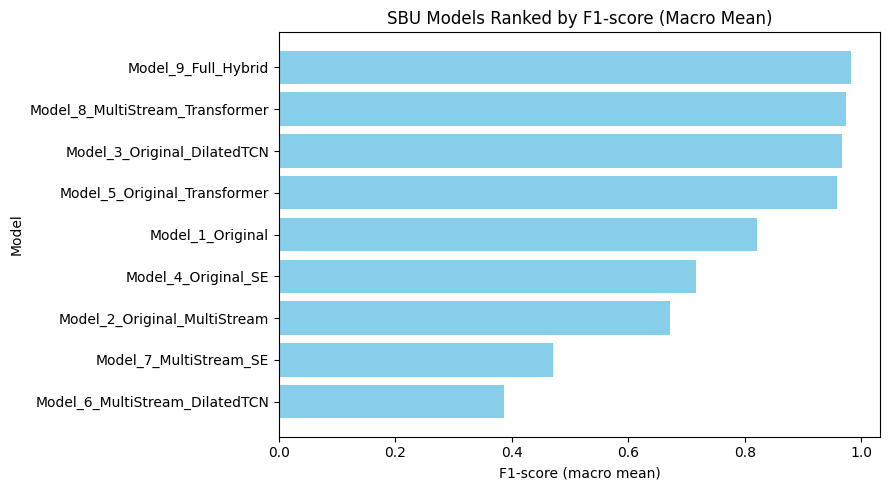

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

csv_path = Path("/content/drive/MyDrive/ml_runs/_reports/sbu_metrics/all_models_summary.csv")
df = pd.read_csv(csv_path)

df = df.sort_values(by="f1_macro_mean", ascending=False)
df["Rank"] = range(1, len(df) + 1)
df = df[["Rank", "Model", "f1_macro_mean", "acc_mean", "prec_macro_mean", "rec_macro_mean"]]

print("\nModel Ranking (Best → Worst) based on F1-macro:\n")
print(df.round(4).to_string(index=False))

plt.figure(figsize=(9,5))
plt.barh(df["Model"], df["f1_macro_mean"], color="skyblue")
plt.xlabel("F1-score (macro mean)")
plt.ylabel("Model")
plt.title("SBU Models Ranked by F1-score (Macro Mean)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()